# Helmholtz problem

This example notebook shows how to setup and solve the time-harmonic acoustic propagation problem, which is governed by the Helmholtz equation.

The Helmholtz equation is given by Fourier transforming the wave equation in the temporal domain, which gives

$$
    \left(\nabla +\frac{\omega^2}{c^2}\right)\phi = i \omega S_M,
$$

with $P, S_M \in C^{2}(\mathbb{C})$. 

In `jwave`, the Helmholtz equation solved also takes into account heterogeneous absorption and density, and it is given as
$$
\left(\frac{\omega^2}{c_0^2} + \nabla^2  - \frac{1}{\rho_0} \nabla \rho_0 \cdot \nabla  + \frac{2i\omega^3\alpha_0}{c_0} \right)P = i \omega S_M
$$
where:
- $\omega =2\pi f_0$ is the angular frequency, and $f_0$ is the frequency of the wave
- $\rho_0$ is the material density
- $\alpha_0$ is the attenuation coefficient
- $S_M$ is the mass source term

Before running the simulation, we'll import the necessary modules and utility functions

In [2]:
from functools import partial

# import pywt

import numpy as np
from jax import jit, jacobian, vjp, jacrev
import jax
from jax import numpy as jnp
from jax import random
import jax.scipy.linalg as linalg
from matplotlib import pyplot as plt

from jwave import FiniteDifferences, FourierSeries
from jwave.geometry import Domain, Medium, circ_mask
from jwave.utils import display_complex_field, show_positive_field

key = random.PRNGKey(42)  # Random seed
import jax.random as jr


import equinox as eqx
from equinox import nn
import optax

from hybridoed.forward import create_src_field, get_analytical_greens_function



In [2]:
# Defining geometry
# N = (64, 128)  # Grid size
# N = (32, 64)  # Grid size in m if the dx is 1.0
# N = (64, 64)  # Grid size
# N = (70, 70)  # Grid size
N = (32, 32)  # Grid size
# dx = (0.1, 0.1)  # Spatial resolution
dx = (1.0, 1.0)  # Spatial resolution
f = 400
omega = 2*jnp.pi*f  # Wavefield omega = 2*pi*f

# Defining the domain
domain = Domain(N, dx)

Performing time-harmonic simulations is very similar to standard wave propagation, with the difference that the source field is a static complex field.

In [3]:
# def create_src_field(N, x, y, domain, omega):
#     """
#     Creates a source field with a value set at the given x and y coordinates and computes its Fourier Series.

#     Parameters:
#     N (int): The size of the source field array.
#     x (int): The x-coordinate where the value will be set.
#     y (int): The y-coordinate where the value will be set.
#     domain (array-like): The domain for the Fourier Series.
#     omega (float): The omega value for the Fourier Series.

#     Returns:
#     array: The computed Fourier Series of the source field.
#     """
#     src_field = jnp.zeros(N).astype(jnp.complex64)

#     x = jnp.array(x)
#     y = jnp.array(y)


#     x = x.astype(jnp.int32)
#     y = y.astype(jnp.int32)
#     src_field = src_field.at[x, y].set(1.0)
#     src = FourierSeries(jnp.expand_dims(src_field, -1), domain) * omega
    
#     return src


# def create_src_field(N, x, y, domain, omega):
#     """
#     Creates a source field with bilinear interpolation at the given (x, y) coordinates
#     and computes its Fourier Series.

#     Parameters:
#     N (tuple of int): The size of the source field array (height, width).
#     x (float): The x-coordinate of the source.
#     y (float): The y-coordinate of the source.
#     domain (array-like): The domain for the Fourier Series.
#     omega (float): The omega value for the Fourier Series.

#     Returns:
#     array: The computed Fourier Series of the source field.
#     """
#     src_field = jnp.zeros(N).astype(jnp.complex64)

#     # Ensure the coordinates are within the valid range
#     x = jnp.clip(x, 0, N[0] - 1)
#     y = jnp.clip(y, 0, N[1] - 1)

#     # Compute the floor and ceil of the coordinates
#     x_floor = jnp.floor(x).astype(jnp.int32)
#     y_floor = jnp.floor(y).astype(jnp.int32)
#     x_ceil = jnp.ceil(x).astype(jnp.int32)
#     y_ceil = jnp.ceil(y).astype(jnp.int32)

#     # Compute interpolation weights
#     w_floor_floor = (x_ceil - x) * (y_ceil - y)
#     w_floor_ceil = (x_ceil - x) * (y - y_floor)
#     w_ceil_floor = (x - x_floor) * (y_ceil - y)
#     w_ceil_ceil = (x - x_floor) * (y - y_floor)

#     # Apply weights to the four surrounding grid points
#     src_field = src_field.at[x_floor, y_floor].add(w_floor_floor)
#     src_field = src_field.at[x_floor, y_ceil].add(w_floor_ceil)
#     src_field = src_field.at[x_ceil, y_floor].add(w_ceil_floor)
#     src_field = src_field.at[x_ceil, y_ceil].add(w_ceil_ceil)

#     # Compute the Fourier Series of the source field
#     src = FourierSeries(jnp.expand_dims(src_field, -1), domain) * omega

#     return src

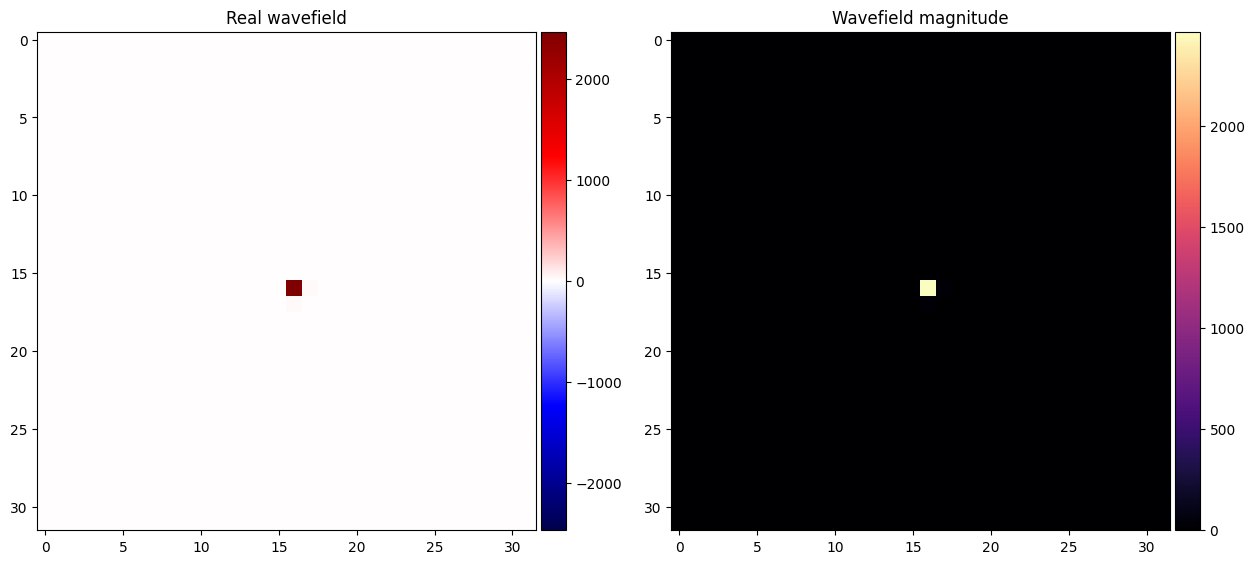

In [4]:
# x =  20.1  *2
# y =  15.1 
# x = 55.1
# y = 15.1
x = N[0]//2 + 0.01
y = N[1]//2 + 0.01
src_coord = jnp.array([[y, x]]).astype(jnp.float32)
# receiver_coords = jnp.array([[8.1, 28.1]]).astype(jnp.float32)
# receiver_coords = jnp.array([[8.1, 2*28.1]]).astype(jnp.float32)

# many receivers
receiver_coords = jnp.array([[8.1, 0.125*N[1]+0.1]]).astype(jnp.float32)

# receiver_coords = jnp.array([[8.1, 0.125*N[1]+0.1],[8.1, 0.25*N[1]+0.1], [8.1, 0.5*N[1]+0.1], [8.1, 0.75*N[1]+0.1], [8.1, 0.90*N[1]+0.1],]).astype(jnp.float32)

src = create_src_field(N, src_coord[0][0], src_coord[0][1], domain, omega)

# Plotting
_ = display_complex_field(src)

In [5]:
Domain

jaxdf.geometry.Domain

In [6]:
print(src_coord[0][1])

16.01


(500, 1, 70, 70)


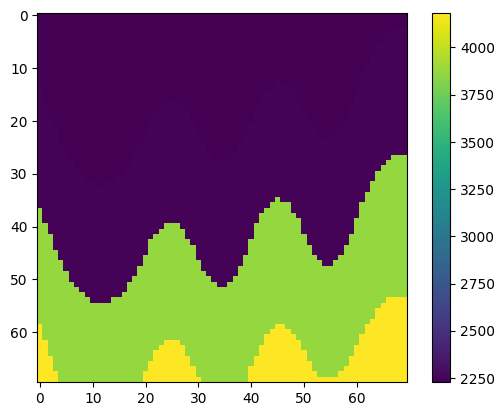

(500, 1, 32, 32)


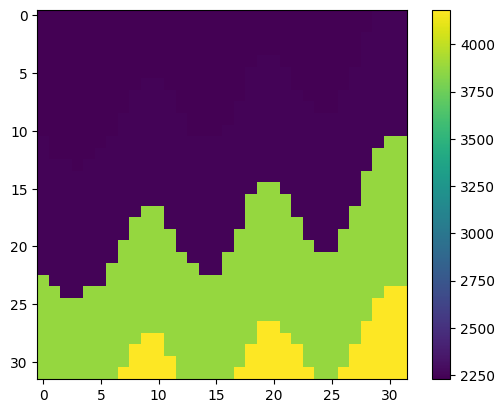

In [7]:
# load data1.npy
model = np.load('model1.npy')
print(model.shape)

plt.imshow(model[4,0,:,:])
plt.colorbar()
plt.show()

# downsample to 32 by 32
model = model[:,:,6::2,6::2]
print(model.shape)

plt.imshow(model[4,0,:,:])
plt.colorbar()


In [8]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)

density = 1000.  # sound_speed*0 + 1.
attenuation = 0.0  # density*0

# sound_speed = jnp.full(N, 1540.)
sound_speed = jnp.array(model[4,0,:,:])

pml_size = 15

# make a square in the middle of the domain
# sound_speed = sound_speed.at[N[0]//3:N[0]//3+8, N[1]//3:int(N[1]//4 * 2.5)].set(1000.)



true_medium = Medium(domain=domain, sound_speed=sound_speed,pml_size=pml_size)



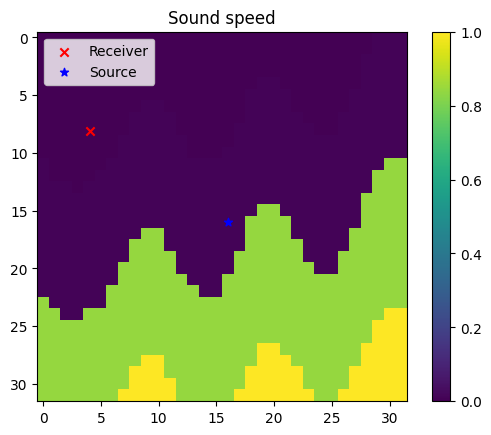

In [9]:
# plot the medium
plt.figure()
plt.imshow(true_medium.sound_speed.on_grid)
# add the receiver position
# plot all the receivers

plt.scatter(*receiver_coords.T[::-1], color='r', marker='x')

# plt.scatter(*receiver_coords[0][::-1], color='r', marker='x')
plt.scatter(*src_coord[0][::-1], color='b', marker='*')
plt.colorbar()
plt.title("Sound speed")
plt.legend(["Receiver", "Source"], loc='upper left')
plt.show()


In [10]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

@jit
def solve_helmholtz_general(sound_speed, src_coord, omega):
    src = create_src_field(N, src_coord[0], src_coord[1], domain, omega)
    medium = Medium(domain=domain, sound_speed=sound_speed, density=1000., pml_size=pml_size)
    field = helmholtz_solver(medium, omega, src)
    return field.on_grid.squeeze()

# @jit
# def solve_helmholtz(sound_speed):
#     medium = Medium(domain=domain, sound_speed=sound_speed, density=1000.,pml_size=pml_size)
#     return helmholtz_solver(medium, omega, src)
# @jit
# def solve_helmholtz_scalar(sound_speed):
#     medium = Medium(domain=domain, sound_speed=sound_speed, density=1000.,pml_size=pml_size)
#     field = helmholtz_solver(medium, omega, src)
#     return field.on_grid.squeeze()


# true_field = solve_helmholtz(sound_speed)
# true_field_on = solve_helmholtz_scalar(sound_speed)
# true_field = solve_helmholtz_general(sound_speed, domain=domain, src_coord=(y,x), omega=omega, pml_size=pml_size)
true_field = solve_helmholtz_general(sound_speed, [y,x], omega)

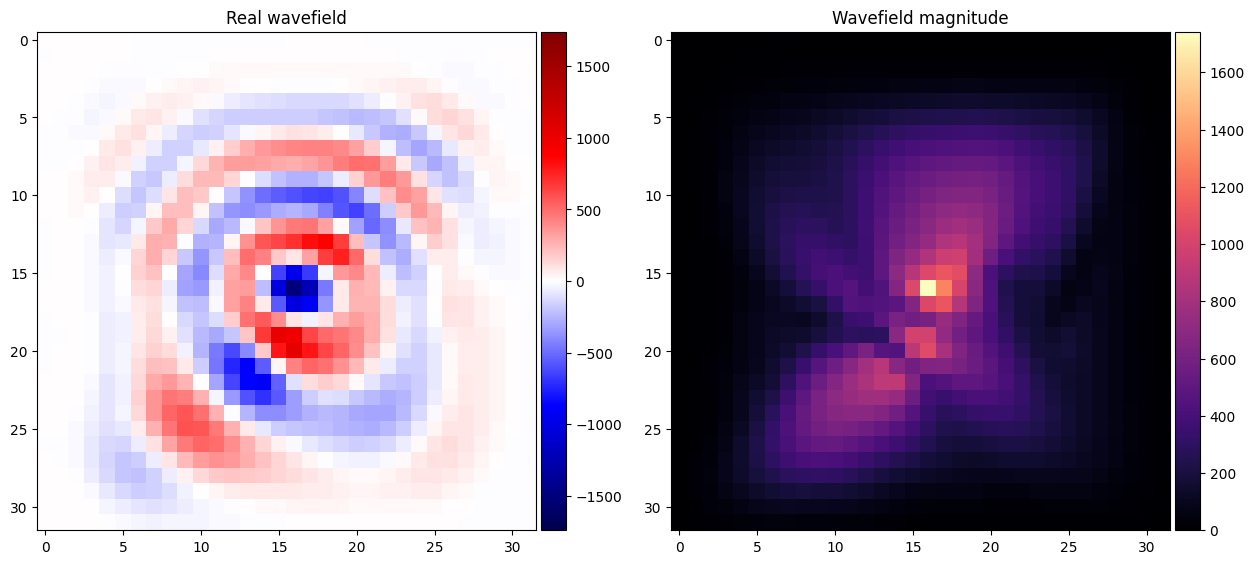

In [11]:
_ = display_complex_field(true_field)

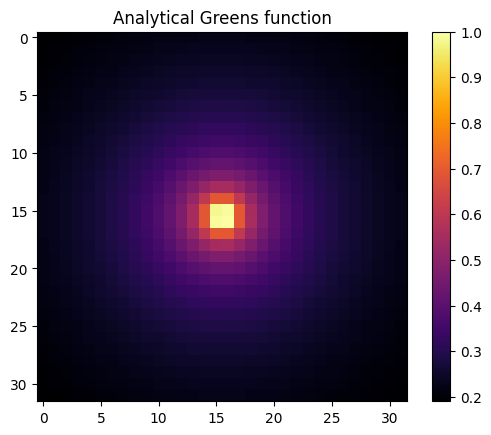

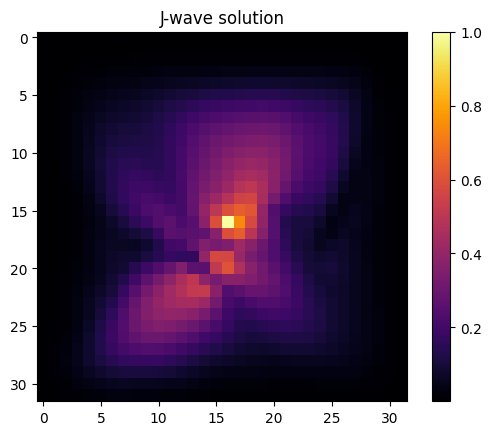

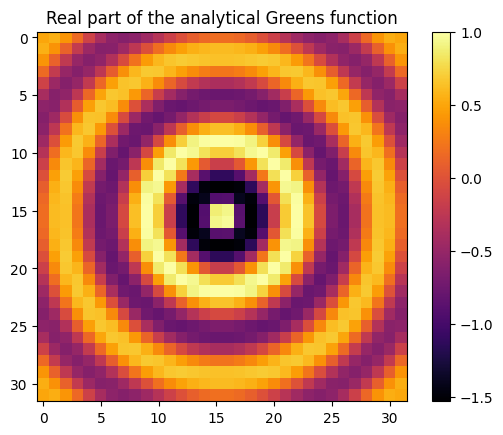

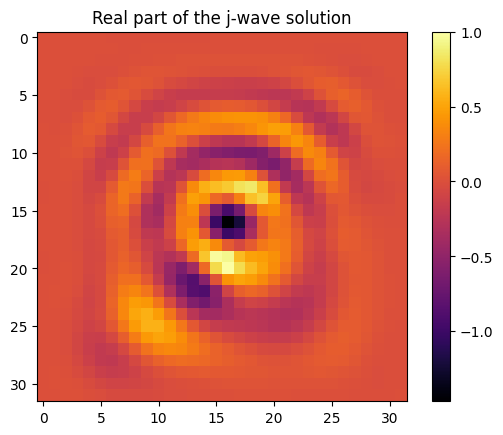

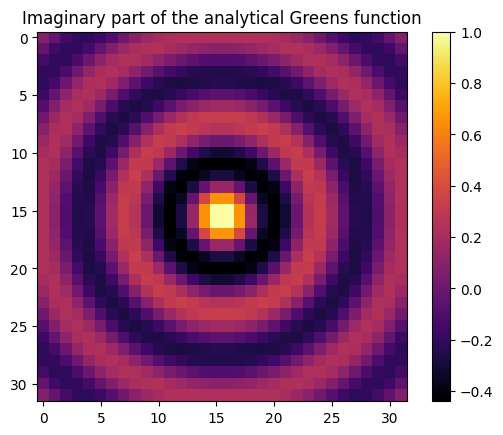

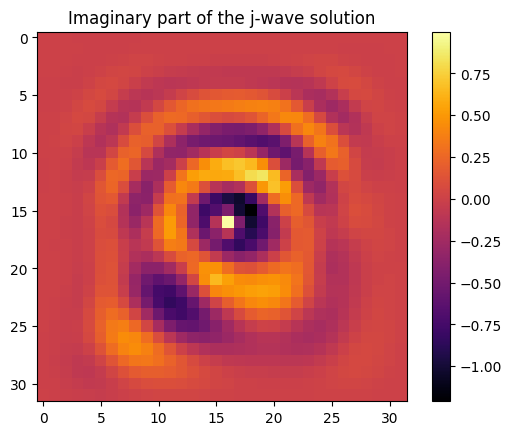

In [12]:
greens = get_analytical_greens_function(N[0], N[1], acoustic_velocity=1540.0, x_source=src_coord[0][0], y_source=src_coord[0][1], f=200)

plt.figure()
plt.imshow(jnp.fliplr(jnp.abs(greens).T) /jnp.amax(jnp.abs(greens)) , cmap='inferno')
plt.colorbar()
plt.title("Analytical Greens function")
plt.show()


plt.figure()
plt.imshow(jnp.abs(true_field)/ jnp.amax(jnp.abs(true_field)), cmap='inferno')
plt.colorbar()
plt.title("J-wave solution")
plt.show()


# plot the real part of the field
plt.figure()
plt.imshow(jnp.fliplr(jnp.real(greens).T) / jnp.amax(jnp.real(greens)) , cmap='inferno')
plt.colorbar()
plt.title("Real part of the analytical Greens function")
plt.show()

plt.figure()
plt.imshow(jnp.real(true_field) / jnp.amax(jnp.real(true_field)) , cmap='inferno')
plt.colorbar()
plt.title("Real part of the j-wave solution")
plt.show()

# plot the imaginary part of the field
plt.figure()
plt.imshow(jnp.fliplr(jnp.imag(greens).T) / jnp.amax(jnp.imag(greens)), cmap='inferno')
plt.colorbar()
plt.title("Imaginary part of the analytical Greens function")
plt.show()

plt.figure()
plt.imshow(jnp.imag(true_field) / jnp.amax(jnp.imag(true_field)), cmap='inferno')
plt.colorbar()
plt.title("Imaginary part of the j-wave solution")
plt.show()



In [13]:
# # save the true field to file
# np.save("true_field.npy", true_field)

In [14]:
# # differece between the analytical and the j-wave solution
# plt.figure()
# plt.imshow(jnp.real(greens)/jnp.amax(jnp.real(greens)) - jnp.real(true_field)/jnp.amax(jnp.real(true_field)) , cmap='inferno')
# # center the colorbar at 01
# plt.clim(-1, 1)

# plt.colorbar()
# plt.title("Difference between the analytical and the j-wave solution")
# plt.show()

### Derivative of the pressure field with respect to the source position (x,y)

In [37]:
def real_part_field(sound_speed, src_coord, omega):
    field = solve_helmholtz_general(sound_speed, src_coord, omega)
    return jnp.real(field)

def imag_part_field(sound_speed, src_coord, omega):
    field = solve_helmholtz_general(sound_speed, src_coord, omega)
    return jnp.imag(field)

def compute_jacobian_part(sound_speed, src_coord, omega):
    jacobian_real = jacrev(real_part_field, argnums=1)(sound_speed, src_coord, omega)
    jacobian_imag = jacrev(imag_part_field, argnums=1)(sound_speed, src_coord, omega)
    return jacobian_real, jacobian_imag

In [38]:
duds_real, duds_imag = compute_jacobian_part(sound_speed, src_coord, omega)
print(duds_real.shape, duds_imag.shape)

(32, 32, 1, 2) (32, 32, 1, 2)


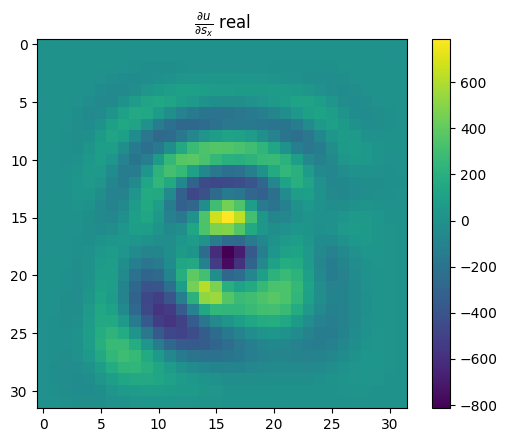

In [39]:
plt.figure()
plt.imshow((duds_real[:,:,0,0]))
plt.colorbar()
plt.title(r"$\frac{\partial u}{\partial{s_x}}$ real")
plt.show()


### Function to get the derivative of the pressure field with respect to the velocity model for a specific source and receiver pair

In [18]:
def compute_jacobian(src_list, sound_speed, omega):
    # Solve the Helmholtz equation for source locations
    src_field = []
    for src_coord in src_list:
        src_field.append(solve_helmholtz_general(sound_speed, src_coord, omega))
    
    # Define receiver locations
    x = 64
    y = 256 - 22
    rec_list = [[x, y], [x+40, y], [x-40, y], [x+60, y], [x-60, y]]
    
    # Solve the Helmholtz equation for receiver locations
    rec_field = []
    for rec_coord in rec_list:
        rec_field.append(solve_helmholtz_general(sound_speed, rec_coord, omega))
    
    # Compute the Green's function for the receiver field
    G_r = [rec for rec in rec_field]
    
    # Compute the Green's function for the source field
    G_s = [src for src in src_field]
    
    # Compute the Jacobian
    J = []
    for G_r_i in G_r:
        J_row = []
        for G_s_i in G_s:
            J_row.append((G_r_i * G_s_i))
        J.append(J_row)
    
    J = jnp.array(J)
    j_shape = J.shape
    J = J.reshape(int(j_shape[0]*j_shape[1]), int(j_shape[2]* j_shape[3]))
    
    # Plot the Jacobian
    # plt.figure()
    # plt.imshow(jnp.real(J[1].reshape(N)))
    # plt.colorbar()
    # plt.title("Jacobian")
    # plt.show()
    
    return J

def extract_receiver_values(field, receiver_coords):
    receiver_coords = receiver_coords.astype(jnp.int32)
    return jnp.array([field[coord[0], coord[1]] for coord in receiver_coords])

def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx) * (1 - wy) * top_left +
        wx * (1 - wy) * top_right +
        (1 - wx) * wy * bottom_left +
        wx * wy * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)

def compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag
    
    jacobians_real = []
    jacobians_imag = []
    
    for src_coord in src_coords:
        # Compute VJP for the given source
        (y_real, y_imag), vjp_fn = vjp(lambda s: field_at_receivers(s, src_coord,receiver_coords, omega), sound_speed)
        
        # Calculate VJP for both real and imaginary parts
        jacobian_real = vjp_fn((jnp.ones_like(y_real), jnp.zeros_like(y_imag)))[0]
        jacobian_imag = vjp_fn((jnp.zeros_like(y_real), jnp.ones_like(y_imag)))[0]
        
        jacobians_real.append(jacobian_real)
        jacobians_imag.append(jacobian_imag)
    
    # Stack the Jacobians for each source
    return jnp.array(jacobians_real), jnp.array(jacobians_imag)

def haar_transform_pywavelet(jacobian_matrix: np.ndarray, domainShape2D, level=None):
    """
    Apply 2D haar transform on the jacobian matrix

    Parameters
    ----------
    jacobian_matrix : np.ndarray each row is a flattened model size (nx*ny*nz)
    domainShape2D : tuple repesenting the shape of the jacobian discretization in 2D, (columns=x,rows=y)
    level : int, optional

    Returns
    -------
    jaco : np.ndarray, the haar transformed jacobian matrix (each row is a flattened model size (nx*ny*nz)
    c_list : list of pywt.FswavedecnResult, the list of the pywavelet result for each row of the jacobian matrix
    """
    # jaco = jacobian_matrix.copy()
    jaco = jnp.zeros_like(jacobian_matrix, dtype=jnp.complex64)
    c_list = []
    for row in range(jacobian_matrix.shape[0]):
        temp = jacobian_matrix[row, :]
        temp_R = temp.reshape(
            domainShape2D[0], domainShape2D[1]
        ).T  # to fit the way the jacobian is generated in salvus

        c = pywt.fswavedecn(temp_R, "haar")
        c_list.append(c)
        coeffs = (
            c.coeffs
        )  # The output is of size (columns=x,rows=y) or domainShape2D[::-1]
        # jaco[row, :] = np.ravel(coeffs)
        jaco = jaco.at[row, :].set(jnp.ravel(coeffs))
    return jaco, c_list

class FCN(eqx.Module):
    "Fully-connected neural network, with 1 hidden layer"
    
    input_layer: nn.Linear
    hidden_layer: nn.Linear
    output_layer: nn.Linear

    def __init__(self, in_size, hidden_size, out_size, key):
        "Initialise network parameters"
        
        key1, key2, key3 = jr.split(key, 3)
        self.input_layer = nn.Linear(in_size, hidden_size, key=key1)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size, key=key2)
        self.output_layer = nn.Linear(hidden_size, out_size, key=key3)

    def __call__(self, x):
        "Defines forward model"
        
        # x = (x/10)-0.5# normalise input to expected range (given observational data)
        x = jax.nn.tanh(self.input_layer(x))
        x = jax.nn.tanh(self.hidden_layer(x))
        x = self.output_layer(x)
        # index = jax.nn.softmax(x[0])  # Using softmax for the index to ensure valid probabilities
        # perturbation_value = jnp.abs(x[1])  # Using abs to ensure non-negative perturbation values
        # return jnp.array([index, perturbation_value])
        return x

def calculate_number_coeff_kept_after_haar_compression(
    hessian_diag_temp, alpha_fix=90.0
):
    """
    Calculate the number of coefficients kept after a haar compression

    Parameters:
    - hessian_diag_temp (np.ndarray): The diagonal of the hessian
    - alpha_fix (float): The alpha value to use for the haar compression

    Returns:
    - number_of_coeff_kept (int): The number of coefficients kept after the haar compression
    """
    mask_to_apply_to_every_row_of_transformed_jac, alphas, haar_coeff = (
        create_mask(hessian_diag_temp, alpha_fix=0.9)
    )
    

    return_mask = mask_to_apply_to_every_row_of_transformed_jac

    return np.sum(return_mask)

def create_mask(arr, threshold: float):
    arr = np.asarray(arr)  # Ensure arr is a numpy array for efficient operations
    total_sum = np.sum(arr)
    target_sum = threshold * total_sum

    # Get sorted indices
    sorted_indices = np.argsort(arr)[::-1]

    # Initialize cumulative sum and mask
    cumulative_sum = 0
    mask = np.zeros_like(arr, dtype=int)

    # Iterate over sorted indices
    for idx in sorted_indices:
        if cumulative_sum + arr[idx] > target_sum:
            break
        cumulative_sum += arr[idx]
        mask[idx] = 1

    return mask

def dummy_OED_criterion(Jacobian):
    """
    Dummy OED criterion that returns the sum of the diagonal of the Jacobian

    Parameters:
    - Jacobian (np.ndarray): The Jacobian matrix

    Returns:
    - OED_criterion (float): The OED criterion
    """
    return jnp.sum(jnp.diag(Jacobian)) * 1000 * 1000

def stable_det(A):
    # Perform LU decomposition
    P, L, U = linalg.lu(A)
    
    # Compute the log determinant from the diagonal of U
    logdet = jnp.sum(jnp.log(jnp.abs(jnp.diag(U))))
    
    # Adjust for the sign of the determinant
    sign = jnp.prod(jnp.sign(jnp.diag(U)))
    
    # Return the determinant as sign * exp(logdet)
    return sign * jnp.exp(logdet)

def stable_svd_det(A):
    # Perform Singular Value Decomposition
    U, s, Vh = jnp.linalg.svd(A, full_matrices=False)
    
    # Compute the log-determinant from the singular values
    logdet = jnp.sum(jnp.log(s))
    
    # Return the determinant as exp(logdet)
    return jnp.exp(logdet)

def scaled_det(A):
    # Scale the matrix by dividing by the largest element
    scale_factor = jnp.max(jnp.abs(A))
    A_scaled = A / scale_factor
    
    # Compute determinant of the scaled matrix using LU or SVD method
    det_scaled = stable_svd_det(A_scaled)
    
    # Adjust the determinant by the scaling factor
    det = det_scaled * (scale_factor ** A.shape[0])
    
    return det

def power_method(A, num_iters=100, tol=1e-6):
    # Get the shape of the matrix
    n = A.shape[0]

    # Initialize a random vector
    key = random.PRNGKey(0)
    v = random.normal(key, (n,))

    # Normalize the initial vector
    v = v / jnp.linalg.norm(v)

    for i in range(num_iters):
        # Multiply by the matrix
        v_next = jnp.dot(A, v)

        # Normalize the new vector
        v_next = v_next / jnp.linalg.norm(v_next)

        # Check for convergence
        if jnp.linalg.norm(v_next - v) < tol:
            break

        # Update the vector
        v = v_next

    # Approximate the largest eigenvalue
    eigenvalue = jnp.dot(v.T, jnp.dot(A, v))

    return eigenvalue, v

# @jit
def determiant_of_approximated_hessian(Jacobian):
    """
    Compute the determinant of the approximated Hessian matrix

    Parameters:
    - Jacobian (np.ndarray): The Jacobian matrix

    Returns:
    - determinant (float): The determinant of the approximated Hessian matrix
    """
    
    # copmut the sum of all the columns
    # print("jacobian shape",Jacobian.shape)
    # return jnp.abs(jnp.sum(jnp.abs(jnp.sum(Jacobian, axis=0))))
    # return jnp.sum(jnp.abs(jnp.diag(Jacobian.T @ Jacobian)))


    # return jnp.log10(jnp.linalg.cond(Jacobian.T @ Jacobian))

    eig_vals, eig_vec = jnp.linalg.eigh(jnp.conj(Jacobian).T @ Jacobian)

    # count the number of eigenvalues that are greater than 1e-10
    # threshold = 1e-14
    # return jnp.sum(eig_vals > threshold)

    
    # return jnp.sum(jax.nn.sigmoid(8e12 * (eig_vals - threshold)))



    # return jnp.sum(jax.scipy.special.entr(jnp.real(eig_vals) / jnp.sum(jnp.real(eig_vals))))

    return jnp.log10(jnp.var(eig_vals)) + 1e-5

    # hessian =   Jacobian.T @ Jacobian
    # regularized_hessian = hessian + 0.98 * jnp.eye(hessian.shape[0])
    # return ((jnp.linalg.det(hessian)))
    # return jnp.abs(scaled_det(hessian))
    # get the largest eigenvalue
    # lambda_max, _ = power_method(hessian)
    # return -jnp.real(jnp.trace((hessian/lambda_max)))

def compute_penalty(src_coord, domain_size, penalty_weight=1.0, epsilon=1e-1):
    """
    Computes a symmetric penalty based on the distance of the source to each domain border.
    
    Parameters:
    - src_coord: The coordinates of the source (x, y).
    - domain_size: The size of the domain (N_x, N_y).
    - penalty_weight: The weight of the penalty term.
    - epsilon: A small constant to avoid division by zero.
    
    Returns:
    - penalty: The symmetric penalty value considering all borders equally.
    """
    N_x, N_y = domain_size
    x, y = src_coord[0]  # Correct access to source coordinates

    # Calculate distance to each border
    d_left = x
    d_right = N_x - x
    d_top = y
    d_bottom = N_y - y

    # Ensure distances are non-zero to avoid division by zero
    d_left = jnp.amax(jnp.array([d_left, epsilon]))
    d_right = jnp.amax(jnp.array([d_right, epsilon]))
    d_top = jnp.amax(jnp.array([d_top, epsilon]))
    d_bottom = jnp.amax(jnp.array([d_bottom, epsilon]))

    # d_right = jnp.max(d_right, epsilon)
    # d_top = jnp.max(d_top, epsilon)
    # d_bottom = jnp.max(d_bottom, epsilon)

    # Compute penalties for each border
    penalty_left = penalty_weight / d_left
    penalty_right = penalty_weight / d_right
    penalty_top = penalty_weight / d_top
    penalty_bottom = penalty_weight / d_bottom

    # Combine the penalties symmetrically, ensuring equal weight to each border
    total_penalty = (penalty_left + penalty_right + penalty_top + penalty_bottom) / 4.0

    return total_penalty


# @jit
def objective_function(args): 

    src_coord, receiver_coords = args  
    # src_coord = args

    # delta_new_src_list = args(jnp.array(src_coord).ravel()).reshape(-1, 2)
    # print(new_src_list)
    # make sure that every value in new_src_list is a positive integer
    # delta_new_src_list = jnp.abs(delta_new_src_list)
    # new_src_list = jnp.array(src_coord) + delta_new_src_list 
    # new_src_list = new_src_list.round()
    # new_src_list = new_src_list.astype(int)

    # new_src_list = new_src_list.tolist()
    # print(new_src_list)

    # transform the args into all integers
    # print('raw arg',args)
    # args = jnp.round(args).astype(jnp.int32)
    # print('rounded args',args)

    J = compute_jacobian_at_receivers_vjp(sound_speed, src_coord, omega, receiver_coords)



    # plt.figure()
    # plt.imshow(jnp.real(J[0]))
    # plt.colorbar()
    # plt.title("Jacobian")
    # plt.show()

    # J = compute_jacobian(new_src_list, sound_speed, omega)


    # J_transformed, c_list = haar_transform_pywavelet(J, N, level=None)
    # diag_hessian = jnp.real(np.sum(np.conj(J_transformed) * J_transformed, axis=0))
    # print(diag_hessian.shape)
    # mask = create_mask(diag_hessian, 0.9)
    # # number_of_coeef_kept = jnp.sum(mask)
    # # print(mask)
    # print("number of true element in mask", jnp.sum(mask))
    # oed_criterion_result = jnp.sum(mask)

    # oed_criterion_result = jnp.abs(dummy_OED_criterion(J[0]))

    penality = compute_penalty(src_coord, N, penalty_weight=1.0, epsilon=2.6)

    # ravel every element and stack 
    J = jnp.vstack([jnp.ravel(j) for j in J])
    J = jnp.array(J) 
    if len(J) > 1:
        J = jnp.vstack(J)
        # print(J.shape)

    # eig_vals, eig_vec = jnp.linalg.eigh(jnp.conj(J).T @ J)

    # plt.figure()
    # plt.semilogy(jnp.real(eig_vals).sort()[::-1])
    # plt.title("eigen values")
    # plt.show()

    oed_criterion_result = determiant_of_approximated_hessian(J)

    return oed_criterion_result + 0*penality 
    # return penality


### Test wavelet transform in JAX

In [15]:
import jaxwt

key = jax.random.PRNGKey(0)

# Define the shape of the 2D array

# Create a random 2D array with values from a uniform distribution [0, 1)
random_array = jax.random.uniform(key, N)

fswavedecn = jaxwt.wavedec2(random_array, 'haar', level=1)

print(fswavedecn[1][0].shape)

ModuleNotFoundError: No module named 'jaxwt'

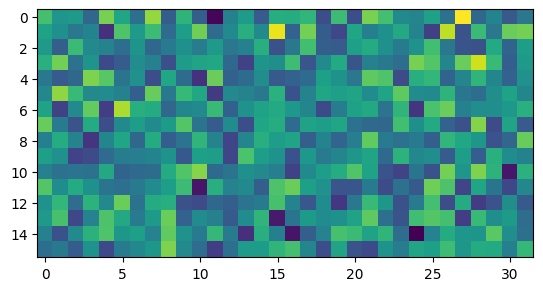

In [45]:
plt.imshow(fswavedecn[1][0][0])

### Test of the derivative of the field with respect to the velocity model

In [40]:
print("src_coord", src_coord)
print("receiver_coords", receiver_coords)

src_coord [[16.01 16.01]]
receiver_coords [[ 8.1  4.1]
 [ 8.1  8.1]
 [ 8.1 16.1]
 [ 8.1 24.1]
 [ 8.1 28.9]]


In [41]:
# Compute the Jacobian
# jacobian_values = compute_jacobian_at_receivers_vjp(sound_speed, src_coord, omega, receiver_coords)
dudm_real, dudm_imag = compute_jacobian_at_receivers_vjp(sound_speed, src_coord, omega, receiver_coords)


In [42]:
print(dudm_real.shape, dudm_imag.shape)

(1, 32, 32) (1, 32, 32)


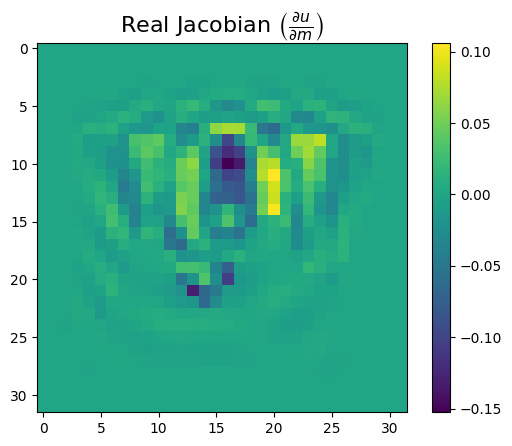

In [43]:
plt.figure()
plt.imshow((dudm_real[0]))
plt.colorbar()
plt.title(r"Real Jacobian $\left( \frac{\partial u}{\partial m}\right)$", fontsize=16)
plt.show()

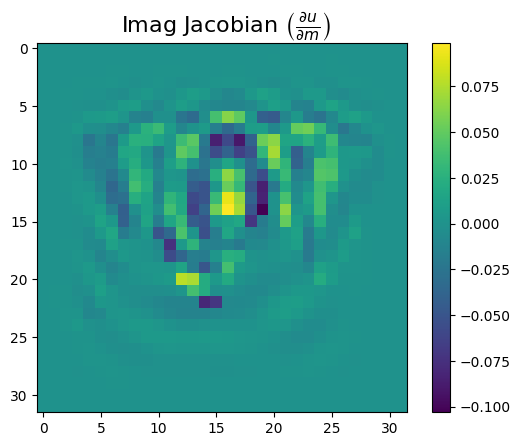

In [44]:
plt.figure()
plt.imshow((dudm_imag[0]))
plt.colorbar()
plt.title(r" Imag Jacobian $\left( \frac{\partial u}{\partial m}\right)$", fontsize=16)
plt.show()

In [45]:
# Assume compute_jacobian_at_receivers_vjp is defined correctly

# Define a wrapper to handle the real part computation
def real_jacobian_wrapped(sound_speed,src_coords, omega, receiver_coords):
    jacobians_real, _ = compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords)
    return jacobians_real

# # Define a wrapper to handle the imaginary part computation
def imag_jacobian_wrapped(sound_speed, src_coords, omega, receiver_coords):
    _, jacobians_imag = compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords)
    return jacobians_imag

# # Now, compute the gradient with respect to src_coords (argnums=0 since src_coords is the first argument here)
# grad_real_wrt_src = jax.jacrev(real_jacobian_wrapped, argnums=1)
# grad_imag_wrt_src = jax.jacrev(imag_jacobian_wrapped, argnums=1)

# # Example usage:
# grads_real_src = grad_real_wrt_src(sound_speed,src_coord, omega, receiver_coords)
# grads_imag_src = grad_imag_wrt_src(sound_speed,src_coord, omega, receiver_coords)

# print("Gradient of real part wrt src_coords:", grads_real_src)
# print("Gradient of imaginary part wrt src_coords:", grads_imag_src)

In [46]:
# Directly compute the VJP with respect to src_coords using the real part
_, vjp_fn_real = jax.vjp(real_jacobian_wrapped, sound_speed, src_coord, omega, receiver_coords)
grads_real_src = vjp_fn_real(jnp.ones_like(dudm_real))

# Directly compute the VJP with respect to src_coords using the imaginary part
_, vjp_fn_imag = jax.vjp(imag_jacobian_wrapped, sound_speed, src_coord, omega, receiver_coords)
grads_imag_src = vjp_fn_imag(jnp.ones_like(dudm_imag))

# print("Gradient of real part wrt src_coords using VJP:", grads_real_src)
# print("Gradient of imaginary part wrt src_coords using VJP:", grads_imag_src)

In [47]:
print(_.shape)
print(jnp.ones_like(dudm_imag).shape)

(1, 32, 32)
(1, 32, 32)


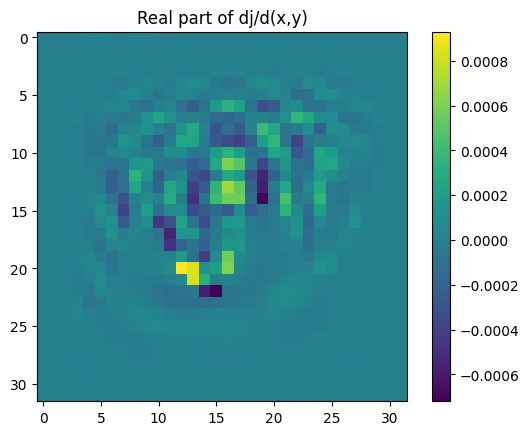

In [48]:
plt.figure()
plt.imshow(grads_real_src[0])
plt.colorbar()
plt.title("Real part of dj/d(x,y)")
plt.show()

(1024, 1024)


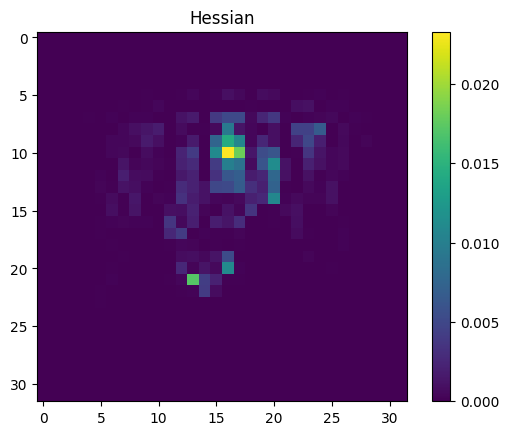

In [50]:
h = np.ravel(dudm_real[0]).reshape((1,int(N[0] * N[1]))).T @ np.ravel(dudm_real[0]).reshape((1, int(N[0] * N[1])))

print(h.shape)
plt.figure()
plt.imshow(jnp.diag(h).reshape(N))
plt.colorbar()
plt.title("Hessian")
plt.show()


In [51]:
eig_val, eig_vec = jnp.linalg.eig(h)
plt.plot(eig_val)
plt.show()


NotImplementedError: Nonsymmetric eigendecomposition is only implemented on the CPU backend. If your matrix is symmetric or Hermitian, you should use eigh instead.

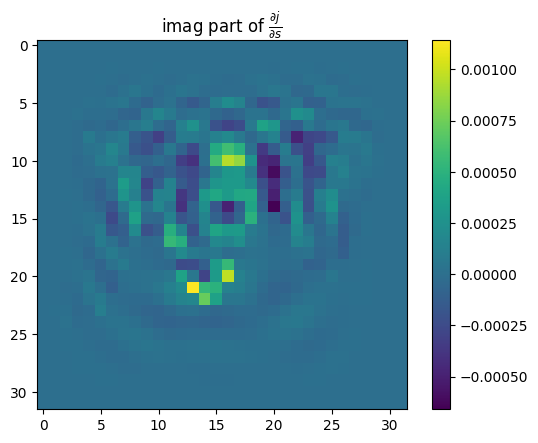

In [52]:
plt.figure()
plt.imshow(grads_imag_src[0])
plt.colorbar()
plt.title(r"imag part of $\frac{\partial j}{\partial s}$")
plt.show()

### Derivative of the OED function with respect to the Jacobians

In [53]:
args_test = (src_coord, receiver_coords)
objective_grad = jax.jax.value_and_grad(determiant_of_approximated_hessian)
args_test = grads_imag_src[0]
gradss = objective_grad(args_test)

TypeError: grad requires real-valued outputs (output dtype that is a sub-dtype of np.floating), but got int32. For differentiation of functions with integer outputs, use jax.vjp directly.

In [156]:
print(gradss[1].shape)

(16, 32)


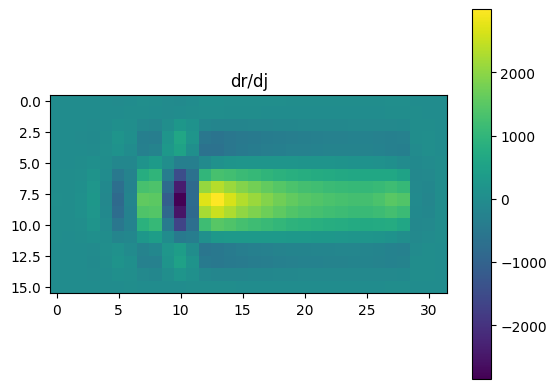

In [157]:
plt.figure()
plt.imshow(gradss[1])
plt.colorbar()
plt.title("dr/dj")
plt.show()


### Calculate the loss landscape for the position of the source

In [19]:
# calculate the loss landscape for the position of the source
from tqdm import tqdm

pbar = tqdm(total=N[0] * N[1])
loss_landscape = jnp.zeros(N)

for i in range(N[0]):
    for j in range(N[1]):
        source_coord_temp = jnp.array([[i+0.1, j+0.1]]).astype(jnp.float32)
        obj = objective_function((source_coord_temp, receiver_coords))
        # print("obj",obj)
        loss_landscape = loss_landscape.at[i, j].set(obj)
        # print("progression", i*N[1] + j, "out of", N[0]*N[1], loss_landscape[i, j])
        pbar.set_description(f"Loss: {loss_landscape[i, j]:.4f}")
        pbar.update(1)        
pbar.close()

Loss: -inf: 100%|██████████| 1024/1024 [06:19<00:00,  2.70it/s]   


In [ ]:
# load the loss landscape from .npy file
# np.save("loss_landscape_32x64_nRER1_4_smoothed.npy", loss_landscape)
# loss_landscape = np.load("loss_landscape_32x64_nRER1_4_smoothed.npy")

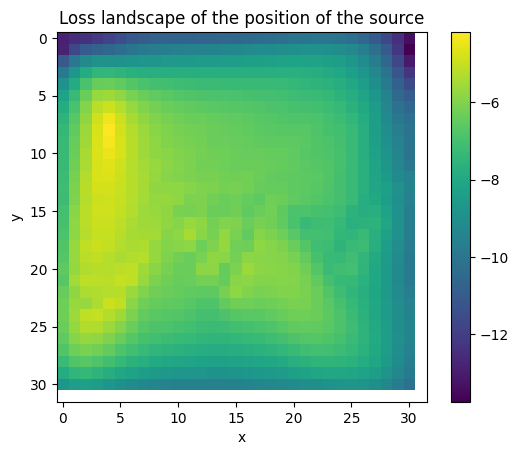

-4.1847134


In [20]:
plt.imshow(loss_landscape)
plt.colorbar()
plt.title("Loss landscape of the position of the source")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print(jnp.amax(loss_landscape))

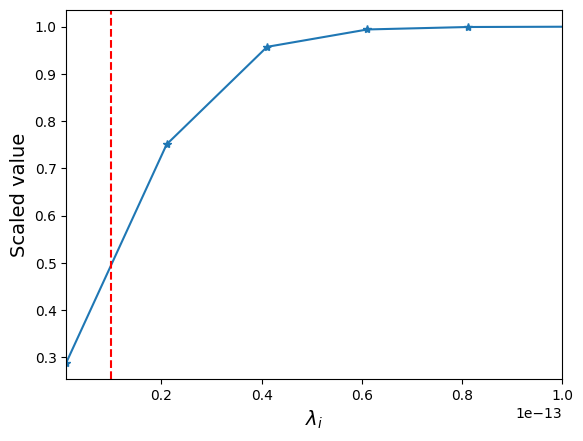

498.9903 instead of 499


In [49]:
threshold = 1e-14
x_list = np.linspace(1e-15, 1e-11, 500)
number_value_above_threshold_in_x_list = jnp.where(x_list > threshold, 1, 0).sum()
sig_output = []
exp_output = []
exp_mask = []
mask_sig= []

mask_sig = jax.nn.sigmoid(1e14 * (x_list - threshold))
# exp_mask.append(1 / (1 + np.exp(-5e12 * (x - threshold))))
    # sig_output.append(jnp.sum(x*mask_sig))
# mask = jax.nn.sigmoid(10 * (x - threshold))
plt.plot(x_list, mask_sig,"*-")
# plt.plot(x_list, exp_mask)
plt.xlim([1e-15, 1e-13])
plt.axvline(x=threshold, color='r', linestyle='--')
plt.xlabel(r"$\lambda_i$", fontsize=14)
plt.ylabel("Scaled value", fontsize=14)
plt.show()
print(jnp.sum(mask_sig), "instead of", number_value_above_threshold_in_x_list)

In [65]:
x_jnparray = jnp.array(x_list)
print(jnp.sum(jax.nn.sigmoid(8e12 * (x_jnparray - threshold))))

# hard thresholding
print(jnp.sum(x_jnparray > threshold))

450.04745
450


In [ ]:
# save the loss landscape to a file
# np.save("loss_landscape_64x32_nRER.npy", loss_landscape)


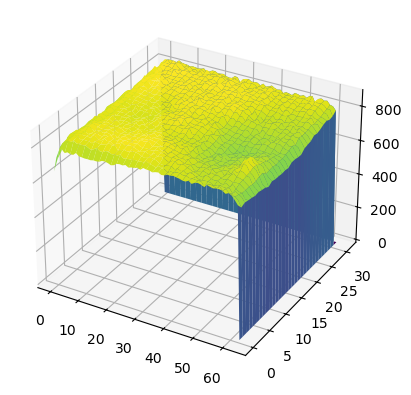

In [42]:
# plot the loss function as a surface in a 3d plot with color corresponding to the loss value
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, N[0], 1)
y = np.arange(0, N[1], 1)
X, Y = np.meshgrid(y, x)
Z = loss_landscape
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# make the figure interactive

import plotly.graph_objects as go
import numpy as np

# fig = go.Figure(data=[go.Surface(z=loss_landscape,cmin=800,cmax=880, colorscale='Viridis')])
# fig.update_layout(title='Loss landscape of the position of the source',
#                   autosize=True,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

# Calculate the aspect ratio
aspect_ratio = {
    "x": 2,
    "y": 1,
    "z": 0.5}

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=loss_landscape, cmin=800, cmax=880, colorscale='Viridis')])
fig.update_layout(
    title='Loss landscape of the position of the source',
    autosize=True,
    width=700,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        aspectratio=aspect_ratio,  # Set aspect ratio
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Loss',
        yaxis=dict(
            autorange="reversed"  # Flip the y-axis
        )
    )
)

fig.show()


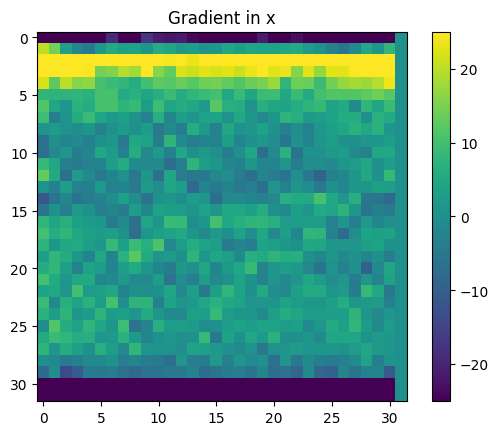

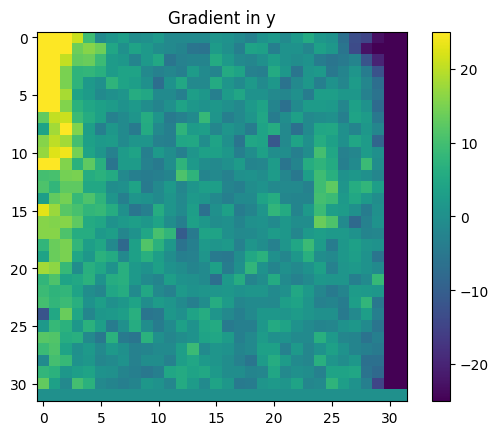

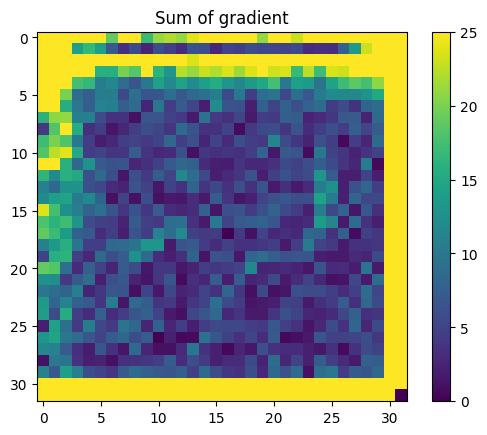

In [33]:
spatial_grad = jnp.gradient(loss_landscape)
plt.imshow(spatial_grad[0],vmin=-25,vmax=25)
plt.colorbar()
plt.title("Gradient in x")
plt.show()

plt.imshow(spatial_grad[1],vmin=-25,vmax=25)
plt.colorbar()
plt.title("Gradient in y")
plt.show()

# sum of gradient
sum_grad = jnp.sqrt(spatial_grad[0]**2 + spatial_grad[1]**2)
plt.imshow(sum_grad,vmin=0,vmax=25)
plt.colorbar()
plt.title("Sum of gradient")
plt.show()



### Test the optimisation problem parts

In [17]:
def loss_fn(fargs):
    objective = objective_function(fargs)
    return objective

In [18]:
# fargs = (jnp.array([[17.1, 10.1]]).astype(jnp.float32), receiver_coords)
loss_fn(fargs)

Array(349., dtype=float32)

In [19]:
def grad(fargs):
    "Computes gradient of loss function wrt fargs"
    partial = lambda fargs: loss_fn(fargs)
    return eqx.filter_value_and_grad(partial)(fargs)

In [20]:
# @eqx.filter_jit
def step(fargs, opt_state, opt_update):
    lossval, grads = grad(fargs)

    # Print gradients for debugging
    print("Gradients in step function:")
    def print_grads(grads):
        def print_leaf(x):
            if x is None:
                print("None")
            else:
                print(x)
        jax.tree_util.tree_map(print_leaf, grads)
    
    print_grads(grads)
    # grads = (-grads[0], -grads[1])
    updates, opt_state = opt_update(grads, opt_state)
    fargs = eqx.apply_updates(fargs, updates)
    
    # Define the domain boundaries (adjust as necessary)
    x_min, x_max = 0.1, sound_speed.shape[1] - 1.1
    y_min, y_max = 0.1, sound_speed.shape[0] - 1.1

    # Clip the positions of the sources and receivers with respect to the pml_size
    x_min, x_max = pml_size * dx[0]*0.1 + 1.1, sound_speed.shape[1] - (pml_size * dx[0]*0.1 + 1.1)
    y_min, y_max = pml_size * dx[1]*0.1 + 1.1, sound_speed.shape[0] - (pml_size * dx[1]*0.1 + 1.1)
    
    # Clip the positions of the sources and receivers
    fargs = (
        jnp.array([[jax.tree_util.tree_map(lambda x: jnp.clip(x, y_min, y_max), fargs[0][0][0]),
        jax.tree_util.tree_map(lambda x: jnp.clip(x, x_min, x_max), fargs[0][0][1])]]),
        jnp.array([[jax.tree_util.tree_map(lambda x: jnp.clip(x, y_min, y_max), fargs[1][1][0]),
        jax.tree_util.tree_map(lambda x: jnp.clip(x, x_min, x_max), fargs[1][1][1])]]) 
    )
    # replace the receriver coords by fix value
    fargs = (fargs[0], receiver_coords)
    
    return lossval, fargs, opt_state, grads



## Optimisation problem

In [26]:
fargs = (src_coord, receiver_coords)
# fargs = [src_coord]

optimiser = optax.adam(learning_rate=0.9)
opt_state = optimiser.init(eqx.filter(fargs, eqx.is_array))
opt_update = optimiser.update
n_steps = 200

print("Initial source and receiver coordinates:", fargs)
# print("Initial optimizer state:", opt_state)

Initial source and receiver coordinates: (Array([[16.01, 16.01]], dtype=float32), Array([[8.1, 4.1]], dtype=float32))


In [27]:
# print(fargs[0][0][0],fargs[0][0][1],fargs[1][1][0],fargs[1][1][1],sound_speed.shape[0])
# print(fargs)
# # Define the domain boundaries (adjust as necessary)
# x_min, x_max = 0.1, sound_speed.shape[1] - 1.1
# y_min, y_max = 0.1, sound_speed.shape[0] - 1.1
# print(x_min, x_max, y_min, y_max)

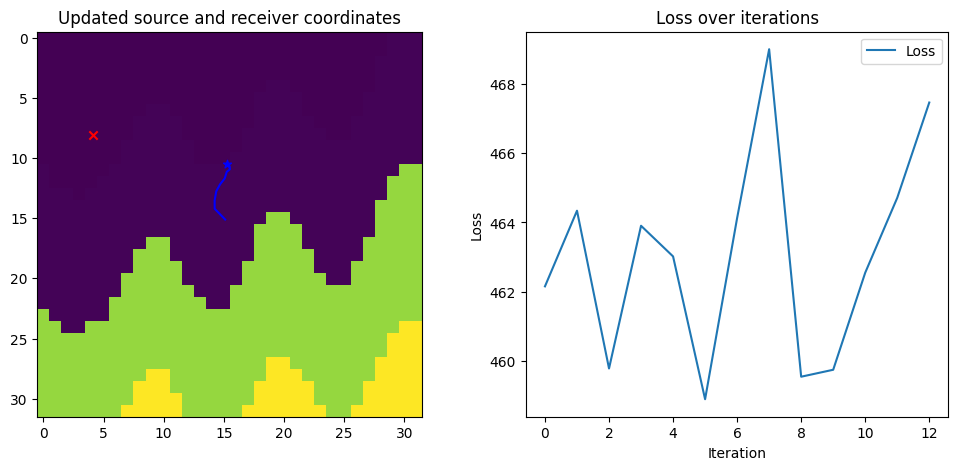

KeyboardInterrupt: 

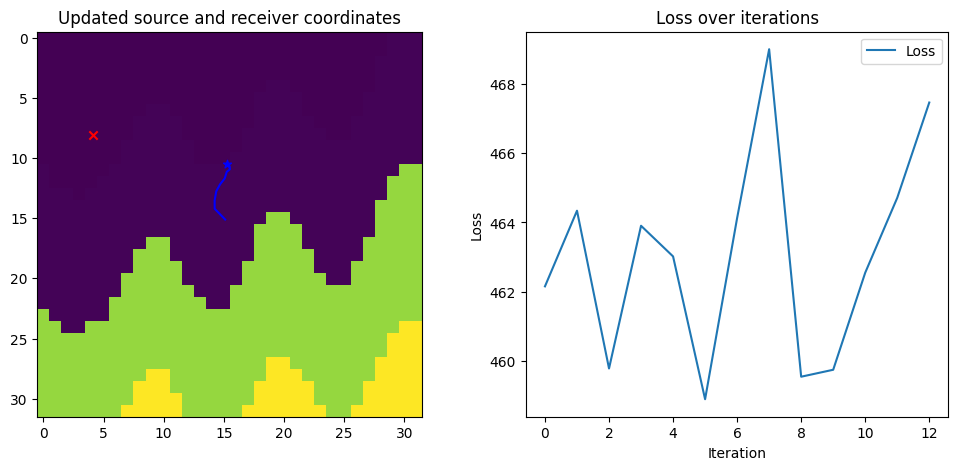

In [28]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time  # Optional, to simulate time between iterations

# Create the figure and two subplots outside the loop
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lossvals = []
source_trajectories = []
receiver_trajectories = []

for i in range(n_steps):
    tic = time.time()

    lossval, fargs, opt_state, grads = step(fargs, opt_state, opt_update)
    lossvals.append(lossval)
    tac = time.time()
    print(f"Step {i}, Loss: {lossval}, Time: {tac - tic}")

    # Record the current positions of sources and receivers
    source_trajectories.append((fargs[0][0][0], fargs[0][0][1]))  # Source
    receiver_trajectories.append((fargs[1][1][0], fargs[1][1][1]))  # Receiver
    # receiver_trajectories.append(receiver_coords[0],receiver_coords[1])  # Receiver

    # Clear the current axes, keeping the figure intact
    ax1.cla()
    ax2.cla()

    if i % 1 == 0:
        print(f"Step {i}, Loss: {lossval}")

        # Plot the sound speed on the first subplot
        im = ax1.imshow(sound_speed)
        ax1.set_title("Updated source and receiver coordinates")

        # Plot the trajectories of the sources and receivers
        source_positions = list(zip(*source_trajectories))
        receiver_positions = list(zip(*receiver_trajectories))
        ax1.plot(source_positions[1], source_positions[0], 'b-', label='Source Trajectory')
        ax1.plot(receiver_positions[1], receiver_positions[0], 'r-', label='Receiver Trajectory')

        # Plot the current positions of the source and receiver
        ax1.scatter(fargs[0][0][1], fargs[0][0][0], marker='*', color='blue', label='Current Source Position')
        # ax1.scatter(fargs[1][1][1], fargs[1][1][0], marker='x', color='red', label='Current Receiver Position')
        ax1.scatter(*receiver_coords.T[::-1], color='r', marker='x')
        # ax1.scatter(receiver_coords[1], receiver_coords[0], marker='o', color='blue', label='Current Receiver Position')

        print(fargs)

        # ax1.legend()

        # Plot the loss values over time on the second subplot
        ax2.plot(lossvals, label='Loss')
        ax2.set_title("Loss over iterations")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Loss")
        ax2.legend()
    
        # Update the plot display
        # clear_output(wait=True)
        # display(fig)
        # plt.savefig(f"opti_movie/step_{i}.png")

        # Force a draw before saving and displaying the figure
        fig.canvas.draw()

        # Save the figure after drawing everything
        # plt.savefig(f"opti_movie/step_{i}.png")

        # Clear the output, display the updated figure
        clear_output(wait=True)
        display(fig)

        # Pause to allow plot to refresh
        time.sleep(0.1)


        # plt.pause(0.01)  # Slight pause to allow plot to update
        # time.sleep(0.1)  # Optional, simulates time between iterations

# Show the final plot
plt.show()

print("Final Loss:", lossvals[-1])


In [389]:
from PIL import Image
import os

# Path to the folder containing the images
image_folder = 'opti_movie'
output_gif = 'opti_movie_normalize_trace.gif'

# Get all images from the folder, assuming they are named as 'step_#.png'
images = [img for img in os.listdir(image_folder) if img.startswith("step_") and img.endswith(".png")]
images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by the number after 'step_'

# Load all images into a list
frames = [Image.open(os.path.join(image_folder, img)) for img in images]

# Save as an animated GIF
frames[0].save(output_gif, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=250,  # 250ms between frames (adjust FPS here)
               loop=0)  # loop=0 means infinite loop

print(f"GIF saved as {output_gif}")

GIF saved as opti_movie_normalize_trace.gif


### Testing

In [ ]:

        # print(f"Epoch {epoch}, Loss: {loss}")
        
        # Create a directory to save the images
        # os.makedirs("video_frames_sol", exist_ok=True)
        # os.makedirs("video_frames_c", exist_ok=True)

        # sol = diffeqsolve(term_NN, solver, t0=t0, t1=t1, dt0=dt0, y0=y0, args=fargs, saveat=saveat)

        # x_perturbation, perturbation = fargs[-1](c)
        # print(jnp.abs(x_perturbation),jnp.abs(perturbation))
        # predicted_model = apply_perturbation(c,jnp.int32(jnp.abs(x_perturbation)),jnp.array(perturbation))
        # predicted_model = fargs[1](x) + c

        # clear_output(wait=True)
        # # # plt.plot(jnp.array(loss_list)/loss_list[0] * 100, label='Training Loss')
        # plt.plot(jnp.sqrt(jnp.array(lossvals)), label='Training Loss')
        # plt.legend()
        # plt.xlabel('# of epoch')
        # # plt.ylabel('Relative loss [%]')
        # plt.grid()
        # #plot the perturbed solution and the actual solution for the last time stamp and all position x
        # plt.figure(figsize=(12, 10))
        # plt.plot(perturbed_sol.ys[-1, :N], label='Perturbed Solution')
        # plt.plot(sol.ys[-1, :N], label='NN Solution')
        # plt.legend()
        # plt.xlabel('Position')
        # plt.ylabel('Displacement [u]')
        # plt.title('Displacement across Space at Different Times, it: '+str(i))
        # if i > 9:
        #     plt.savefig(f"video_frames_sol/frame_{i}.png")
        # else:
        #     plt.savefig(f"video_frames_sol/frame_0{i}.png")
        # plt.close()


        # # plot the velocity model and the perturbed model
        # plt.figure(figsize=(12, 10))
        # plt.plot(c_pertubed, label='True Model')
        # plt.plot(predicted_model, label='NN Model')
        # plt.legend()
        # plt.xlabel('Position')
        # plt.ylabel('Wave Speed [c]')
        # plt.title('Wave Speed Model, it: '+str(i))
        # if i > 9:
        #     plt.savefig(f"video_frames_c/frame_{i}.png")
        # else:
        #     plt.savefig(f"video_frames_c/frame_0{i}.png")
        # plt.close()
        
        # plt.show()

In [ ]:
# get the jacobians with respect to the velocity model
from jax import value_and_grad


# op_params = helmholtz.default_params(

# get the jacobian of the forward model
def loss(true_field, field):
    true_field = true_field.on_grid
    field = field.on_grid
    return -jnp.sum(jnp.abs(true_field - field)**2)

def full_loss(true_field, sound_speed):
    field = solve_helmholtz(sound_speed)
    return loss(true_field, field), field


loss_with_grad = value_and_grad(full_loss,argnums=-1, has_aux=True)



In [ ]:
print("Computing the loss")
sound_speed_inital = jnp.full(N, 1540.)
loss, gradi = loss_with_grad(true_field, sound_speed_inital)

Computing the loss


In [ ]:
print("Loss", gradi)


Loss [[ 0.02684357  0.03216845  0.1332474  ... -0.05871785  0.04511146
   0.05244172]
 [ 0.0450868   0.09623915  0.23160248 ... -0.03442792  0.03660486
   0.04906455]
 [ 0.08395869  0.16426441  0.23523873 ... -0.01172563  0.03060043
   0.05137262]
 ...
 [ 0.17436612  0.27413452 -0.04860255 ...  0.0043081   0.01156769
   0.05540644]
 [ 0.09349357  0.25266254  0.36247113 ... -0.08003248 -0.00426869
   0.03787444]
 [ 0.03687748  0.09084034  0.23646809 ... -0.08115152  0.0248914
   0.04615005]]


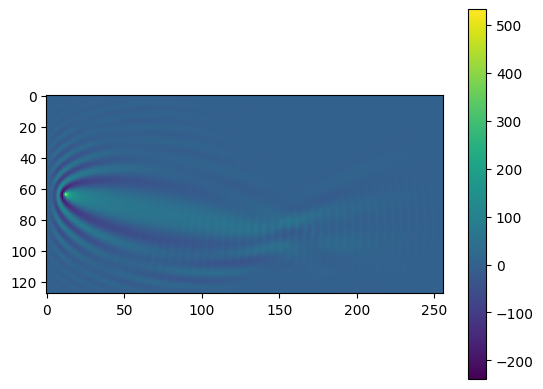

In [ ]:
plt.imshow(gradi)
plt.colorbar()
plt.show()


In [ ]:
initial_field = solve_helmholtz(init_medium.sound_speed)
residuals = true_field - initial_field
residuals_on = residuals.on_grid

In [ ]:
print(type(residuals_on[0,0]))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [ ]:
J = gradi / residuals_on.reshape(128,256)

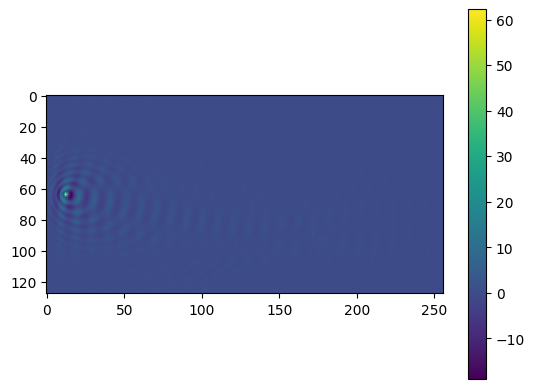

In [ ]:
plt.imshow(J.real)
plt.colorbar()
plt.show()


In [ ]:
loss_with_grad_forward = value_and_grad(solve_helmholtz_scalar, has_aux=True, allow_int=True)
loss_f, gradi_f = loss_with_grad_forward(sound_speed)

TypeError: expected function with aux output to return a two-element tuple, but got type <class 'jax._src.interpreters.ad.JVPTracer'> with value Traced<ConcreteArray([[[-0.10910499-1.1548681j ]
  [-0.3888571 -1.2867334j ]
  [-0.7027893 -1.4822493j ]
  ...
  [-1.9841386 -3.211408j  ]
  [-0.2125596 -2.3969924j ]
  [ 0.16278268-1.4496723j ]]

 [[-1.2198879 -1.376633j  ]
  [-1.7532628 -1.4382871j ]
  [-2.2651358 -1.5141718j ]
  ...
  [-3.0330172 -3.4178562j ]
  [-1.0876769 -2.7185106j ]
  [-0.72427326-1.7248514j ]]

 [[-3.5920928 -0.3049069j ]
  [-4.5748525 +0.07966302j]
  [-5.3688536 +0.49864933j]
  ...
  [-4.8273067 -2.7683647j ]
  [-2.8479533 -2.1999335j ]
  [-2.637147  -1.0153883j ]]

 ...

 [[-4.3620634 +2.6278965j ]
  [-5.3481417 +3.6059318j ]
  [-6.1076164 +4.568929j  ]
  ...
  [-4.176083  -0.6239043j ]
  [-3.085372  +0.13077357j]
  [-3.2633207 +1.4425541j ]]

 [[-2.5938587 -0.3665151j ]
  [-3.3716197 -0.20410621j]
  [-4.1070676 -0.01154773j]
  ...
  [-3.0804708 -2.345349j  ]
  [-1.8051245 -1.7022328j ]
  [-1.8162187 -0.80625266j]]

 [[-0.68795073-1.0968788j ]
  [-1.0862956 -1.214915j  ]
  [-1.5290341 -1.3629982j ]
  ...
  [-2.071736  -2.9384305j ]
  [-0.5434303 -2.2080631j ]
  [-0.30070853-1.356199j  ]]], dtype=complex64)>with<JVPTrace(level=2/0)> with
  primal = Array([[[-0.10910499-1.1548681j ],
        [-0.3888571 -1.2867334j ],
        [-0.7027893 -1.4822493j ],
        ...,
        [-1.9841386 -3.211408j  ],
        [-0.2125596 -2.3969924j ],
        [ 0.16278268-1.4496723j ]],

       [[-1.2198879 -1.376633j  ],
        [-1.7532628 -1.4382871j ],
        [-2.2651358 -1.5141718j ],
        ...,
        [-3.0330172 -3.4178562j ],
        [-1.0876769 -2.7185106j ],
        [-0.72427326-1.7248514j ]],

       [[-3.5920928 -0.3049069j ],
        [-4.5748525 +0.07966302j],
        [-5.3688536 +0.49864933j],
        ...,
        [-4.8273067 -2.7683647j ],
        [-2.8479533 -2.1999335j ],
        [-2.637147  -1.0153883j ]],

       ...,

       [[-4.3620634 +2.6278965j ],
        [-5.3481417 +3.6059318j ],
        [-6.1076164 +4.568929j  ],
        ...,
        [-4.176083  -0.6239043j ],
        [-3.085372  +0.13077357j],
        [-3.2633207 +1.4425541j ]],

       [[-2.5938587 -0.3665151j ],
        [-3.3716197 -0.20410621j],
        [-4.1070676 -0.01154773j],
        ...,
        [-3.0804708 -2.345349j  ],
        [-1.8051245 -1.7022328j ],
        [-1.8162187 -0.80625266j]],

       [[-0.68795073-1.0968788j ],
        [-1.0862956 -1.214915j  ],
        [-1.5290341 -1.3629982j ],
        ...,
        [-2.071736  -2.9384305j ],
        [-0.5434303 -2.2080631j ],
        [-0.30070853-1.356199j  ]]], dtype=complex64)
  tangent = Traced<ShapedArray(complex64[128,256,1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(complex64[128,256,1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x3564fc8d0>, in_tracers=(Traced<ShapedArray(float32[128,256], weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.          0.04908739  0.09817477  0.14726216  0.19634955  0.24543694
  0.2945243   0.34361172  0.3926991   0.44178647  0.49087387  0.5399613
  0.5890486   0.638136    0.68722343  0.7363108   0.7853982   0.8344856
  0.88357294  0.93266034  0.98174775  1.0308352   1.0799226   1.1290098
  1.1780972   1.2271847   1.276272    1.3253595   1.3744469   1.4235342
  1.4726216   1.521709    1.5707964   1.6198838   1.6689712   1.7180586
  1.7671459   1.8162333   1.8653207   1.9144081   1.9634955   2.0125828
  2.0616703   2.1107576   2.159845    2.2089324   2.2580197   2.3071072
  2.3561945   2.405282    2.4543693   2.5034568   2.552544    2.6016314
  2.650719    2.6998062   2.7488937   2.797981    2.8470683   2.8961558
  2.9452431   2.9943306   3.043418    3.0925055  -3.1415927  -3.0925055
 -3.043418   -2.9943306  -2.9452431  -2.8961558  -2.8470683  -2.797981
 -2.7488937  -2.6998062  -2.650719   -2.6016314  -2.552544   -2.5034568
 -2.4543693  -2.405282   -2.3561945  -2.3071072  -2.2580197  -2.2089324
 -2.159845   -2.1107576  -2.0616703  -2.0125828  -1.9634955  -1.9144081
 -1.8653207  -1.8162333  -1.7671459  -1.7180586  -1.6689712  -1.6198838
 -1.5707964  -1.521709   -1.4726216  -1.4235342  -1.3744469  -1.3253595
 -1.276272   -1.2271847  -1.1780972  -1.1290098  -1.0799226  -1.0308352
 -0.98174775 -0.93266034 -0.88357294 -0.8344856  -0.7853982  -0.7363108
 -0.68722343 -0.638136   -0.5890486  -0.5399613  -0.49087387 -0.44178647
 -0.3926991  -0.34361172 -0.2945243  -0.24543694 -0.19634955 -0.14726216
 -0.09817477 -0.04908739], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.          0.02454369  0.04908739  0.07363108  0.09817477  0.12271847
  0.14726216  0.17180586  0.19634955  0.22089323  0.24543694  0.26998064
  0.2945243   0.319068    0.34361172  0.3681554   0.3926991   0.4172428
  0.44178647  0.46633017  0.49087387  0.5154176   0.5399613   0.5645049
  0.5890486   0.6135923   0.638136    0.66267973  0.68722343  0.7117671
  0.7363108   0.7608545   0.7853982   0.8099419   0.8344856   0.8590293
  0.88357294  0.90811664  0.93266034  0.95720404  0.98174775  1.0062914
  1.0308352   1.0553788   1.0799226   1.1044662   1.1290098   1.1535536
  1.1780972   1.202641    1.2271847   1.2517284   1.276272    1.3008157
  1.3253595   1.3499031   1.3744469   1.3989905   1.4235342   1.4480779
  1.4726216   1.4971653   1.521709    1.5462527   1.5707964   1.59534
  1.6198838   1.6444274   1.6689712   1.6935148   1.7180586   1.7426022
  1.7671459   1.7916896   1.8162333   1.840777    1.8653207   1.8898643
  1.9144081   1.9389517   1.9634955   1.9880391   2.0125828   2.0371265
  2.0616703   2.0862138   2.1107576   2.1353014   2.159845    2.1843886
  2.2089324   2.2334762   2.2580197   2.2825634   2.3071072   2.331651
  2.3561945   2.3807383   2.405282    2.4298255   2.4543693   2.478913
  2.5034568   2.5280004   2.552544    2.5770879   2.6016314   2.6261752
  2.650719    2.6752625   2.6998062   2.72435     2.7488937   2.7734373
  2.797981    2.8225248   2.8470683   2.871612    2.8961558   2.9206996
  2.9452431   2.969787    2.9943306   3.0188742   3.043418    3.0679617
  3.0925055   3.117049   -3.1415927  -3.117049   -3.0925055  -3.0679617
 -3.043418   -3.0188742  -2.9943306  -2.969787   -2.9452431  -2.9206996
 -2.8961558  -2.871612   -2.8470683  -2.8225248  -2.797981   -2.7734373
 -2.7488937  -2.72435    -2.6998062  -2.6752625  -2.650719   -2.6261752
 -2.6016314  -2.5770879  -2.552544   -2.5280004  -2.5034568  -2.478913
 -2.4543693  -2.4298255  -2.405282   -2.3807383  -2.3561945  -2.331651
 -2.3071072  -2.2825634  -2.2580197  -2.2334762  -2.2089324  -2.1843886
 -2.159845   -2.1353014  -2.1107576  -2.0862138  -2.0616703  -2.0371265
 -2.0125828  -1.9880391  -1.9634955  -1.9389517  -1.9144081  -1.8898643
 -1.8653207  -1.840777   -1.8162333  -1.7916896  -1.7671459  -1.7426022
 -1.7180586  -1.6935148  -1.6689712  -1.6444274  -1.6198838  -1.59534
 -1.5707964  -1.5462527  -1.521709   -1.4971653  -1.4726216  -1.4480779
 -1.4235342  -1.3989905  -1.3744469  -1.3499031  -1.3253595  -1.3008157
 -1.276272   -1.2517284  -1.2271847  -1.202641   -1.1780972  -1.1535536
 -1.1290098  -1.1044662  -1.0799226  -1.0553788  -1.0308352  -1.0062914
 -0.98174775 -0.95720404 -0.93266034 -0.90811664 -0.88357294 -0.8590293
 -0.8344856  -0.8099419  -0.7853982  -0.7608545  -0.7363108  -0.7117671
 -0.68722343 -0.66267973 -0.638136   -0.6135923  -0.5890486  -0.5645049
 -0.5399613  -0.5154176  -0.49087387 -0.46633017 -0.44178647 -0.4172428
 -0.3926991  -0.3681554  -0.34361172 -0.319068   -0.2945243  -0.26998064
 -0.24543694 -0.22089323 -0.19634955 -0.17180586 -0.14726216 -0.12271847
 -0.09817477 -0.07363108 -0.04908739 -0.02454369], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.59841216-0.4902194j ]
  ...
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.2       -0.4j       ]]

 [[0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.59841216-0.4902194j ]
  ...
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.2       -0.4j       ]]

 [[0.59841216-0.4902194j  0.30272567-0.45943752j]
  [0.59841216-0.4902194j  0.4399196 -0.4963772j ]
  [0.59841216-0.4902194j  0.59841216-0.4902194j ]
  ...
  [0.59841216-0.4902194j  0.4399196 -0.4963772j ]
  [0.59841216-0.4902194j  0.30272567-0.45943752j]
  [0.59841216-0.4902194j  0.2       -0.4j       ]]

 ...

 [[0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.59841216-0.4902194j ]
  ...
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.2       -0.4j       ]]

 [[0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.59841216-0.4902194j ]
  ...
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.2       -0.4j       ]]

 [[0.2       -0.4j        0.30272567-0.45943752j]
  [0.2       -0.4j        0.4399196 -0.4963772j ]
  [0.2       -0.4j        0.59841216-0.4902194j ]
  ...
  [0.2       -0.4j        0.4399196 -0.4963772j ]
  [0.2       -0.4j        0.30272567-0.45943752j]
  [0.2       -0.4j        0.2       -0.4j       ]]], dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[0.2       -0.4j        0.2       -0.4j       ]
  [0.2       -0.4j        0.30272567-0.45943752j]
  [0.2       -0.4j        0.4399196 -0.4963772j ]
  ...
  [0.2       -0.4j        0.59841216-0.4902194j ]
  [0.2       -0.4j        0.4399196 -0.4963772j ]
  [0.2       -0.4j        0.30272567-0.45943752j]]

 [[0.30272567-0.45943752j 0.2       -0.4j       ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  ...
  [0.30272567-0.45943752j 0.59841216-0.4902194j ]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]]

 [[0.4399196 -0.4963772j  0.2       -0.4j       ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  ...
  [0.4399196 -0.4963772j  0.59841216-0.4902194j ]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]]

 ...

 [[0.59841216-0.4902194j  0.2       -0.4j       ]
  [0.59841216-0.4902194j  0.30272567-0.45943752j]
  [0.59841216-0.4902194j  0.4399196 -0.4963772j ]
  ...
  [0.59841216-0.4902194j  0.59841216-0.4902194j ]
  [0.59841216-0.4902194j  0.4399196 -0.4963772j ]
  [0.59841216-0.4902194j  0.30272567-0.45943752j]]

 [[0.4399196 -0.4963772j  0.2       -0.4j       ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  ...
  [0.4399196 -0.4963772j  0.59841216-0.4902194j ]
  [0.4399196 -0.4963772j  0.4399196 -0.4963772j ]
  [0.4399196 -0.4963772j  0.30272567-0.45943752j]]

 [[0.30272567-0.45943752j 0.2       -0.4j       ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  ...
  [0.30272567-0.45943752j 0.59841216-0.4902194j ]
  [0.30272567-0.45943752j 0.4399196 -0.4963772j ]
  [0.30272567-0.45943752j 0.30272567-0.45943752j]]], dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]

 [[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]

 [[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]

 ...

 [[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]

 [[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]

 [[1540.]
  [1540.]
  [1540.]
  ...
  [1540.]
  [1540.]
  [1540.]]], dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]], dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.001223997212946415, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(31518.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]], dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray((4.2165626723544847e-07+0j), dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[[ 1.2253531e-03-0.00011576j]
  [ 1.3652665e-03-0.00041259j]
  [ 1.5727154e-03-0.00074568j]
  ...
  [ 3.4074096e-03-0.00210524j]
  [ 2.5432881e-03-0.00022553j]
  [ 1.5381501e-03+0.00017272j]]

 [[ 1.4606530e-03-0.00129434j]
  [ 1.5260701e-03-0.00186027j]
  [ 1.6065863e-03-0.00240338j]
  ...
  [ 3.6264581e-03-0.00321813j]
  [ 2.8844294e-03-0.00115406j]
  [ 1.8301242e-03-0.00076848j]]

 [[ 3.2351629e-04-0.00381133j]
  [-8.4525098e-05-0.00485407j]
  [-5.2908337e-04-0.00569653j]
  ...
  [ 2.9373262e-03-0.00512193j]
  [ 2.3342019e-03-0.00302177j]
  [ 1.0773604e-03-0.0027981j ]]

 ...

 [[-2.7882848e-03-0.00462829j]
  [-3.8260126e-03-0.00567455j]
  [-4.8477845e-03-0.00648038j]
  ...
  [ 6.6198304e-04-0.00443096j]
  [-1.3875507e-04-0.00327368j]
  [-1.5305975e-03-0.00346249j]]

 [[ 3.8888460e-04-0.00275217j]
  [ 2.1656342e-04-0.0035774j ]
  [ 1.2252519e-05-0.00435773j]
  ...
  [ 2.4884928e-03-0.00326848j]
  [ 1.8061252e-03-0.0019153j ]
  [ 8.5546065e-04-0.00192707j]]

 [[ 1.1638246e-03-0.00072994j]
  [ 1.2890649e-03-0.0011526j ]
  [ 1.4461861e-03-0.00162236j]
  ...
  [ 3.1177716e-03-0.00219818j]
  [ 2.3428279e-03-0.0005766j ]
  [ 1.4389718e-03-0.00031906j]]], dtype=complex64):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x352ad13f0; to 'JaxprTracer' at 0x352ad14a0>], out_avals=[ShapedArray(complex64[128,256,1])], primitive=pjit, params={'jaxpr': let jaxpr = { lambda ; a:f32[128] b:f32[256] c:c64[128,256,2] d:c64[128,256,2] e:f32[128,256,1]
    f:c64[128,256,1]. let
    g:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    h:c64[128] = mul 1j g
    i:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    j:c64[128] = mul 1j i
    k:c64[128] = mul j (0.5+0j)
    l:c64[128] = mul k (1+0j)
    m:c64[128] = exp l
    n:c64[128] = mul h m
    o:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    p:c64[256] = mul 1j o
    q:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    r:c64[256] = mul 1j q
    s:c64[256] = mul r (0.5+0j)
    t:c64[256] = mul s (1+0j)
    u:c64[256] = exp t
    v:c64[256] = mul p u
    w:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] f
    x:c64[128,256] = squeeze[dimensions=(2,)] w
    y:c64[256,128] = transpose[permutation=(1, 0)] x
    z:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ba:c64[256,128]. let
          bb:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ba
        in (bb,) }
    ] y
    bc:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] n
    bd:c64[256,128] = mul z bc
    be:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; bf:c64[256,128] bg:i32[]. let
          bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
          bi:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bh
          bj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bi
          bk:c64[] = squeeze[dimensions=(0, 1)] bj
          bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
          bm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bi
          bn:c64[] = squeeze[dimensions=(0, 1)] bm
          bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
          bp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bi
          bq:c64[] = squeeze[dimensions=(0, 1)] bp
          br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
          bs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bi
          bt:c64[] = squeeze[dimensions=(0, 1)] bs
          bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
        in (bu,) }
    ] bd 0
    bv:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; bw:c64[256,128]. let
          bx:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] bw
        in (bx,) }
    ] be
    by:c64[128,256] = transpose[permutation=(1, 0)] bv
    bz:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; ca:c64[128,256]. let
          cb:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ca
        in (cb,) }
    ] x
    cc:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] v
    cd:c64[128,256] = mul bz cc
    ce:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; cf:c64[128,256] cg:i32[]. let
          ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
          ci:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ch
          cj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] ci
          ck:c64[] = squeeze[dimensions=(0, 1)] cj
          cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
          cm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] ci
          cn:c64[] = squeeze[dimensions=(0, 1)] cm
          co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
          cp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] ci
          cq:c64[] = squeeze[dimensions=(0, 1)] cp
          cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
          cs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] ci
          ct:c64[] = squeeze[dimensions=(0, 1)] cs
          cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
        in (cu,) }
    ] cd 0
    cv:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; cw:c64[128,256]. let
          cx:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] cw
        in (cx,) }
    ] ce
    cy:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] by
    cz:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] cv
    da:c64[128,256,2] = concatenate[dimension=2] cy cz
    db:c64[128,256,2] = mul da c
    dc:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    dd:c64[128] = mul 1j dc
    de:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    df:c64[128] = mul 1j de
    dg:c64[128] = mul df (-0.5+0j)
    dh:c64[128] = mul dg (1+0j)
    di:c64[128] = exp dh
    dj:c64[128] = mul dd di
    dk:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    dl:c64[256] = mul 1j dk
    dm:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    dn:c64[256] = mul 1j dm
    do:c64[256] = mul dn (-0.5+0j)
    dp:c64[256] = mul do (1+0j)
    dq:c64[256] = exp dp
    dr:c64[256] = mul dl dq
    ds:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 2)
    ] 0j
    dt:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] db
    du:c64[128,256] = squeeze[dimensions=(2,)] dt
    dv:c64[256,128] = transpose[permutation=(1, 0)] du
    dw:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ba:c64[256,128]. let
          bb:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ba
        in (bb,) }
    ] dv
    dx:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] dj
    dy:c64[256,128] = mul dw dx
    dz:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; bf:c64[256,128] bg:i32[]. let
          bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
          bi:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bh
          bj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bi
          bk:c64[] = squeeze[dimensions=(0, 1)] bj
          bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
          bm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bi
          bn:c64[] = squeeze[dimensions=(0, 1)] bm
          bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
          bp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bi
          bq:c64[] = squeeze[dimensions=(0, 1)] bp
          br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
          bs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bi
          bt:c64[] = squeeze[dimensions=(0, 1)] bs
          bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
        in (bu,) }
    ] dy 0
    ea:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; bw:c64[256,128]. let
          bx:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] bw
        in (bx,) }
    ] dz
    eb:c64[128,256] = transpose[permutation=(1, 0)] ea
    ec:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    ed:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] ds ec eb
    ee:c64[128,256,1] = slice[
      limit_indices=(128, 256, 2)
      start_indices=(0, 0, 1)
      strides=None
    ] db
    ef:c64[128,256] = squeeze[dimensions=(2,)] ee
    eg:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; ca:c64[128,256]. let
          cb:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ca
        in (cb,) }
    ] ef
    eh:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] dr
    ei:c64[128,256] = mul eg eh
    ej:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; cf:c64[128,256] cg:i32[]. let
          ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
          ci:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ch
          cj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] ci
          ck:c64[] = squeeze[dimensions=(0, 1)] cj
          cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
          cm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] ci
          cn:c64[] = squeeze[dimensions=(0, 1)] cm
          co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
          cp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] ci
          cq:c64[] = squeeze[dimensions=(0, 1)] cp
          cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
          cs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] ci
          ct:c64[] = squeeze[dimensions=(0, 1)] cs
          cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
        in (cu,) }
    ] ei 0
    ek:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; cw:c64[128,256]. let
          cx:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] cw
        in (cx,) }
    ] ej
    el:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
    em:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] ed el ek
    en:c64[128,256,2] = mul em d
    eo:c64[128,256] = reduce_sum[axes=(2,)] en
    ep:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] eo
    eq:c64[128,256,1] = sub ep 0j
    er:f32[128,256,1] = div 942.4777960769379 e
    es:f32[128,256,1] = integer_pow[y=2] er
    et:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] e
    eu:c64[128,256,1] = div 0.0004882804478380437j et
    ev:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] es
    ew:c64[128,256,1] = add ev eu
    ex:c64[128,256,1] = convert_element_type[
      new_dtype=complex64
      weak_type=False
    ] ew
    ey:c64[128,256,1] = mul f ex
    ez:c64[128,256,1] = add eq ey
  in (ez,) } in
let jaxpr1 = { lambda ; fa:f32[128] fb:f32[256] fc:c64[128,256,2] fd:c64[128,256,2]
    fe:f32[128,256,1] ff:c64[128,256,1]. let
    fg:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] fa
    fh:c64[128] = mul 1j fg
    fi:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] fa
    fj:c64[128] = mul 1j fi
    fk:c64[128] = mul fj (0.5+0j)
    fl:c64[128] = mul fk (1+0j)
    fm:c64[128] = exp fl
    fn:c64[128] = mul fh fm
    fo:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] fb
    fp:c64[256] = mul 1j fo
    fq:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] fb
    fr:c64[256] = mul 1j fq
    fs:c64[256] = mul fr (0.5+0j)
    ft:c64[256] = mul fs (1+0j)
    fu:c64[256] = exp ft
    fv:c64[256] = mul fp fu
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    fw:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] fn
    fx:c64[] fy:c64[] fz:c64[] ga:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; gb:i32[]. let
          gc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gb
          gd:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] gc
          ge:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] gd
          gf:c64[] = squeeze[dimensions=(0, 1)] ge
          gg:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] gd
          gh:c64[] = squeeze[dimensions=(0, 1)] gg
          gi:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] gd
          gj:c64[] = squeeze[dimensions=(0, 1)] gi
          gk:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] gd
          gl:c64[] = squeeze[dimensions=(0, 1)] gk
        in (gf, gh, gj, gl) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    gm:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] fv
    gn:c64[] go:c64[] gp:c64[] gq:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; gr:i32[]. let
          gs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gr
          gt:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] gs
          gu:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] gt
          gv:c64[] = squeeze[dimensions=(0, 1)] gu
          gw:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] gt
          gx:c64[] = squeeze[dimensions=(0, 1)] gw
          gy:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] gt
          gz:c64[] = squeeze[dimensions=(0, 1)] gy
          ha:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] gt
          hb:c64[] = squeeze[dimensions=(0, 1)] ha
        in (gv, gx, gz, hb) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    hc:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] fa
    hd:c64[128] = mul 1j hc
    he:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] fa
    hf:c64[128] = mul 1j he
    hg:c64[128] = mul hf (-0.5+0j)
    hh:c64[128] = mul hg (1+0j)
    hi:c64[128] = exp hh
    hj:c64[128] = mul hd hi
    hk:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] fb
    hl:c64[256] = mul 1j hk
    hm:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] fb
    hn:c64[256] = mul 1j hm
    ho:c64[256] = mul hn (-0.5+0j)
    hp:c64[256] = mul ho (1+0j)
    hq:c64[256] = exp hp
    hr:c64[256] = mul hl hq
    _:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 2)
    ] 0j
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    hs:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] hj
    ht:c64[] hu:c64[] hv:c64[] hw:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; gb:i32[]. let
          gc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gb
          gd:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] gc
          ge:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] gd
          gf:c64[] = squeeze[dimensions=(0, 1)] ge
          gg:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] gd
          gh:c64[] = squeeze[dimensions=(0, 1)] gg
          gi:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] gd
          gj:c64[] = squeeze[dimensions=(0, 1)] gi
          gk:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] gd
          gl:c64[] = squeeze[dimensions=(0, 1)] gk
        in (gf, gh, gj, gl) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    hx:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    hy:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] hr
    hz:c64[] ia:c64[] ib:c64[] ic:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; gr:i32[]. let
          gs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gr
          gt:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] gs
          gu:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] gt
          gv:c64[] = squeeze[dimensions=(0, 1)] gu
          gw:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] gt
          gx:c64[] = squeeze[dimensions=(0, 1)] gw
          gy:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] gt
          gz:c64[] = squeeze[dimensions=(0, 1)] gy
          ha:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] gt
          hb:c64[] = squeeze[dimensions=(0, 1)] ha
        in (gv, gx, gz, hb) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    id:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
    ie:f32[128,256,1] = div 942.4777960769379 fe
    if:f32[128,256,1] = integer_pow[y=2] ie
    ig:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] fe
    ih:c64[128,256,1] = div 0.0004882804478380437j ig
    ii:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] if
    ij:c64[128,256,1] = add ii ih
    ik:c64[128,256,1] = convert_element_type[
      new_dtype=complex64
      weak_type=False
    ] ij
    il:c64[128,256,1] = mul ff ik
    im:c64[128,256,1] = neg ff
    _:c64[] = reduce_sum[axes=(0, 1, 2)] im
    in:c64[128,256] = reduce_sum[axes=(2,)] ff
    io:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 2)
    ] in
    ip:c64[128,256,2] = mul io fd
    iq:c64[128,256] = broadcast_in_dim[broadcast_dimensions=() shape=(128, 256)] 0j
    ir:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] ip id iq
    is:c64[128,256] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
      fill_value=0
      indices_are_sorted=False
      mode=GatherScatterMode.FILL_OR_DROP
      slice_sizes=(128, 256, 1)
      unique_indices=False
    ] ip id
    it:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; iu:c64[128,256]. let
          iv:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; cw:c64[128,256]. let
                cx:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] cw
              in (cx,) }
          ] iu
        in (iv,) }
    ] is
    iw:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; ix:c64[] iy:c64[] iz:c64[] ja:c64[] jb:c64[128,256]. let
          jc:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jb 0j
          jd:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] jc
          je:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jd 0j
          jf:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] je
          jg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jf 0j
          jh:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] jg
          ji:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jh 0j
          jj:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ji
        in (jj,) }
    ] hz ia ib ic it
    jk:c64[128,256] = mul iw hy
    jl:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; jm:c64[128,256]. let
          jn:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; ca:c64[128,256]. let
                cb:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ca
              in (cb,) }
          ] jm
        in (jn,) }
    ] jk
    jo:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] jl
    jp:c64[128,256,2] = pad[padding_config=((0, 0, 0), (0, 0, 0), (1, 0, 0))] jo
      0j
    jq:c64[128,256] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
      fill_value=0
      indices_are_sorted=False
      mode=GatherScatterMode.FILL_OR_DROP
      slice_sizes=(128, 256, 1)
      unique_indices=False
    ] ir hx
    jr:c64[256,128] = transpose[permutation=(1, 0)] jq
    js:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; jt:c64[256,128]. let
          ju:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; bw:c64[256,128]. let
                bx:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] bw
              in (bx,) }
          ] jt
        in (ju,) }
    ] jr
    jv:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; jw:c64[] jx:c64[] jy:c64[] jz:c64[] ka:c64[256,128]. let
          kb:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ka 0j
          kc:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kb
          kd:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kc 0j
          ke:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kd
          kf:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ke 0j
          kg:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kf
          kh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kg 0j
          ki:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kh
        in (ki,) }
    ] ht hu hv hw js
    kj:c64[256,128] = mul jv hs
    kk:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; kl:c64[256,128]. let
          km:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ba:c64[256,128]. let
                bb:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ba
              in (bb,) }
          ] kl
        in (km,) }
    ] kj
    kn:c64[128,256] = transpose[permutation=(1, 0)] kk
    ko:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] kn
    kp:c64[128,256,2] = pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 1, 0))] ko
      0j
    kq:c64[128,256,2] = add_any jp kp
    kr:c64[128,256,2] = mul kq fc
    ks:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] kr
    kt:c64[128,256,1] = slice[
      limit_indices=(128, 256, 2)
      start_indices=(0, 0, 1)
      strides=None
    ] kr
    ku:c64[128,256] = reduce_sum[axes=(2,)] kt
    kv:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; iu:c64[128,256]. let
          iv:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; cw:c64[128,256]. let
                cx:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] cw
              in (cx,) }
          ] iu
        in (iv,) }
    ] ku
    kw:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; ix:c64[] iy:c64[] iz:c64[] ja:c64[] jb:c64[128,256]. let
          jc:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jb 0j
          jd:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] jc
          je:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jd 0j
          jf:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] je
          jg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jf 0j
          jh:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] jg
          ji:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jh 0j
          jj:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ji
        in (jj,) }
    ] gn go gp gq kv
    kx:c64[128,256] = mul kw gm
    ky:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; jm:c64[128,256]. let
          jn:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; ca:c64[128,256]. let
                cb:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ca
              in (cb,) }
          ] jm
        in (jn,) }
    ] kx
    kz:c64[128,256] = reduce_sum[axes=(2,)] ks
    la:c64[256,128] = transpose[permutation=(1, 0)] kz
    lb:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; jt:c64[256,128]. let
          ju:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; bw:c64[256,128]. let
                bx:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] bw
              in (bx,) }
          ] jt
        in (ju,) }
    ] la
    lc:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; jw:c64[] jx:c64[] jy:c64[] jz:c64[] ka:c64[256,128]. let
          kb:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ka 0j
          kc:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kb
          kd:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kc 0j
          ke:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kd
          kf:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ke 0j
          kg:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kf
          kh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kg 0j
          ki:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] kh
        in (ki,) }
    ] fx fy fz ga lb
    ld:c64[256,128] = mul lc fw
    le:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; kl:c64[256,128]. let
          km:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ba:c64[256,128]. let
                bb:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ba
              in (bb,) }
          ] kl
        in (km,) }
    ] ld
    lf:c64[128,256] = transpose[permutation=(1, 0)] le
    lg:c64[128,256] = add_any ky lf
    lh:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] lg
    li:c64[128,256,1] = pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0))] lh
      0j
    lj:c64[128,256,1] = add_any il li
  in (lj,) } in
let _where = { lambda ; lk:bool[] ll:c64[128,256,1] lm:f32[]. let
    ln:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] lm
    lo:bool[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] lk
    lp:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] ln
    lq:c64[128,256,1] = select_n lo lp ll
  in (lq,) } in
let _where1 = { lambda ; lr:bool[] ls:f32[] lt:f32[]. let
    lu:f32[] = convert_element_type[new_dtype=float32 weak_type=False] lt
    lv:f32[] = select_n lr lu ls
  in (lv,) } in
let fft = { lambda ; ba:c64[256,128]. let
    bb:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ba
  in (bb,) } in
let _pad = { lambda ; bf:c64[256,128] bg:i32[]. let
    bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
    bi:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] bh
    bj:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] bi
    bk:c64[] = squeeze[dimensions=(0, 1)] bj
    bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
    bm:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] bi
    bn:c64[] = squeeze[dimensions=(0, 1)] bm
    bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
    bp:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] bi
    bq:c64[] = squeeze[dimensions=(0, 1)] bp
    br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
    bs:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] bi
    bt:c64[] = squeeze[dimensions=(0, 1)] bs
    bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
  in (bu,) } in
let fft1 = { lambda ; bw:c64[256,128]. let
    bx:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] bw
  in (bx,) } in
let fft2 = { lambda ; ca:c64[128,256]. let
    cb:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ca
  in (cb,) } in
let _pad1 = { lambda ; cf:c64[128,256] cg:i32[]. let
    ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
    ci:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] ch
    cj:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] ci
    ck:c64[] = squeeze[dimensions=(0, 1)] cj
    cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
    cm:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] ci
    cn:c64[] = squeeze[dimensions=(0, 1)] cm
    co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
    cp:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] ci
    cq:c64[] = squeeze[dimensions=(0, 1)] cp
    cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
    cs:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] ci
    ct:c64[] = squeeze[dimensions=(0, 1)] cs
    cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
  in (cu,) } in
let fft3 = { lambda ; cw:c64[128,256]. let
    cx:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] cw
  in (cx,) } in
let fft4 = { lambda ; . let  in () } in
let _pad2 = { lambda ; gb:i32[]. let
    gc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gb
    gd:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] gc
    ge:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] gd
    gf:c64[] = squeeze[dimensions=(0, 1)] ge
    gg:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] gd
    gh:c64[] = squeeze[dimensions=(0, 1)] gg
    gi:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] gd
    gj:c64[] = squeeze[dimensions=(0, 1)] gi
    gk:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] gd
    gl:c64[] = squeeze[dimensions=(0, 1)] gk
  in (gf, gh, gj, gl) } in
let fft5 = { lambda ; . let  in () } in
let fft6 = { lambda ; . let  in () } in
let _pad3 = { lambda ; gr:i32[]. let
    gs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] gr
    gt:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] gs
    gu:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] gt
    gv:c64[] = squeeze[dimensions=(0, 1)] gu
    gw:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] gt
    gx:c64[] = squeeze[dimensions=(0, 1)] gw
    gy:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] gt
    gz:c64[] = squeeze[dimensions=(0, 1)] gy
    ha:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] gt
    hb:c64[] = squeeze[dimensions=(0, 1)] ha
  in (gv, gx, gz, hb) } in
let fft7 = { lambda ; . let  in () } in
let fft8 = { lambda ; iu:c64[128,256]. let
    iv:c64[128,256] = pjit[name=fft jaxpr=fft3] iu
  in (iv,) } in
let _pad4 = { lambda ; ix:c64[] iy:c64[] iz:c64[] ja:c64[] jb:c64[128,256]. let
    jc:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jb 0j
    jd:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] jc
    je:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jd 0j
    jf:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] je
    jg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jf 0j
    jh:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] jg
    ji:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] jh 0j
    jj:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ji
  in (jj,) } in
let fft9 = { lambda ; jm:c64[128,256]. let
    jn:c64[128,256] = pjit[name=fft jaxpr=fft2] jm
  in (jn,) } in
let fft10 = { lambda ; jt:c64[256,128]. let
    ju:c64[256,128] = pjit[name=fft jaxpr=fft1] jt
  in (ju,) } in
let _pad5 = { lambda ; jw:c64[] jx:c64[] jy:c64[] jz:c64[] ka:c64[256,128]. let
    kb:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ka 0j
    kc:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] kb
    kd:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kc 0j
    ke:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] kd
    kf:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ke 0j
    kg:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] kf
    kh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] kg 0j
    ki:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] kh
  in (ki,) } in
let fft11 = { lambda ; kl:c64[256,128]. let
    km:c64[256,128] = pjit[name=fft jaxpr=fft] kl
  in (km,) } in
let _pad6 = { lambda ; lw:c64[128,256,1,1] lx:i32[]. let
    ly:i32[4,2] = broadcast_in_dim[broadcast_dimensions=() shape=(4, 2)] lx
    lz:c64[4,2] = convert_element_type[new_dtype=complex64 weak_type=False] ly
    ma:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] lz
    mb:c64[] = squeeze[dimensions=(0, 1)] ma
    mc:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] lw mb
    md:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] lz
    me:c64[] = squeeze[dimensions=(0, 1)] md
    mf:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] mc me
    mg:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] lz
    mh:c64[] = squeeze[dimensions=(0, 1)] mg
    mi:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] mf mh
    mj:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] lz
    mk:c64[] = squeeze[dimensions=(0, 1)] mj
    ml:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] mi mk
    mm:c64[1,1] = slice[limit_indices=(3, 1) start_indices=(2, 0) strides=None] lz
    mn:c64[] = squeeze[dimensions=(0, 1)] mm
    mo:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] ml mn
    mp:c64[1,1] = slice[limit_indices=(3, 2) start_indices=(2, 1) strides=None] lz
    mq:c64[] = squeeze[dimensions=(0, 1)] mp
    mr:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] mo mq
    ms:c64[1,1] = slice[limit_indices=(4, 1) start_indices=(3, 0) strides=None] lz
    mt:c64[] = squeeze[dimensions=(0, 1)] ms
    mu:c64[128,256,1,1] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
    ] mr mt
    mv:c64[1,1] = slice[limit_indices=(4, 2) start_indices=(3, 1) strides=None] lz
    mw:c64[] = squeeze[dimensions=(0, 1)] mv
    mx:c64[128,256,1,11] = pad[
      padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 10, 0))
    ] mu mw
  in (mx,) } in
let _solve = { lambda ; my:c64[10,10] mz:c64[10]. let
    na:c64[10,10] = stop_gradient my
    nb:c64[10,10] = pjit[
      name=_cholesky
      jaxpr={ lambda ; nc:c64[10,10]. let
          nd:c64[10,10] = transpose[permutation=(1, 0)] nc
          ne:c64[10,10] = conj[input_dtype=complex64] nd
          nf:c64[10,10] = cholesky ne
          ng:c64[10,10] = pjit[
            name=tril
            jaxpr={ lambda ; nh:c64[10,10]. let
                ni:i32[10,10] = iota[dimension=0 dtype=int32 shape=(10, 10)] 
                nj:i32[10,10] = add ni 0
                nk:i32[10,10] = iota[dimension=1 dtype=int32 shape=(10, 10)] 
                nl:bool[10,10] = ge nj nk
                nm:c64[10,10] = broadcast_in_dim[
                  broadcast_dimensions=()
                  shape=(10, 10)
                ] 0j
                nn:c64[10,10] = select_n nl nm nh
              in (nn,) }
          ] nf
          no:c64[10,10] = transpose[permutation=(1, 0)] ng
          np:c64[10,10] = conj[input_dtype=complex64] no
        in (np,) }
    ] na
    nq:c64[10] = custom_linear_solve[
      const_lengths=_LinearSolveTuple(matvec=1, vecmat=1, solve=1, transpose_solve=1)
      jaxprs=_LinearSolveTuple(matvec={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, vecmat={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) }, transpose_solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) })
    ] my my nb nb mz
  in (nq,) } in
let _cholesky = { lambda ; nc:c64[10,10]. let
    nd:c64[10,10] = transpose[permutation=(1, 0)] nc
    ne:c64[10,10] = conj[input_dtype=complex64] nd
    nf:c64[10,10] = cholesky ne
    ng:c64[10,10] = pjit[
      name=tril
      jaxpr={ lambda ; nh:c64[10,10]. let
          ni:i32[10,10] = iota[dimension=0 dtype=int32 shape=(10, 10)] 
          nj:i32[10,10] = add ni 0
          nk:i32[10,10] = iota[dimension=1 dtype=int32 shape=(10, 10)] 
          nl:bool[10,10] = ge nj nk
          nm:c64[10,10] = broadcast_in_dim[
            broadcast_dimensions=()
            shape=(10, 10)
          ] 0j
          nn:c64[10,10] = select_n nl nm nh
        in (nn,) }
    ] nf
    no:c64[10,10] = transpose[permutation=(1, 0)] ng
    np:c64[10,10] = conj[input_dtype=complex64] no
  in (np,) } in
let jaxpr2 = { lambda ; nr:c64[10,10] ns:c64[10]. let
    nt:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] nr ns
  in (nt,) } in
let jaxpr3 = { lambda ; nu:c64[10,10] nv:c64[10]. let
    nw:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; nx:c64[10,10] ny:c64[10]. let
          nz:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] ny
          oa:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] nx nz
          ob:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] oa
          oc:c64[10] = squeeze[dimensions=(1,)] ob
          od:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] oc
          oe:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] nx od
          of:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] oe
          og:c64[10] = squeeze[dimensions=(1,)] of
        in (og,) }
    ] nu nv
  in (nw,) } in
let jaxpr4 = { lambda ; oh:c64[10,10] oi:c64[10]. let
    oj:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; nx:c64[10,10] ny:c64[10]. let
          nz:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] ny
          oa:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] nx nz
          ob:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] oa
          oc:c64[10] = squeeze[dimensions=(1,)] ob
          od:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] oc
          oe:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] nx od
          of:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] oe
          og:c64[10] = squeeze[dimensions=(1,)] of
        in (og,) }
    ] oh oi
  in (oj,) } in
let _where2 = { lambda ; ok:bool[] ol:c64[11] om:f32[]. let
    on:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] om
    oo:bool[11] = broadcast_in_dim[broadcast_dimensions=() shape=(11,)] ok
    op:c64[11] = broadcast_in_dim[broadcast_dimensions=() shape=(11,)] on
    oq:c64[11] = select_n oo op ol
  in (oq,) } in
let tril = { lambda ; nh:c64[10,10]. let
    ni:i32[10,10] = iota[dimension=0 dtype=int32 shape=(10, 10)] 
    nj:i32[10,10] = add ni 0
    nk:i32[10,10] = iota[dimension=1 dtype=int32 shape=(10, 10)] 
    nl:bool[10,10] = ge nj nk
    nm:c64[10,10] = broadcast_in_dim[broadcast_dimensions=() shape=(10, 10)] 0j
    nn:c64[10,10] = select_n nl nm nh
  in (nn,) } in
let _cho_solve = { lambda ; nx:c64[10,10] ny:c64[10]. let
    nz:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] ny
    oa:c64[10,1] = triangular_solve[
      conjugate_a=True
      left_side=True
      lower=False
      transpose_a=True
      unit_diagonal=False
    ] nx nz
    ob:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] oa
    oc:c64[10] = squeeze[dimensions=(1,)] ob
    od:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] oc
    oe:c64[10,1] = triangular_solve[
      conjugate_a=False
      left_side=True
      lower=False
      transpose_a=False
      unit_diagonal=False
    ] nx od
    of:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] oe
    og:c64[10] = squeeze[dimensions=(1,)] of
  in (og,) } in
{ lambda ; or:f32[128,256] os:f32[128] ot:f32[256] ou:c64[128,256,2] ov:c64[128,256,2]
    ow:f32[128,256,1] ox:c64[128,256,1] oy:f32[] oz:f32[128,256,1] pa:f32[] pb:c64[128,256,1]
    pc:c64[] pd:c64[128,256,1]. let
    pe:f32[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] or
    pf:f32[128,256,1] = convert_element_type[new_dtype=float32 weak_type=False] pe
    pg:f32[128,256,1] = mul pf oz
    ph:f32[] = reduce_sum[axes=(0, 1, 2)] pg
    pi:f32[] = div ph pa
    pj:f32[] = mul 1.0 pi
    pk:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] pj
    pl:c64[] = neg pk
    pm:c64[128,256,1] = mul pl pb
    pn:c64[128,256,1] = mul pm pc
    po:c64[128,256,1] = mul pn 0j
    pp:c64[128,256,1] _:c64[128,256,1] = device_put[
      devices=[None, None]
      srcs=[None, None]
    ] pn po
    pq:c64[128,256,1] = remat2[
      differentiated=True
      jaxpr={ lambda ; pr:f32[128,256,1] ps:c64[128,256,1] pt:f32[128,256,1]. let
          pu:f32[128,256,1] = div 942.4777960769379 pr
          pv:f32[128,256,1] = neg pt
          pw:f32[128,256,1] = mul pv 942.4777960769379
          px:f32[128,256,1] = integer_pow[y=-2] pr
          py:f32[128,256,1] = mul pw px
          pz:f32[128,256,1] = integer_pow[y=1] pu
          qa:f32[128,256,1] = mul 2.0 pz
          qb:f32[128,256,1] = mul py qa
          qc:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] pr
          qd:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] pt
          qe:c64[128,256,1] = neg qd
          qf:c64[128,256,1] = mul qe 0.0004882804478380437j
          qg:c64[128,256,1] = integer_pow[y=-2] qc
          qh:c64[128,256,1] = mul qf qg
          qi:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] qb
          qj:c64[128,256,1] = add qi qh
          qk:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] qj
          ql:c64[128,256,1] = mul ps qk
        in (ql,) }
      policy=None
      prevent_cse=True
    ] ow pd pe
    qm:c64[128,256,1] = neg pq
    qn:c64[128,256,1] = add_any pp qm
    qo:c64[128,256,1] = custom_linear_solve[
      const_lengths=_LinearSolveTuple(matvec=5, vecmat=5, solve=7, transpose_solve=7)
      jaxprs=_LinearSolveTuple(matvec=let fft = { lambda ; a:c64[256,128]. let
    b:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] a
  in (b,) } in
let _pad = { lambda ; c:c64[256,128] d:i32[]. let
    e:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] d
    f:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] e
    g:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] f
    h:c64[] = squeeze[dimensions=(0, 1)] g
    i:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] c h
    j:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] f
    k:c64[] = squeeze[dimensions=(0, 1)] j
    l:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] i k
    m:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] f
    n:c64[] = squeeze[dimensions=(0, 1)] m
    o:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] l n
    p:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] f
    q:c64[] = squeeze[dimensions=(0, 1)] p
    r:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] o q
  in (r,) } in
let fft1 = { lambda ; s:c64[256,128]. let
    t:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] s
  in (t,) } in
let fft2 = { lambda ; u:c64[128,256]. let
    v:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] u
  in (v,) } in
let _pad1 = { lambda ; w:c64[128,256] x:i32[]. let
    y:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] x
    z:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] y
    ba:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] z
    bb:c64[] = squeeze[dimensions=(0, 1)] ba
    bc:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] w bb
    bd:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] z
    be:c64[] = squeeze[dimensions=(0, 1)] bd
    bf:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bc be
    bg:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] z
    bh:c64[] = squeeze[dimensions=(0, 1)] bg
    bi:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bh
    bj:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] z
    bk:c64[] = squeeze[dimensions=(0, 1)] bj
    bl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bi bk
  in (bl,) } in
let fft3 = { lambda ; bm:c64[128,256]. let
    bn:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] bm
  in (bn,) } in
{ lambda ; bo:f32[128] bp:f32[256] bq:c64[128,256,2] br:c64[128,256,2] bs:f32[128,256,1]
    bt:c64[128,256,1]. let
    bu:c64[128,256,1] = remat2[
      differentiated=False
      jaxpr={ lambda ; bv:f32[128] bw:f32[256] bx:c64[128,256,2] by:c64[128,256,2]
          bz:f32[128,256,1] ca:c64[128,256,1]. let
          cb:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bv
          cc:c64[128] = mul 1j cb
          cd:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bv
          ce:c64[128] = mul 1j cd
          cf:c64[128] = mul ce (0.5+0j)
          cg:c64[128] = mul cf (1+0j)
          ch:c64[128] = exp cg
          ci:c64[128] = mul cc ch
          cj:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bw
          ck:c64[256] = mul 1j cj
          cl:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bw
          cm:c64[256] = mul 1j cl
          cn:c64[256] = mul cm (0.5+0j)
          co:c64[256] = mul cn (1+0j)
          cp:c64[256] = exp co
          cq:c64[256] = mul ck cp
          cr:c64[128,256,1] = slice[
            limit_indices=(128, 256, 1)
            start_indices=(0, 0, 0)
            strides=None
          ] ca
          cs:c64[128,256] = squeeze[dimensions=(2,)] cr
          ct:c64[256,128] = transpose[permutation=(1, 0)] cs
          cu:c64[256,128] = pjit[name=fft jaxpr=fft] ct
          cv:c64[1,128] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 128)
          ] ci
          cw:c64[256,128] = mul cu cv
          cx:c64[256,128] = pjit[name=_pad jaxpr=_pad] cw 0
          cy:c64[256,128] = pjit[name=fft jaxpr=fft1] cx
          cz:c64[128,256] = transpose[permutation=(1, 0)] cy
          da:c64[128,256] = pjit[name=fft jaxpr=fft2] cs
          db:c64[1,256] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 256)
          ] cq
          dc:c64[128,256] = mul da db
          dd:c64[128,256] = pjit[name=_pad jaxpr=_pad1] dc 0
          de:c64[128,256] = pjit[name=fft jaxpr=fft3] dd
          df:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] cz
          dg:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] de
          dh:c64[128,256,2] = concatenate[dimension=2] df dg
          di:c64[128,256,2] = mul dh bx
          dj:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bv
          dk:c64[128] = mul 1j dj
          dl:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bv
          dm:c64[128] = mul 1j dl
          dn:c64[128] = mul dm (-0.5+0j)
          do:c64[128] = mul dn (1+0j)
          dp:c64[128] = exp do
          dq:c64[128] = mul dk dp
          dr:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bw
          ds:c64[256] = mul 1j dr
          dt:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bw
          du:c64[256] = mul 1j dt
          dv:c64[256] = mul du (-0.5+0j)
          dw:c64[256] = mul dv (1+0j)
          dx:c64[256] = exp dw
          dy:c64[256] = mul ds dx
          dz:c64[128,256,2] = broadcast_in_dim[
            broadcast_dimensions=()
            shape=(128, 256, 2)
          ] 0j
          ea:c64[128,256,1] = slice[
            limit_indices=(128, 256, 1)
            start_indices=(0, 0, 0)
            strides=None
          ] di
          eb:c64[128,256] = squeeze[dimensions=(2,)] ea
          ec:c64[256,128] = transpose[permutation=(1, 0)] eb
          ed:c64[256,128] = pjit[name=fft jaxpr=fft] ec
          ee:c64[1,128] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 128)
          ] dq
          ef:c64[256,128] = mul ed ee
          eg:c64[256,128] = pjit[name=_pad jaxpr=_pad] ef 0
          eh:c64[256,128] = pjit[name=fft jaxpr=fft1] eg
          ei:c64[128,256] = transpose[permutation=(1, 0)] eh
          ej:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
          ek:c64[128,256,2] = scatter[
            dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
            indices_are_sorted=True
            mode=GatherScatterMode.FILL_OR_DROP
            unique_indices=True
            update_consts=()
            update_jaxpr=None
          ] dz ej ei
          el:c64[128,256,1] = slice[
            limit_indices=(128, 256, 2)
            start_indices=(0, 0, 1)
            strides=None
          ] di
          em:c64[128,256] = squeeze[dimensions=(2,)] el
          en:c64[128,256] = pjit[name=fft jaxpr=fft2] em
          eo:c64[1,256] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 256)
          ] dy
          ep:c64[128,256] = mul en eo
          eq:c64[128,256] = pjit[name=_pad jaxpr=_pad1] ep 0
          er:c64[128,256] = pjit[name=fft jaxpr=fft3] eq
          es:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
          et:c64[128,256,2] = scatter[
            dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
            indices_are_sorted=True
            mode=GatherScatterMode.FILL_OR_DROP
            unique_indices=True
            update_consts=()
            update_jaxpr=None
          ] ek es er
          eu:c64[128,256,2] = mul et by
          ev:c64[128,256] = reduce_sum[axes=(2,)] eu
          ew:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] ev
          ex:c64[128,256,1] = sub ew 0j
          ey:f32[128,256,1] = div 942.4777960769379 bz
          ez:f32[128,256,1] = integer_pow[y=2] ey
          fa:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] bz
          fb:c64[128,256,1] = div 0.0004882804478380437j fa
          fc:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] ez
          fd:c64[128,256,1] = add fc fb
          fe:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] fd
          ff:c64[128,256,1] = mul ca fe
          fg:c64[128,256,1] = add ex ff
        in (fg,) }
      policy=None
      prevent_cse=True
    ] bo bp bq br bs bt
  in (bu,) }, vecmat=let fft = { lambda ; . let  in () } in
let _pad = { lambda ; a:i32[]. let
    b:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] a
    c:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] b
    d:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] c
    e:c64[] = squeeze[dimensions=(0, 1)] d
    f:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] c
    g:c64[] = squeeze[dimensions=(0, 1)] f
    h:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] c
    i:c64[] = squeeze[dimensions=(0, 1)] h
    j:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] c
    k:c64[] = squeeze[dimensions=(0, 1)] j
  in (e, g, i, k) } in
let fft1 = { lambda ; . let  in () } in
let fft2 = { lambda ; . let  in () } in
let _pad1 = { lambda ; l:i32[]. let
    m:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] l
    n:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] m
    o:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] n
    p:c64[] = squeeze[dimensions=(0, 1)] o
    q:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] n
    r:c64[] = squeeze[dimensions=(0, 1)] q
    s:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] n
    t:c64[] = squeeze[dimensions=(0, 1)] s
    u:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] n
    v:c64[] = squeeze[dimensions=(0, 1)] u
  in (p, r, t, v) } in
let fft3 = { lambda ; . let  in () } in
let fft4 = { lambda ; w:c64[128,256]. let
    x:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; y:c64[128,256]. let
          z:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] y
        in (z,) }
    ] w
  in (x,) } in
let _pad2 = { lambda ; ba:c64[] bb:c64[] bc:c64[] bd:c64[] be:c64[128,256]. let
    bf:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] be 0j
    bg:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] bf
    bh:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bg 0j
    bi:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] bh
    bj:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bi 0j
    bk:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] bj
    bl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bk 0j
    bm:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] bl
  in (bm,) } in
let fft5 = { lambda ; bn:c64[128,256]. let
    bo:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; bp:c64[128,256]. let
          bq:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] bp
        in (bq,) }
    ] bn
  in (bo,) } in
let fft6 = { lambda ; br:c64[256,128]. let
    bs:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; bt:c64[256,128]. let
          bu:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] bt
        in (bu,) }
    ] br
  in (bs,) } in
let _pad3 = { lambda ; bv:c64[] bw:c64[] bx:c64[] by:c64[] bz:c64[256,128]. let
    ca:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bz 0j
    cb:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ca
    cc:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cb 0j
    cd:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] cc
    ce:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cd 0j
    cf:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ce
    cg:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf 0j
    ch:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] cg
  in (ch,) } in
let fft7 = { lambda ; ci:c64[256,128]. let
    cj:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ck:c64[256,128]. let
          cl:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ck
        in (cl,) }
    ] ci
  in (cj,) } in
let fft8 = { lambda ; y:c64[128,256]. let
    z:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] y
  in (z,) } in
let fft9 = { lambda ; bp:c64[128,256]. let
    bq:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] bp
  in (bq,) } in
let fft10 = { lambda ; bt:c64[256,128]. let
    bu:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] bt
  in (bu,) } in
let fft11 = { lambda ; ck:c64[256,128]. let
    cl:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ck
  in (cl,) } in
{ lambda ; cm:f32[128] cn:f32[256] co:c64[128,256,2] cp:c64[128,256,2] cq:f32[128,256,1]
    cr:c64[128,256,1]. let
    cs:c64[128,256,1] = remat2[
      differentiated=True
      jaxpr={ lambda ; ct:f32[128] cu:f32[256] cv:c64[128,256,2] cw:c64[128,256,2]
          cx:f32[128,256,1] cy:c64[128,256,1]. let
          cz:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ct
          da:c64[128] = mul 1j cz
          db:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ct
          dc:c64[128] = mul 1j db
          dd:c64[128] = mul dc (0.5+0j)
          de:c64[128] = mul dd (1+0j)
          df:c64[128] = exp de
          dg:c64[128] = mul da df
          dh:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] cu
          di:c64[256] = mul 1j dh
          dj:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] cu
          dk:c64[256] = mul 1j dj
          dl:c64[256] = mul dk (0.5+0j)
          dm:c64[256] = mul dl (1+0j)
          dn:c64[256] = exp dm
          do:c64[256] = mul di dn
          pjit[name=fft jaxpr=fft] 
          dp:c64[1,128] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 128)
          ] dg
          dq:c64[] dr:c64[] ds:c64[] dt:c64[] = pjit[name=_pad jaxpr=_pad] 0
          pjit[name=fft jaxpr=fft1] 
          pjit[name=fft jaxpr=fft2] 
          du:c64[1,256] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 256)
          ] do
          dv:c64[] dw:c64[] dx:c64[] dy:c64[] = pjit[name=_pad jaxpr=_pad1] 0
          pjit[name=fft jaxpr=fft3] 
          dz:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ct
          ea:c64[128] = mul 1j dz
          eb:c64[128] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ct
          ec:c64[128] = mul 1j eb
          ed:c64[128] = mul ec (-0.5+0j)
          ee:c64[128] = mul ed (1+0j)
          ef:c64[128] = exp ee
          eg:c64[128] = mul ea ef
          eh:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] cu
          ei:c64[256] = mul 1j eh
          ej:c64[256] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] cu
          ek:c64[256] = mul 1j ej
          el:c64[256] = mul ek (-0.5+0j)
          em:c64[256] = mul el (1+0j)
          en:c64[256] = exp em
          eo:c64[256] = mul ei en
          _:c64[128,256,2] = broadcast_in_dim[
            broadcast_dimensions=()
            shape=(128, 256, 2)
          ] 0j
          pjit[name=fft jaxpr=fft] 
          ep:c64[1,128] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 128)
          ] eg
          eq:c64[] er:c64[] es:c64[] et:c64[] = pjit[name=_pad jaxpr=_pad] 0
          pjit[name=fft jaxpr=fft1] 
          eu:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
          pjit[name=fft jaxpr=fft2] 
          ev:c64[1,256] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 256)
          ] eo
          ew:c64[] ex:c64[] ey:c64[] ez:c64[] = pjit[name=_pad jaxpr=_pad1] 0
          pjit[name=fft jaxpr=fft3] 
          fa:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
          fb:f32[128,256,1] = div 942.4777960769379 cx
          fc:f32[128,256,1] = integer_pow[y=2] fb
          fd:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] cx
          fe:c64[128,256,1] = div 0.0004882804478380437j fd
          ff:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=True
          ] fc
          fg:c64[128,256,1] = add ff fe
          fh:c64[128,256,1] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] fg
          fi:c64[128,256,1] = mul cy fh
          fj:c64[128,256,1] = neg cy
          _:c64[] = reduce_sum[axes=(0, 1, 2)] fj
          fk:c64[128,256] = reduce_sum[axes=(2,)] cy
          fl:c64[128,256,2] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 2)
          ] fk
          fm:c64[128,256,2] = mul fl cw
          fn:c64[128,256] = broadcast_in_dim[
            broadcast_dimensions=()
            shape=(128, 256)
          ] 0j
          fo:c64[128,256,2] = scatter[
            dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
            indices_are_sorted=True
            mode=GatherScatterMode.FILL_OR_DROP
            unique_indices=True
            update_consts=()
            update_jaxpr=None
          ] fm fa fn
          fp:c64[128,256] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
            fill_value=0
            indices_are_sorted=False
            mode=GatherScatterMode.FILL_OR_DROP
            slice_sizes=(128, 256, 1)
            unique_indices=False
          ] fm fa
          fq:c64[128,256] = pjit[name=fft jaxpr=fft4] fp
          fr:c64[128,256] = pjit[name=_pad jaxpr=_pad2] ew ex ey ez fq
          fs:c64[128,256] = mul fr ev
          ft:c64[128,256] = pjit[name=fft jaxpr=fft5] fs
          fu:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] ft
          fv:c64[128,256,2] = pad[
            padding_config=((0, 0, 0), (0, 0, 0), (1, 0, 0))
          ] fu 0j
          fw:c64[128,256] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
            fill_value=0
            indices_are_sorted=False
            mode=GatherScatterMode.FILL_OR_DROP
            slice_sizes=(128, 256, 1)
            unique_indices=False
          ] fo eu
          fx:c64[256,128] = transpose[permutation=(1, 0)] fw
          fy:c64[256,128] = pjit[name=fft jaxpr=fft6] fx
          fz:c64[256,128] = pjit[name=_pad jaxpr=_pad3] eq er es et fy
          ga:c64[256,128] = mul fz ep
          gb:c64[256,128] = pjit[name=fft jaxpr=fft7] ga
          gc:c64[128,256] = transpose[permutation=(1, 0)] gb
          gd:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] gc
          ge:c64[128,256,2] = pad[
            padding_config=((0, 0, 0), (0, 0, 0), (0, 1, 0))
          ] gd 0j
          gf:c64[128,256,2] = add_any fv ge
          gg:c64[128,256,2] = mul gf cv
          gh:c64[128,256,1] = slice[
            limit_indices=(128, 256, 1)
            start_indices=(0, 0, 0)
            strides=None
          ] gg
          gi:c64[128,256,1] = slice[
            limit_indices=(128, 256, 2)
            start_indices=(0, 0, 1)
            strides=None
          ] gg
          gj:c64[128,256] = reduce_sum[axes=(2,)] gi
          gk:c64[128,256] = pjit[name=fft jaxpr=fft4] gj
          gl:c64[128,256] = pjit[name=_pad jaxpr=_pad2] dv dw dx dy gk
          gm:c64[128,256] = mul gl du
          gn:c64[128,256] = pjit[name=fft jaxpr=fft5] gm
          go:c64[128,256] = reduce_sum[axes=(2,)] gh
          gp:c64[256,128] = transpose[permutation=(1, 0)] go
          gq:c64[256,128] = pjit[name=fft jaxpr=fft6] gp
          gr:c64[256,128] = pjit[name=_pad jaxpr=_pad3] dq dr ds dt gq
          gs:c64[256,128] = mul gr dp
          gt:c64[256,128] = pjit[name=fft jaxpr=fft7] gs
          gu:c64[128,256] = transpose[permutation=(1, 0)] gt
          gv:c64[128,256] = add_any gn gu
          gw:c64[128,256,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(128, 256, 1)
          ] gv
          gx:c64[128,256,1] = pad[
            padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0))
          ] gw 0j
          gy:c64[128,256,1] = add_any fi gx
        in (gy,) }
      policy=None
      prevent_cse=True
    ] cm cn co cp cq cr
  in (cs,) }, solve=let jaxpr = { lambda ; a:f32[128] b:f32[256] c:c64[128,256,2] d:c64[128,256,2] e:f32[128,256,1]
    f:c64[128,256,1]. let
    g:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    h:c64[128] = mul 1j g
    i:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    j:c64[128] = mul 1j i
    k:c64[128] = mul j (0.5+0j)
    l:c64[128] = mul k (1+0j)
    m:c64[128] = exp l
    n:c64[128] = mul h m
    o:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    p:c64[256] = mul 1j o
    q:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    r:c64[256] = mul 1j q
    s:c64[256] = mul r (0.5+0j)
    t:c64[256] = mul s (1+0j)
    u:c64[256] = exp t
    v:c64[256] = mul p u
    w:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] f
    x:c64[128,256] = squeeze[dimensions=(2,)] w
    y:c64[256,128] = transpose[permutation=(1, 0)] x
    z:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ba:c64[256,128]. let
          bb:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ba
        in (bb,) }
    ] y
    bc:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] n
    bd:c64[256,128] = mul z bc
    be:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; bf:c64[256,128] bg:i32[]. let
          bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
          bi:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bh
          bj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bi
          bk:c64[] = squeeze[dimensions=(0, 1)] bj
          bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
          bm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bi
          bn:c64[] = squeeze[dimensions=(0, 1)] bm
          bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
          bp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bi
          bq:c64[] = squeeze[dimensions=(0, 1)] bp
          br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
          bs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bi
          bt:c64[] = squeeze[dimensions=(0, 1)] bs
          bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
        in (bu,) }
    ] bd 0
    bv:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; bw:c64[256,128]. let
          bx:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] bw
        in (bx,) }
    ] be
    by:c64[128,256] = transpose[permutation=(1, 0)] bv
    bz:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; ca:c64[128,256]. let
          cb:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ca
        in (cb,) }
    ] x
    cc:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] v
    cd:c64[128,256] = mul bz cc
    ce:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; cf:c64[128,256] cg:i32[]. let
          ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
          ci:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ch
          cj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] ci
          ck:c64[] = squeeze[dimensions=(0, 1)] cj
          cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
          cm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] ci
          cn:c64[] = squeeze[dimensions=(0, 1)] cm
          co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
          cp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] ci
          cq:c64[] = squeeze[dimensions=(0, 1)] cp
          cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
          cs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] ci
          ct:c64[] = squeeze[dimensions=(0, 1)] cs
          cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
        in (cu,) }
    ] cd 0
    cv:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; cw:c64[128,256]. let
          cx:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] cw
        in (cx,) }
    ] ce
    cy:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] by
    cz:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] cv
    da:c64[128,256,2] = concatenate[dimension=2] cy cz
    db:c64[128,256,2] = mul da c
    dc:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    dd:c64[128] = mul 1j dc
    de:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    df:c64[128] = mul 1j de
    dg:c64[128] = mul df (-0.5+0j)
    dh:c64[128] = mul dg (1+0j)
    di:c64[128] = exp dh
    dj:c64[128] = mul dd di
    dk:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    dl:c64[256] = mul 1j dk
    dm:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    dn:c64[256] = mul 1j dm
    do:c64[256] = mul dn (-0.5+0j)
    dp:c64[256] = mul do (1+0j)
    dq:c64[256] = exp dp
    dr:c64[256] = mul dl dq
    ds:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 2)
    ] 0j
    dt:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] db
    du:c64[128,256] = squeeze[dimensions=(2,)] dt
    dv:c64[256,128] = transpose[permutation=(1, 0)] du
    dw:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ba:c64[256,128]. let
          bb:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ba
        in (bb,) }
    ] dv
    dx:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] dj
    dy:c64[256,128] = mul dw dx
    dz:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; bf:c64[256,128] bg:i32[]. let
          bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
          bi:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bh
          bj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bi
          bk:c64[] = squeeze[dimensions=(0, 1)] bj
          bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
          bm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bi
          bn:c64[] = squeeze[dimensions=(0, 1)] bm
          bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
          bp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bi
          bq:c64[] = squeeze[dimensions=(0, 1)] bp
          br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
          bs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bi
          bt:c64[] = squeeze[dimensions=(0, 1)] bs
          bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
        in (bu,) }
    ] dy 0
    ea:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; bw:c64[256,128]. let
          bx:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] bw
        in (bx,) }
    ] dz
    eb:c64[128,256] = transpose[permutation=(1, 0)] ea
    ec:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    ed:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] ds ec eb
    ee:c64[128,256,1] = slice[
      limit_indices=(128, 256, 2)
      start_indices=(0, 0, 1)
      strides=None
    ] db
    ef:c64[128,256] = squeeze[dimensions=(2,)] ee
    eg:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; ca:c64[128,256]. let
          cb:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ca
        in (cb,) }
    ] ef
    eh:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] dr
    ei:c64[128,256] = mul eg eh
    ej:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; cf:c64[128,256] cg:i32[]. let
          ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
          ci:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] ch
          cj:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] ci
          ck:c64[] = squeeze[dimensions=(0, 1)] cj
          cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
          cm:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] ci
          cn:c64[] = squeeze[dimensions=(0, 1)] cm
          co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
          cp:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] ci
          cq:c64[] = squeeze[dimensions=(0, 1)] cp
          cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
          cs:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] ci
          ct:c64[] = squeeze[dimensions=(0, 1)] cs
          cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
        in (cu,) }
    ] ei 0
    ek:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; cw:c64[128,256]. let
          cx:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] cw
        in (cx,) }
    ] ej
    el:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
    em:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] ed el ek
    en:c64[128,256,2] = mul em d
    eo:c64[128,256] = reduce_sum[axes=(2,)] en
    ep:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] eo
    eq:c64[128,256,1] = sub ep 0j
    er:f32[128,256,1] = div 942.4777960769379 e
    es:f32[128,256,1] = integer_pow[y=2] er
    et:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] e
    eu:c64[128,256,1] = div 0.0004882804478380437j et
    ev:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] es
    ew:c64[128,256,1] = add ev eu
    ex:c64[128,256,1] = convert_element_type[
      new_dtype=complex64
      weak_type=False
    ] ew
    ey:c64[128,256,1] = mul f ex
    ez:c64[128,256,1] = add eq ey
  in (ez,) } in
let _where = { lambda ; fa:bool[] fb:c64[128,256,1] fc:f32[]. let
    fd:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] fc
    fe:bool[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] fa
    ff:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] fd
    fg:c64[128,256,1] = select_n fe ff fb
  in (fg,) } in
let _where1 = { lambda ; fh:bool[] fi:f32[] fj:f32[]. let
    fk:f32[] = convert_element_type[new_dtype=float32 weak_type=False] fj
    fl:f32[] = select_n fh fk fi
  in (fl,) } in
let fft = { lambda ; ba:c64[256,128]. let
    bb:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ba
  in (bb,) } in
let _pad = { lambda ; bf:c64[256,128] bg:i32[]. let
    bh:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bg
    bi:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] bh
    bj:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] bi
    bk:c64[] = squeeze[dimensions=(0, 1)] bj
    bl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bf bk
    bm:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] bi
    bn:c64[] = squeeze[dimensions=(0, 1)] bm
    bo:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bl bn
    bp:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] bi
    bq:c64[] = squeeze[dimensions=(0, 1)] bp
    br:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] bo bq
    bs:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] bi
    bt:c64[] = squeeze[dimensions=(0, 1)] bs
    bu:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] br bt
  in (bu,) } in
let fft1 = { lambda ; bw:c64[256,128]. let
    bx:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] bw
  in (bx,) } in
let fft2 = { lambda ; ca:c64[128,256]. let
    cb:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ca
  in (cb,) } in
let _pad1 = { lambda ; cf:c64[128,256] cg:i32[]. let
    ch:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] cg
    ci:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] ch
    cj:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] ci
    ck:c64[] = squeeze[dimensions=(0, 1)] cj
    cl:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cf ck
    cm:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] ci
    cn:c64[] = squeeze[dimensions=(0, 1)] cm
    co:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cl cn
    cp:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] ci
    cq:c64[] = squeeze[dimensions=(0, 1)] cp
    cr:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] co cq
    cs:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] ci
    ct:c64[] = squeeze[dimensions=(0, 1)] cs
    cu:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] cr ct
  in (cu,) } in
let fft3 = { lambda ; cw:c64[128,256]. let
    cx:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] cw
  in (cx,) } in
let jaxpr1 = { lambda ; fm:c64[10,10] fn:c64[10]. let
    fo:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] fm fn
  in (fo,) } in
let _cho_solve = { lambda ; fp:c64[10,10] fq:c64[10]. let
    fr:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] fq
    fs:c64[10,1] = triangular_solve[
      conjugate_a=True
      left_side=True
      lower=False
      transpose_a=True
      unit_diagonal=False
    ] fp fr
    ft:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] fs
    fu:c64[10] = squeeze[dimensions=(1,)] ft
    fv:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] fu
    fw:c64[10,1] = triangular_solve[
      conjugate_a=False
      left_side=True
      lower=False
      transpose_a=False
      unit_diagonal=False
    ] fp fv
    fx:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] fw
    fy:c64[10] = squeeze[dimensions=(1,)] fx
  in (fy,) } in
{ lambda ; fz:f32[128] ga:f32[256] gb:c64[128,256,2] gc:c64[128,256,2] gd:f32[128,256,1]
    ge:c64[128,256,1] gf:f32[] gg:c64[128,256,1]. let
    gh:c64[128,256,1] = remat2[
      differentiated=False
      jaxpr=jaxpr
      policy=None
      prevent_cse=True
    ] fz ga gb gc gd ge
    gi:c64[128,256,1] = sub gg gh
    gj:f32[128,256,1] = real gi
    gk:f32[128,256,1] = real gi
    gl:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] gj
    gm:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] gk
    gn:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
      preferred_element_type=float32
    ] gl gm
    go:f32[128,256,1] = imag gi
    gp:f32[128,256,1] = imag gi
    gq:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] go
    gr:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] gp
    gs:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
      preferred_element_type=float32
    ] gq gr
    gt:f32[] = add gn gs
    gu:f32[] = add 0.0 gt
    gv:f32[] = sqrt gu
    gw:bool[] = gt gv 1.1920928955078125e-07
    gx:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] gv
    gy:c64[128,256,1] = div gi gx
    gz:c64[128,256,1] = pjit[name=_where jaxpr=_where] gw gy 0.0
    ha:f32[] = pjit[name=_where jaxpr=_where1] gw gv 0.0
    hb:c64[128,256,1] _:i32[] _:c64[128,256,1] _:f32[] = while[
      body_jaxpr={ lambda ; hc:f32[128] hd:f32[256] he:c64[128,256,2] hf:c64[128,256,2]
          hg:f32[128,256,1] hh:c64[128,256,1] hi:c64[128,256,1] hj:i32[] hk:c64[128,256,1]
          hl:f32[]. let
          hm:c64[128,256,1,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1, 2)
            shape=(128, 256, 1, 1)
          ] hk
          hn:c64[128,256,1,11] = pjit[
            name=_pad
            jaxpr={ lambda ; ho:c64[128,256,1,1] hp:i32[]. let
                hq:i32[4,2] = broadcast_in_dim[
                  broadcast_dimensions=()
                  shape=(4, 2)
                ] hp
                hr:c64[4,2] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] hq
                hs:c64[1,1] = slice[
                  limit_indices=(1, 1)
                  start_indices=(0, 0)
                  strides=None
                ] hr
                ht:c64[] = squeeze[dimensions=(0, 1)] hs
                hu:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] ho ht
                hv:c64[1,1] = slice[
                  limit_indices=(1, 2)
                  start_indices=(0, 1)
                  strides=None
                ] hr
                hw:c64[] = squeeze[dimensions=(0, 1)] hv
                hx:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] hu hw
                hy:c64[1,1] = slice[
                  limit_indices=(2, 1)
                  start_indices=(1, 0)
                  strides=None
                ] hr
                hz:c64[] = squeeze[dimensions=(0, 1)] hy
                ia:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] hx hz
                ib:c64[1,1] = slice[
                  limit_indices=(2, 2)
                  start_indices=(1, 1)
                  strides=None
                ] hr
                ic:c64[] = squeeze[dimensions=(0, 1)] ib
                id:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] ia ic
                ie:c64[1,1] = slice[
                  limit_indices=(3, 1)
                  start_indices=(2, 0)
                  strides=None
                ] hr
                if:c64[] = squeeze[dimensions=(0, 1)] ie
                ig:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] id if
                ih:c64[1,1] = slice[
                  limit_indices=(3, 2)
                  start_indices=(2, 1)
                  strides=None
                ] hr
                ii:c64[] = squeeze[dimensions=(0, 1)] ih
                ij:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] ig ii
                ik:c64[1,1] = slice[
                  limit_indices=(4, 1)
                  start_indices=(3, 0)
                  strides=None
                ] hr
                il:c64[] = squeeze[dimensions=(0, 1)] ik
                im:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] ij il
                in:c64[1,1] = slice[
                  limit_indices=(4, 2)
                  start_indices=(3, 1)
                  strides=None
                ] hr
                io:c64[] = squeeze[dimensions=(0, 1)] in
                ip:c64[128,256,1,11] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 10, 0))
                ] im io
              in (ip,) }
          ] hm 0
          iq:i32[10,11] = iota[dimension=0 dtype=int32 shape=(10, 11)] 
          ir:i32[10,11] = iota[dimension=1 dtype=int32 shape=(10, 11)] 
          is:i32[10,11] = add iq 0
          it:bool[10,11] = eq is ir
          iu:c64[10,11] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] it
          iv:c64[128,256,1,11] iw:c64[10,11] _:bool[] _:i32[] = while[
            body_jaxpr={ lambda ; ix:f32[128] iy:f32[256] iz:c64[128,256,2] ja:c64[128,256,2]
                jb:f32[128,256,1] jc:c64[128,256,1,11] jd:c64[10,11] je:bool[] jf:i32[]. let
                jg:bool[] = lt 0 0
                jh:i32[] = add 0 128
                ji:i32[] = select_n jg 0 jh
                jj:bool[] = lt 0 0
                jk:i32[] = add 0 256
                jl:i32[] = select_n jj 0 jk
                jm:bool[] = lt 0 0
                jn:i32[] = add 0 1
                jo:i32[] = select_n jm 0 jn
                jp:bool[] = lt jf 0
                jq:i32[] = convert_element_type[new_dtype=int32 weak_type=False] jf
                jr:i32[] = add jq 11
                js:i32[] = select_n jp jf jr
                jt:c64[128,256,1,1] = dynamic_slice[
                  slice_sizes=(128, 256, 1, 1)
                ] jc ji jl jo js
                ju:c64[128,256,1] = squeeze[dimensions=(3,)] jt
                jv:c64[128,256,1] = remat2[
                  differentiated=False
                  jaxpr=jaxpr
                  policy=None
                  prevent_cse=True
                ] ix iy iz ja jb ju
                jw:f32[128,256,1] = real jv
                jx:f32[128,256,1] = real jv
                jy:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] jw
                jz:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] jx
                ka:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] jy jz
                kb:f32[128,256,1] = imag jv
                kc:f32[128,256,1] = imag jv
                kd:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] kb
                ke:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] kc
                kf:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] kd ke
                kg:f32[] = add ka kf
                kh:f32[] = add 0.0 kg
                ki:f32[] = sqrt kh
                kj:bool[] = gt ki 1.1920928955078125e-07
                kk:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] ki
                kl:c64[128,256,1] = div jv kk
                _:c64[128,256,1] = pjit[name=_where jaxpr=_where] kj kl 0.0
                km:f32[] = pjit[name=_where jaxpr=_where1] kj ki 0.0
                kn:c64[11] = broadcast_in_dim[
                  broadcast_dimensions=()
                  shape=(11,)
                ] 0j
                ko:f32[] = sqrt 2.0
                kp:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] ko
                kq:f32[] = div km kp
                kr:c64[128,256,1,11] = conj[input_dtype=complex64] jc
                ks:c64[11] = dot_general[
                  dimension_numbers=(([0, 1, 2], [0, 1, 2]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=complex64
                ] kr jv
                kt:c64[128,256,1] = dot_general[
                  dimension_numbers=(([3], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=complex64
                ] jc ks
                ku:c64[128,256,1] = sub jv kt
                kv:c64[11] = add kn ks
                _:i32[] _:bool[] kw:c64[128,256,1] kx:f32[] = while[
                  body_jaxpr={ lambda ; ky:i32[] kz:bool[] la:c64[128,256,1] lb:f32[]. let
                      lc:f32[128,256,1] = real la
                      ld:f32[128,256,1] = real la
                      le:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] lc
                      lf:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] ld
                      lg:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] le lf
                      lh:f32[128,256,1] = imag la
                      li:f32[128,256,1] = imag la
                      lj:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] lh
                      lk:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] li
                      ll:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] lj lk
                      lm:f32[] = add lg ll
                      ln:f32[] = add 0.0 lm
                      lo:f32[] = sqrt ln
                      lp:bool[] = gt lo 1.1920928955078125e-07
                      lq:c64[] = convert_element_type[
                        new_dtype=complex64
                        weak_type=False
                      ] lo
                      lr:c64[128,256,1] = div la lq
                      _:c64[128,256,1] = pjit[name=_where jaxpr=_where] lp lr 0.0
                      ls:f32[] = pjit[name=_where jaxpr=_where1] lp lo 0.0
                      lt:f32[] = sqrt 2.0
                      lu:f32[] = convert_element_type[
                        new_dtype=float32
                        weak_type=False
                      ] lt
                      lv:f32[] = div ls lu
                    in (ky, False, la, lv) }
                  body_nconsts=0
                  cond_jaxpr={ lambda ; lw:i32[] lx:bool[] ly:c64[128,256,1] lz:f32[]. let
                      ma:bool[] = lt lw 1
                      mb:bool[] = convert_element_type[
                        new_dtype=bool
                        weak_type=False
                      ] ma
                      mc:bool[] = and lx mb
                    in (mc,) }
                  cond_nconsts=0
                ] 0 True ku kq
                _:i32[] md:c64[128,256,1] me:c64[11] _:f32[] = while[
                  body_jaxpr={ lambda ; mf:c64[128,256,1,11] mg:i32[] mh:c64[128,256,1]
                      mi:c64[11] mj:f32[]. let
                      mk:c64[128,256,1,11] = conj[input_dtype=complex64] mf
                      ml:c64[11] = dot_general[
                        dimension_numbers=(([0, 1, 2], [0, 1, 2]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=complex64
                      ] mk mh
                      mm:c64[128,256,1] = dot_general[
                        dimension_numbers=(([3], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=complex64
                      ] mf ml
                      mn:c64[128,256,1] = sub mh mm
                      mo:c64[11] = add mi ml
                      _:i32[] _:bool[] mp:c64[128,256,1] mq:f32[] = while[
                        body_jaxpr={ lambda ; mr:i32[] ms:bool[] mt:c64[128,256,1]
                            mu:f32[]. let
                            mv:f32[128,256,1] = real mt
                            mw:f32[128,256,1] = real mt
                            mx:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] mv
                            my:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] mw
                            mz:f32[] = dot_general[
                              dimension_numbers=(([0], [0]), ([], []))
                              precision=(Precision.HIGHEST, Precision.HIGHEST)
                              preferred_element_type=float32
                            ] mx my
                            na:f32[128,256,1] = imag mt
                            nb:f32[128,256,1] = imag mt
                            nc:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] na
                            nd:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] nb
                            ne:f32[] = dot_general[
                              dimension_numbers=(([0], [0]), ([], []))
                              precision=(Precision.HIGHEST, Precision.HIGHEST)
                              preferred_element_type=float32
                            ] nc nd
                            nf:f32[] = add mz ne
                            ng:f32[] = add 0.0 nf
                            nh:f32[] = sqrt ng
                            ni:bool[] = gt nh 1.1920928955078125e-07
                            nj:c64[] = convert_element_type[
                              new_dtype=complex64
                              weak_type=False
                            ] nh
                            nk:c64[128,256,1] = div mt nj
                            _:c64[128,256,1] = pjit[name=_where jaxpr=_where] ni
                              nk 0.0
                            nl:f32[] = pjit[name=_where jaxpr=_where1] ni nh 0.0
                            nm:f32[] = sqrt 2.0
                            nn:f32[] = convert_element_type[
                              new_dtype=float32
                              weak_type=False
                            ] nm
                            no:f32[] = div nl nn
                          in (mr, False, mt, no) }
                        body_nconsts=0
                        cond_jaxpr={ lambda ; np:i32[] nq:bool[] nr:c64[128,256,1]
                            ns:f32[]. let
                            nt:bool[] = lt np 1
                            nu:bool[] = convert_element_type[
                              new_dtype=bool
                              weak_type=False
                            ] nt
                            nv:bool[] = and nq nu
                          in (nv,) }
                        cond_nconsts=0
                      ] mg True mn mj
                      nw:i32[] = add mg 1
                    in (nw, mp, mo, mq) }
                  body_nconsts=1
                  cond_jaxpr={ lambda ; nx:i32[] ny:c64[128,256,1] nz:c64[11] oa:f32[]. let
                      ob:f32[11] = real nz
                      oc:f32[11] = real nz
                      od:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] ob oc
                      oe:f32[11] = imag nz
                      of:f32[11] = imag nz
                      og:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] oe of
                      oh:f32[] = add od og
                      oi:f32[] = add 0.0 oh
                      oj:f32[] = sqrt oi
                      ok:bool[] = gt oj 1.1920928955078125e-07
                      ol:c64[] = convert_element_type[
                        new_dtype=complex64
                        weak_type=False
                      ] oj
                      om:c64[11] = div nz ol
                      _:c64[11] = pjit[
                        name=_where
                        jaxpr={ lambda ; on:bool[] oo:c64[11] op:f32[]. let
                            oq:c64[] = convert_element_type[
                              new_dtype=complex64
                              weak_type=False
                            ] op
                            or:bool[11] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(11,)
                            ] on
                            os:c64[11] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(11,)
                            ] oq
                            ot:c64[11] = select_n or os oo
                          in (ot,) }
                      ] ok om 0.0
                      ou:f32[] = pjit[name=_where jaxpr=_where1] ok oj 0.0
                      ov:bool[] = lt nx 1
                      ow:bool[] = lt ou oa
                      ox:bool[] = convert_element_type[
                        new_dtype=bool
                        weak_type=False
                      ] ov
                      oy:bool[] = and ox ow
                    in (oy,) }
                  cond_nconsts=0
                ] jc 1 kw kv kx
                oz:f32[] = mul 1.1920928955078125e-07 km
                pa:f32[128,256,1] = real md
                pb:f32[128,256,1] = real md
                pc:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] pa
                pd:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] pb
                pe:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] pc pd
                pf:f32[128,256,1] = imag md
                pg:f32[128,256,1] = imag md
                ph:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] pf
                pi:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] pg
                pj:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] ph pi
                pk:f32[] = add pe pj
                pl:f32[] = add 0.0 pk
                pm:f32[] = sqrt pl
                pn:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] oz
                po:f32[] = real pn
                pp:bool[] = gt pm po
                pq:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] pm
                pr:c64[128,256,1] = div md pq
                ps:c64[128,256,1] = pjit[name=_where jaxpr=_where] pp pr 0.0
                pt:f32[] = pjit[name=_where jaxpr=_where1] pp pm 0.0
                pu:i32[] = add jf 1
                pv:bool[] = lt pu 0
                pw:i32[] = add pu 11
                px:i32[] = select_n pv pu pw
                py:i32[] = convert_element_type[new_dtype=int32 weak_type=False] px
                pz:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] py
                qa:c64[128,256,1,11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1, 2), inserted_window_dims=(3,), scatter_dims_to_operand_dims=(3,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] jc pz ps
                qb:i32[] = add jf 1
                qc:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] pt
                qd:bool[] = lt qb 0
                qe:i32[] = add qb 11
                qf:i32[] = select_n qd qb qe
                qg:i32[] = convert_element_type[new_dtype=int32 weak_type=False] qf
                qh:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] qg
                qi:c64[11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] me qh qc
                qj:bool[] = lt jf 0
                qk:i32[] = add jf 10
                ql:i32[] = select_n qj jf qk
                qm:i32[] = convert_element_type[new_dtype=int32 weak_type=False] ql
                qn:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] qm
                qo:c64[10,11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0,), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] jd qn qi
                qp:bool[] = eq pt 0.0
                qq:i32[] = add jf 1
              in (qa, qo, qp, qq) }
            body_nconsts=5
            cond_jaxpr={ lambda ; qr:c64[128,256,1,11] qs:c64[10,11] qt:bool[] qu:i32[]. let
                qv:bool[] = lt qu 10
                qw:bool[] = not qt
                qx:bool[] = convert_element_type[new_dtype=bool weak_type=False] qv
                qy:bool[] = and qx qw
              in (qy,) }
            cond_nconsts=0
          ] hc hd he hf hg hn iu False 0
          qz:c64[11] = broadcast_in_dim[broadcast_dimensions=() shape=(11,)] 0j
          ra:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] hl
          rb:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
          rc:c64[11] = scatter[
            dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
            indices_are_sorted=True
            mode=GatherScatterMode.FILL_OR_DROP
            unique_indices=True
            update_consts=()
            update_jaxpr=None
          ] qz rb ra
          rd:c64[11,10] = transpose[permutation=(1, 0)] iw
          re:c64[10,11] = transpose[permutation=(1, 0)] rd
          rf:c64[10,11] = conj[input_dtype=complex64] re
          rg:c64[10,10] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] rf rd
          rh:c64[10,11] = transpose[permutation=(1, 0)] rd
          ri:c64[10,11] = conj[input_dtype=complex64] rh
          rj:c64[10] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] ri rc
          rk:c64[10] = pjit[
            name=_solve
            jaxpr={ lambda ; rl:c64[10,10] rm:c64[10]. let
                rn:c64[10,10] = stop_gradient rl
                ro:c64[10,10] = pjit[
                  name=_cholesky
                  jaxpr={ lambda ; rp:c64[10,10]. let
                      rq:c64[10,10] = transpose[permutation=(1, 0)] rp
                      rr:c64[10,10] = conj[input_dtype=complex64] rq
                      rs:c64[10,10] = cholesky rr
                      rt:c64[10,10] = pjit[
                        name=tril
                        jaxpr={ lambda ; ru:c64[10,10]. let
                            rv:i32[10,10] = iota[
                              dimension=0
                              dtype=int32
                              shape=(10, 10)
                            ] 
                            rw:i32[10,10] = add rv 0
                            rx:i32[10,10] = iota[
                              dimension=1
                              dtype=int32
                              shape=(10, 10)
                            ] 
                            ry:bool[10,10] = ge rw rx
                            rz:c64[10,10] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(10, 10)
                            ] 0j
                            sa:c64[10,10] = select_n ry rz ru
                          in (sa,) }
                      ] rs
                      sb:c64[10,10] = transpose[permutation=(1, 0)] rt
                      sc:c64[10,10] = conj[input_dtype=complex64] sb
                    in (sc,) }
                ] rn
                sd:c64[10] = custom_linear_solve[
                  const_lengths=_LinearSolveTuple(matvec=1, vecmat=1, solve=1, transpose_solve=1)
                  jaxprs=_LinearSolveTuple(matvec={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, vecmat={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) }, transpose_solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) })
                ] rl rl ro ro rm
              in (sd,) }
          ] rg rj
          se:c64[128,256,1,10] = slice[
            limit_indices=(128, 256, 1, 10)
            start_indices=(0, 0, 0, 0)
            strides=None
          ] iv
          sf:c64[128,256,1] = dot_general[
            dimension_numbers=(([3], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] se rk
          sg:c64[128,256,1] = add hi sf
          sh:c64[128,256,1] = remat2[
            differentiated=False
            jaxpr=jaxpr
            policy=None
            prevent_cse=True
          ] hc hd he hf hg sg
          si:c64[128,256,1] = sub hh sh
          sj:f32[128,256,1] = real si
          sk:f32[128,256,1] = real si
          sl:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] sj
          sm:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] sk
          sn:f32[] = dot_general[
            dimension_numbers=(([0], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=float32
          ] sl sm
          so:f32[128,256,1] = imag si
          sp:f32[128,256,1] = imag si
          sq:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] so
          sr:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] sp
          ss:f32[] = dot_general[
            dimension_numbers=(([0], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=float32
          ] sq sr
          st:f32[] = add sn ss
          su:f32[] = add 0.0 st
          sv:f32[] = sqrt su
          sw:bool[] = gt sv 1.1920928955078125e-07
          sx:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] sv
          sy:c64[128,256,1] = div si sx
          sz:c64[128,256,1] = pjit[name=_where jaxpr=_where] sw sy 0.0
          ta:f32[] = pjit[name=_where jaxpr=_where1] sw sv 0.0
          tb:i32[] = add hj 1
        in (sg, tb, sz, ta) }
      body_nconsts=6
      cond_jaxpr={ lambda ; tc:f32[] td:c64[128,256,1] te:i32[] tf:c64[128,256,1]
          tg:f32[]. let
          th:bool[] = lt te 1000
          ti:bool[] = gt tg tc
          tj:bool[] = convert_element_type[new_dtype=bool weak_type=False] th
          tk:bool[] = and tj ti
        in (tk,) }
      cond_nconsts=1
    ] gf fz ga gb gc gd gg ge 0 gz ha
  in (hb,) }, transpose_solve=let jaxpr = { lambda ; a:f32[128] b:f32[256] c:c64[128,256,2] d:c64[128,256,2] e:f32[128,256,1]
    f:c64[128,256,1]. let
    g:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    h:c64[128] = mul 1j g
    i:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    j:c64[128] = mul 1j i
    k:c64[128] = mul j (0.5+0j)
    l:c64[128] = mul k (1+0j)
    m:c64[128] = exp l
    n:c64[128] = mul h m
    o:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    p:c64[256] = mul 1j o
    q:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    r:c64[256] = mul 1j q
    s:c64[256] = mul r (0.5+0j)
    t:c64[256] = mul s (1+0j)
    u:c64[256] = exp t
    v:c64[256] = mul p u
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    w:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] n
    x:c64[] y:c64[] z:c64[] ba:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; bb:i32[]. let
          bc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bb
          bd:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bc
          be:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bd
          bf:c64[] = squeeze[dimensions=(0, 1)] be
          bg:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bd
          bh:c64[] = squeeze[dimensions=(0, 1)] bg
          bi:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bd
          bj:c64[] = squeeze[dimensions=(0, 1)] bi
          bk:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bd
          bl:c64[] = squeeze[dimensions=(0, 1)] bk
        in (bf, bh, bj, bl) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    bm:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] v
    bn:c64[] bo:c64[] bp:c64[] bq:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; br:i32[]. let
          bs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] br
          bt:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bs
          bu:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bt
          bv:c64[] = squeeze[dimensions=(0, 1)] bu
          bw:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bt
          bx:c64[] = squeeze[dimensions=(0, 1)] bw
          by:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bt
          bz:c64[] = squeeze[dimensions=(0, 1)] by
          ca:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bt
          cb:c64[] = squeeze[dimensions=(0, 1)] ca
        in (bv, bx, bz, cb) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    cc:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    cd:c64[128] = mul 1j cc
    ce:c64[128] = convert_element_type[new_dtype=complex64 weak_type=False] a
    cf:c64[128] = mul 1j ce
    cg:c64[128] = mul cf (-0.5+0j)
    ch:c64[128] = mul cg (1+0j)
    ci:c64[128] = exp ch
    cj:c64[128] = mul cd ci
    ck:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    cl:c64[256] = mul 1j ck
    cm:c64[256] = convert_element_type[new_dtype=complex64 weak_type=False] b
    cn:c64[256] = mul 1j cm
    co:c64[256] = mul cn (-0.5+0j)
    cp:c64[256] = mul co (1+0j)
    cq:c64[256] = exp cp
    cr:c64[256] = mul cl cq
    _:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 2)
    ] 0j
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    cs:c64[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] cj
    ct:c64[] cu:c64[] cv:c64[] cw:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; bb:i32[]. let
          bc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bb
          bd:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bc
          be:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bd
          bf:c64[] = squeeze[dimensions=(0, 1)] be
          bg:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bd
          bh:c64[] = squeeze[dimensions=(0, 1)] bg
          bi:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bd
          bj:c64[] = squeeze[dimensions=(0, 1)] bi
          bk:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bd
          bl:c64[] = squeeze[dimensions=(0, 1)] bk
        in (bf, bh, bj, bl) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    cx:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    cy:c64[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] cr
    cz:c64[] da:c64[] db:c64[] dc:c64[] = pjit[
      name=_pad
      jaxpr={ lambda ; br:i32[]. let
          bs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] br
          bt:c64[2,2] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] bs
          bu:c64[1,1] = slice[
            limit_indices=(1, 1)
            start_indices=(0, 0)
            strides=None
          ] bt
          bv:c64[] = squeeze[dimensions=(0, 1)] bu
          bw:c64[1,1] = slice[
            limit_indices=(1, 2)
            start_indices=(0, 1)
            strides=None
          ] bt
          bx:c64[] = squeeze[dimensions=(0, 1)] bw
          by:c64[1,1] = slice[
            limit_indices=(2, 1)
            start_indices=(1, 0)
            strides=None
          ] bt
          bz:c64[] = squeeze[dimensions=(0, 1)] by
          ca:c64[1,1] = slice[
            limit_indices=(2, 2)
            start_indices=(1, 1)
            strides=None
          ] bt
          cb:c64[] = squeeze[dimensions=(0, 1)] ca
        in (bv, bx, bz, cb) }
    ] 0
    pjit[name=fft jaxpr={ lambda ; . let  in () }] 
    dd:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1
    de:f32[128,256,1] = div 942.4777960769379 e
    df:f32[128,256,1] = integer_pow[y=2] de
    dg:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] e
    dh:c64[128,256,1] = div 0.0004882804478380437j dg
    di:c64[128,256,1] = convert_element_type[new_dtype=complex64 weak_type=True] df
    dj:c64[128,256,1] = add di dh
    dk:c64[128,256,1] = convert_element_type[
      new_dtype=complex64
      weak_type=False
    ] dj
    dl:c64[128,256,1] = mul f dk
    dm:c64[128,256,1] = neg f
    _:c64[] = reduce_sum[axes=(0, 1, 2)] dm
    dn:c64[128,256] = reduce_sum[axes=(2,)] f
    do:c64[128,256,2] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 2)
    ] dn
    dp:c64[128,256,2] = mul do d
    dq:c64[128,256] = broadcast_in_dim[broadcast_dimensions=() shape=(128, 256)] 0j
    dr:c64[128,256,2] = scatter[
      dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,))
      indices_are_sorted=True
      mode=GatherScatterMode.FILL_OR_DROP
      unique_indices=True
      update_consts=()
      update_jaxpr=None
    ] dp dd dq
    ds:c64[128,256] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
      fill_value=0
      indices_are_sorted=False
      mode=GatherScatterMode.FILL_OR_DROP
      slice_sizes=(128, 256, 1)
      unique_indices=False
    ] dp dd
    dt:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; du:c64[128,256]. let
          dv:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; dw:c64[128,256]. let
                dx:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] dw
              in (dx,) }
          ] du
        in (dv,) }
    ] ds
    dy:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; dz:c64[] ea:c64[] eb:c64[] ec:c64[] ed:c64[128,256]. let
          ee:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ed 0j
          ef:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ee
          eg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ef 0j
          eh:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] eg
          ei:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] eh 0j
          ej:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ei
          ek:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ej 0j
          el:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ek
        in (el,) }
    ] cz da db dc dt
    em:c64[128,256] = mul dy cy
    en:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; eo:c64[128,256]. let
          ep:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; eq:c64[128,256]. let
                er:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] eq
              in (er,) }
          ] eo
        in (ep,) }
    ] em
    es:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] en
    et:c64[128,256,2] = pad[padding_config=((0, 0, 0), (0, 0, 0), (1, 0, 0))] es
      0j
    eu:c64[128,256] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(2,), start_index_map=(2,))
      fill_value=0
      indices_are_sorted=False
      mode=GatherScatterMode.FILL_OR_DROP
      slice_sizes=(128, 256, 1)
      unique_indices=False
    ] dr cx
    ev:c64[256,128] = transpose[permutation=(1, 0)] eu
    ew:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ex:c64[256,128]. let
          ey:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ez:c64[256,128]. let
                fa:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] ez
              in (fa,) }
          ] ex
        in (ey,) }
    ] ev
    fb:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; fc:c64[] fd:c64[] fe:c64[] ff:c64[] fg:c64[256,128]. let
          fh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fg 0j
          fi:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fh
          fj:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fi 0j
          fk:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fj
          fl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fk 0j
          fm:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fl
          fn:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fm 0j
          fo:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fn
        in (fo,) }
    ] ct cu cv cw ew
    fp:c64[256,128] = mul fb cs
    fq:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; fr:c64[256,128]. let
          fs:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ft:c64[256,128]. let
                fu:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ft
              in (fu,) }
          ] fr
        in (fs,) }
    ] fp
    fv:c64[128,256] = transpose[permutation=(1, 0)] fq
    fw:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] fv
    fx:c64[128,256,2] = pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 1, 0))] fw
      0j
    fy:c64[128,256,2] = add_any et fx
    fz:c64[128,256,2] = mul fy c
    ga:c64[128,256,1] = slice[
      limit_indices=(128, 256, 1)
      start_indices=(0, 0, 0)
      strides=None
    ] fz
    gb:c64[128,256,1] = slice[
      limit_indices=(128, 256, 2)
      start_indices=(0, 0, 1)
      strides=None
    ] fz
    gc:c64[128,256] = reduce_sum[axes=(2,)] gb
    gd:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; du:c64[128,256]. let
          dv:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; dw:c64[128,256]. let
                dx:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] dw
              in (dx,) }
          ] du
        in (dv,) }
    ] gc
    ge:c64[128,256] = pjit[
      name=_pad
      jaxpr={ lambda ; dz:c64[] ea:c64[] eb:c64[] ec:c64[] ed:c64[128,256]. let
          ee:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ed 0j
          ef:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ee
          eg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ef 0j
          eh:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] eg
          ei:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] eh 0j
          ej:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ei
          ek:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ej 0j
          el:c64[128,256] = slice[
            limit_indices=(128, 256)
            start_indices=(0, 0)
            strides=(1, 1)
          ] ek
        in (el,) }
    ] bn bo bp bq gd
    gf:c64[128,256] = mul ge bm
    gg:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; eo:c64[128,256]. let
          ep:c64[128,256] = pjit[
            name=fft
            jaxpr={ lambda ; eq:c64[128,256]. let
                er:c64[128,256] = fft[
                  fft_lengths=(256,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] eq
              in (er,) }
          ] eo
        in (ep,) }
    ] gf
    gh:c64[128,256] = reduce_sum[axes=(2,)] ga
    gi:c64[256,128] = transpose[permutation=(1, 0)] gh
    gj:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ex:c64[256,128]. let
          ey:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ez:c64[256,128]. let
                fa:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.IFFT
                ] ez
              in (fa,) }
          ] ex
        in (ey,) }
    ] gi
    gk:c64[256,128] = pjit[
      name=_pad
      jaxpr={ lambda ; fc:c64[] fd:c64[] fe:c64[] ff:c64[] fg:c64[256,128]. let
          fh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fg 0j
          fi:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fh
          fj:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fi 0j
          fk:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fj
          fl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fk 0j
          fm:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fl
          fn:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fm 0j
          fo:c64[256,128] = slice[
            limit_indices=(256, 128)
            start_indices=(0, 0)
            strides=(1, 1)
          ] fn
        in (fo,) }
    ] x y z ba gj
    gl:c64[256,128] = mul gk w
    gm:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; fr:c64[256,128]. let
          fs:c64[256,128] = pjit[
            name=fft
            jaxpr={ lambda ; ft:c64[256,128]. let
                fu:c64[256,128] = fft[
                  fft_lengths=(128,)
                  fft_type=jaxlib.xla_extension.FftType.FFT
                ] ft
              in (fu,) }
          ] fr
        in (fs,) }
    ] gl
    gn:c64[128,256] = transpose[permutation=(1, 0)] gm
    go:c64[128,256] = add_any gg gn
    gp:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(128, 256, 1)
    ] go
    gq:c64[128,256,1] = pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0))] gp
      0j
    gr:c64[128,256,1] = add_any dl gq
  in (gr,) } in
let _where = { lambda ; gs:bool[] gt:c64[128,256,1] gu:f32[]. let
    gv:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] gu
    gw:bool[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] gs
    gx:c64[128,256,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(128, 256, 1)
    ] gv
    gy:c64[128,256,1] = select_n gw gx gt
  in (gy,) } in
let _where1 = { lambda ; gz:bool[] ha:f32[] hb:f32[]. let
    hc:f32[] = convert_element_type[new_dtype=float32 weak_type=False] hb
    hd:f32[] = select_n gz hc ha
  in (hd,) } in
let fft = { lambda ; . let  in () } in
let _pad = { lambda ; bb:i32[]. let
    bc:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] bb
    bd:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] bc
    be:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] bd
    bf:c64[] = squeeze[dimensions=(0, 1)] be
    bg:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] bd
    bh:c64[] = squeeze[dimensions=(0, 1)] bg
    bi:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] bd
    bj:c64[] = squeeze[dimensions=(0, 1)] bi
    bk:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] bd
    bl:c64[] = squeeze[dimensions=(0, 1)] bk
  in (bf, bh, bj, bl) } in
let fft1 = { lambda ; . let  in () } in
let fft2 = { lambda ; . let  in () } in
let _pad1 = { lambda ; br:i32[]. let
    bs:i32[2,2] = broadcast_in_dim[broadcast_dimensions=() shape=(2, 2)] br
    bt:c64[2,2] = convert_element_type[new_dtype=complex64 weak_type=False] bs
    bu:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] bt
    bv:c64[] = squeeze[dimensions=(0, 1)] bu
    bw:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] bt
    bx:c64[] = squeeze[dimensions=(0, 1)] bw
    by:c64[1,1] = slice[limit_indices=(2, 1) start_indices=(1, 0) strides=None] bt
    bz:c64[] = squeeze[dimensions=(0, 1)] by
    ca:c64[1,1] = slice[limit_indices=(2, 2) start_indices=(1, 1) strides=None] bt
    cb:c64[] = squeeze[dimensions=(0, 1)] ca
  in (bv, bx, bz, cb) } in
let fft3 = { lambda ; . let  in () } in
let fft4 = { lambda ; du:c64[128,256]. let
    dv:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; dw:c64[128,256]. let
          dx:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] dw
        in (dx,) }
    ] du
  in (dv,) } in
let _pad2 = { lambda ; dz:c64[] ea:c64[] eb:c64[] ec:c64[] ed:c64[128,256]. let
    ee:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ed 0j
    ef:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ee
    eg:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ef 0j
    eh:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] eg
    ei:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] eh 0j
    ej:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ei
    ek:c64[128,256] = pad[padding_config=((0, 0, 0), (0, 0, 0))] ej 0j
    el:c64[128,256] = slice[
      limit_indices=(128, 256)
      start_indices=(0, 0)
      strides=(1, 1)
    ] ek
  in (el,) } in
let fft5 = { lambda ; eo:c64[128,256]. let
    ep:c64[128,256] = pjit[
      name=fft
      jaxpr={ lambda ; eq:c64[128,256]. let
          er:c64[128,256] = fft[
            fft_lengths=(256,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] eq
        in (er,) }
    ] eo
  in (ep,) } in
let fft6 = { lambda ; ex:c64[256,128]. let
    ey:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ez:c64[256,128]. let
          fa:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.IFFT
          ] ez
        in (fa,) }
    ] ex
  in (ey,) } in
let _pad3 = { lambda ; fc:c64[] fd:c64[] fe:c64[] ff:c64[] fg:c64[256,128]. let
    fh:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fg 0j
    fi:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] fh
    fj:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fi 0j
    fk:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] fj
    fl:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fk 0j
    fm:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] fl
    fn:c64[256,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] fm 0j
    fo:c64[256,128] = slice[
      limit_indices=(256, 128)
      start_indices=(0, 0)
      strides=(1, 1)
    ] fn
  in (fo,) } in
let fft7 = { lambda ; fr:c64[256,128]. let
    fs:c64[256,128] = pjit[
      name=fft
      jaxpr={ lambda ; ft:c64[256,128]. let
          fu:c64[256,128] = fft[
            fft_lengths=(128,)
            fft_type=jaxlib.xla_extension.FftType.FFT
          ] ft
        in (fu,) }
    ] fr
  in (fs,) } in
let fft8 = { lambda ; dw:c64[128,256]. let
    dx:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] dw
  in (dx,) } in
let fft9 = { lambda ; eq:c64[128,256]. let
    er:c64[128,256] = fft[
      fft_lengths=(256,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] eq
  in (er,) } in
let fft10 = { lambda ; ez:c64[256,128]. let
    fa:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.IFFT
    ] ez
  in (fa,) } in
let fft11 = { lambda ; ft:c64[256,128]. let
    fu:c64[256,128] = fft[
      fft_lengths=(128,)
      fft_type=jaxlib.xla_extension.FftType.FFT
    ] ft
  in (fu,) } in
let jaxpr1 = { lambda ; he:c64[10,10] hf:c64[10]. let
    hg:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] he hf
  in (hg,) } in
let _cho_solve = { lambda ; hh:c64[10,10] hi:c64[10]. let
    hj:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] hi
    hk:c64[10,1] = triangular_solve[
      conjugate_a=True
      left_side=True
      lower=False
      transpose_a=True
      unit_diagonal=False
    ] hh hj
    hl:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] hk
    hm:c64[10] = squeeze[dimensions=(1,)] hl
    hn:c64[10,1] = broadcast_in_dim[broadcast_dimensions=(0,) shape=(10, 1)] hm
    ho:c64[10,1] = triangular_solve[
      conjugate_a=False
      left_side=True
      lower=False
      transpose_a=False
      unit_diagonal=False
    ] hh hn
    hp:c64[10,1] = slice[
      limit_indices=(10, 1)
      start_indices=(0, 0)
      strides=None
    ] ho
    hq:c64[10] = squeeze[dimensions=(1,)] hp
  in (hq,) } in
{ lambda ; hr:f32[128] hs:f32[256] ht:c64[128,256,2] hu:c64[128,256,2] hv:f32[128,256,1]
    hw:c64[128,256,1] hx:f32[] hy:c64[128,256,1]. let
    hz:c64[128,256,1] = remat2[
      differentiated=True
      jaxpr=jaxpr
      policy=None
      prevent_cse=True
    ] hr hs ht hu hv hw
    ia:c64[128,256,1] = sub hy hz
    ib:f32[128,256,1] = real ia
    ic:f32[128,256,1] = real ia
    id:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ib
    ie:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ic
    if:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
      preferred_element_type=float32
    ] id ie
    ig:f32[128,256,1] = imag ia
    ih:f32[128,256,1] = imag ia
    ii:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ig
    ij:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ih
    ik:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
      preferred_element_type=float32
    ] ii ij
    il:f32[] = add if ik
    im:f32[] = add 0.0 il
    in:f32[] = sqrt im
    io:bool[] = gt in 1.1920928955078125e-07
    ip:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] in
    iq:c64[128,256,1] = div ia ip
    ir:c64[128,256,1] = pjit[name=_where jaxpr=_where] io iq 0.0
    is:f32[] = pjit[name=_where jaxpr=_where1] io in 0.0
    it:c64[128,256,1] _:i32[] _:c64[128,256,1] _:f32[] = while[
      body_jaxpr={ lambda ; iu:f32[128] iv:f32[256] iw:c64[128,256,2] ix:c64[128,256,2]
          iy:f32[128,256,1] iz:c64[128,256,1] ja:c64[128,256,1] jb:i32[] jc:c64[128,256,1]
          jd:f32[]. let
          je:c64[128,256,1,1] = broadcast_in_dim[
            broadcast_dimensions=(0, 1, 2)
            shape=(128, 256, 1, 1)
          ] jc
          jf:c64[128,256,1,11] = pjit[
            name=_pad
            jaxpr={ lambda ; jg:c64[128,256,1,1] jh:i32[]. let
                ji:i32[4,2] = broadcast_in_dim[
                  broadcast_dimensions=()
                  shape=(4, 2)
                ] jh
                jj:c64[4,2] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] ji
                jk:c64[1,1] = slice[
                  limit_indices=(1, 1)
                  start_indices=(0, 0)
                  strides=None
                ] jj
                jl:c64[] = squeeze[dimensions=(0, 1)] jk
                jm:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] jg jl
                jn:c64[1,1] = slice[
                  limit_indices=(1, 2)
                  start_indices=(0, 1)
                  strides=None
                ] jj
                jo:c64[] = squeeze[dimensions=(0, 1)] jn
                jp:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] jm jo
                jq:c64[1,1] = slice[
                  limit_indices=(2, 1)
                  start_indices=(1, 0)
                  strides=None
                ] jj
                jr:c64[] = squeeze[dimensions=(0, 1)] jq
                js:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] jp jr
                jt:c64[1,1] = slice[
                  limit_indices=(2, 2)
                  start_indices=(1, 1)
                  strides=None
                ] jj
                ju:c64[] = squeeze[dimensions=(0, 1)] jt
                jv:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] js ju
                jw:c64[1,1] = slice[
                  limit_indices=(3, 1)
                  start_indices=(2, 0)
                  strides=None
                ] jj
                jx:c64[] = squeeze[dimensions=(0, 1)] jw
                jy:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] jv jx
                jz:c64[1,1] = slice[
                  limit_indices=(3, 2)
                  start_indices=(2, 1)
                  strides=None
                ] jj
                ka:c64[] = squeeze[dimensions=(0, 1)] jz
                kb:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] jy ka
                kc:c64[1,1] = slice[
                  limit_indices=(4, 1)
                  start_indices=(3, 0)
                  strides=None
                ] jj
                kd:c64[] = squeeze[dimensions=(0, 1)] kc
                ke:c64[128,256,1,1] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0))
                ] kb kd
                kf:c64[1,1] = slice[
                  limit_indices=(4, 2)
                  start_indices=(3, 1)
                  strides=None
                ] jj
                kg:c64[] = squeeze[dimensions=(0, 1)] kf
                kh:c64[128,256,1,11] = pad[
                  padding_config=((0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 10, 0))
                ] ke kg
              in (kh,) }
          ] je 0
          ki:i32[10,11] = iota[dimension=0 dtype=int32 shape=(10, 11)] 
          kj:i32[10,11] = iota[dimension=1 dtype=int32 shape=(10, 11)] 
          kk:i32[10,11] = add ki 0
          kl:bool[10,11] = eq kk kj
          km:c64[10,11] = convert_element_type[
            new_dtype=complex64
            weak_type=False
          ] kl
          kn:c64[128,256,1,11] ko:c64[10,11] _:bool[] _:i32[] = while[
            body_jaxpr={ lambda ; kp:f32[128] kq:f32[256] kr:c64[128,256,2] ks:c64[128,256,2]
                kt:f32[128,256,1] ku:c64[128,256,1,11] kv:c64[10,11] kw:bool[] kx:i32[]. let
                ky:bool[] = lt 0 0
                kz:i32[] = add 0 128
                la:i32[] = select_n ky 0 kz
                lb:bool[] = lt 0 0
                lc:i32[] = add 0 256
                ld:i32[] = select_n lb 0 lc
                le:bool[] = lt 0 0
                lf:i32[] = add 0 1
                lg:i32[] = select_n le 0 lf
                lh:bool[] = lt kx 0
                li:i32[] = convert_element_type[new_dtype=int32 weak_type=False] kx
                lj:i32[] = add li 11
                lk:i32[] = select_n lh kx lj
                ll:c64[128,256,1,1] = dynamic_slice[
                  slice_sizes=(128, 256, 1, 1)
                ] ku la ld lg lk
                lm:c64[128,256,1] = squeeze[dimensions=(3,)] ll
                ln:c64[128,256,1] = remat2[
                  differentiated=True
                  jaxpr=jaxpr
                  policy=None
                  prevent_cse=True
                ] kp kq kr ks kt lm
                lo:f32[128,256,1] = real ln
                lp:f32[128,256,1] = real ln
                lq:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] lo
                lr:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] lp
                ls:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] lq lr
                lt:f32[128,256,1] = imag ln
                lu:f32[128,256,1] = imag ln
                lv:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] lt
                lw:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] lu
                lx:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] lv lw
                ly:f32[] = add ls lx
                lz:f32[] = add 0.0 ly
                ma:f32[] = sqrt lz
                mb:bool[] = gt ma 1.1920928955078125e-07
                mc:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] ma
                md:c64[128,256,1] = div ln mc
                _:c64[128,256,1] = pjit[name=_where jaxpr=_where] mb md 0.0
                me:f32[] = pjit[name=_where jaxpr=_where1] mb ma 0.0
                mf:c64[11] = broadcast_in_dim[
                  broadcast_dimensions=()
                  shape=(11,)
                ] 0j
                mg:f32[] = sqrt 2.0
                mh:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] mg
                mi:f32[] = div me mh
                mj:c64[128,256,1,11] = conj[input_dtype=complex64] ku
                mk:c64[11] = dot_general[
                  dimension_numbers=(([0, 1, 2], [0, 1, 2]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=complex64
                ] mj ln
                ml:c64[128,256,1] = dot_general[
                  dimension_numbers=(([3], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=complex64
                ] ku mk
                mm:c64[128,256,1] = sub ln ml
                mn:c64[11] = add mf mk
                _:i32[] _:bool[] mo:c64[128,256,1] mp:f32[] = while[
                  body_jaxpr={ lambda ; mq:i32[] mr:bool[] ms:c64[128,256,1] mt:f32[]. let
                      mu:f32[128,256,1] = real ms
                      mv:f32[128,256,1] = real ms
                      mw:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] mu
                      mx:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] mv
                      my:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] mw mx
                      mz:f32[128,256,1] = imag ms
                      na:f32[128,256,1] = imag ms
                      nb:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] mz
                      nc:f32[32768] = reshape[
                        dimensions=None
                        new_sizes=(32768,)
                      ] na
                      nd:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] nb nc
                      ne:f32[] = add my nd
                      nf:f32[] = add 0.0 ne
                      ng:f32[] = sqrt nf
                      nh:bool[] = gt ng 1.1920928955078125e-07
                      ni:c64[] = convert_element_type[
                        new_dtype=complex64
                        weak_type=False
                      ] ng
                      nj:c64[128,256,1] = div ms ni
                      _:c64[128,256,1] = pjit[name=_where jaxpr=_where] nh nj 0.0
                      nk:f32[] = pjit[name=_where jaxpr=_where1] nh ng 0.0
                      nl:f32[] = sqrt 2.0
                      nm:f32[] = convert_element_type[
                        new_dtype=float32
                        weak_type=False
                      ] nl
                      nn:f32[] = div nk nm
                    in (mq, False, ms, nn) }
                  body_nconsts=0
                  cond_jaxpr={ lambda ; no:i32[] np:bool[] nq:c64[128,256,1] nr:f32[]. let
                      ns:bool[] = lt no 1
                      nt:bool[] = convert_element_type[
                        new_dtype=bool
                        weak_type=False
                      ] ns
                      nu:bool[] = and np nt
                    in (nu,) }
                  cond_nconsts=0
                ] 0 True mm mi
                _:i32[] nv:c64[128,256,1] nw:c64[11] _:f32[] = while[
                  body_jaxpr={ lambda ; nx:c64[128,256,1,11] ny:i32[] nz:c64[128,256,1]
                      oa:c64[11] ob:f32[]. let
                      oc:c64[128,256,1,11] = conj[input_dtype=complex64] nx
                      od:c64[11] = dot_general[
                        dimension_numbers=(([0, 1, 2], [0, 1, 2]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=complex64
                      ] oc nz
                      oe:c64[128,256,1] = dot_general[
                        dimension_numbers=(([3], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=complex64
                      ] nx od
                      of:c64[128,256,1] = sub nz oe
                      og:c64[11] = add oa od
                      _:i32[] _:bool[] oh:c64[128,256,1] oi:f32[] = while[
                        body_jaxpr={ lambda ; oj:i32[] ok:bool[] ol:c64[128,256,1]
                            om:f32[]. let
                            on:f32[128,256,1] = real ol
                            oo:f32[128,256,1] = real ol
                            op:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] on
                            oq:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] oo
                            or:f32[] = dot_general[
                              dimension_numbers=(([0], [0]), ([], []))
                              precision=(Precision.HIGHEST, Precision.HIGHEST)
                              preferred_element_type=float32
                            ] op oq
                            os:f32[128,256,1] = imag ol
                            ot:f32[128,256,1] = imag ol
                            ou:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] os
                            ov:f32[32768] = reshape[
                              dimensions=None
                              new_sizes=(32768,)
                            ] ot
                            ow:f32[] = dot_general[
                              dimension_numbers=(([0], [0]), ([], []))
                              precision=(Precision.HIGHEST, Precision.HIGHEST)
                              preferred_element_type=float32
                            ] ou ov
                            ox:f32[] = add or ow
                            oy:f32[] = add 0.0 ox
                            oz:f32[] = sqrt oy
                            pa:bool[] = gt oz 1.1920928955078125e-07
                            pb:c64[] = convert_element_type[
                              new_dtype=complex64
                              weak_type=False
                            ] oz
                            pc:c64[128,256,1] = div ol pb
                            _:c64[128,256,1] = pjit[name=_where jaxpr=_where] pa
                              pc 0.0
                            pd:f32[] = pjit[name=_where jaxpr=_where1] pa oz 0.0
                            pe:f32[] = sqrt 2.0
                            pf:f32[] = convert_element_type[
                              new_dtype=float32
                              weak_type=False
                            ] pe
                            pg:f32[] = div pd pf
                          in (oj, False, ol, pg) }
                        body_nconsts=0
                        cond_jaxpr={ lambda ; ph:i32[] pi:bool[] pj:c64[128,256,1]
                            pk:f32[]. let
                            pl:bool[] = lt ph 1
                            pm:bool[] = convert_element_type[
                              new_dtype=bool
                              weak_type=False
                            ] pl
                            pn:bool[] = and pi pm
                          in (pn,) }
                        cond_nconsts=0
                      ] ny True of ob
                      po:i32[] = add ny 1
                    in (po, oh, og, oi) }
                  body_nconsts=1
                  cond_jaxpr={ lambda ; pp:i32[] pq:c64[128,256,1] pr:c64[11] ps:f32[]. let
                      pt:f32[11] = real pr
                      pu:f32[11] = real pr
                      pv:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] pt pu
                      pw:f32[11] = imag pr
                      px:f32[11] = imag pr
                      py:f32[] = dot_general[
                        dimension_numbers=(([0], [0]), ([], []))
                        precision=(Precision.HIGHEST, Precision.HIGHEST)
                        preferred_element_type=float32
                      ] pw px
                      pz:f32[] = add pv py
                      qa:f32[] = add 0.0 pz
                      qb:f32[] = sqrt qa
                      qc:bool[] = gt qb 1.1920928955078125e-07
                      qd:c64[] = convert_element_type[
                        new_dtype=complex64
                        weak_type=False
                      ] qb
                      qe:c64[11] = div pr qd
                      _:c64[11] = pjit[
                        name=_where
                        jaxpr={ lambda ; qf:bool[] qg:c64[11] qh:f32[]. let
                            qi:c64[] = convert_element_type[
                              new_dtype=complex64
                              weak_type=False
                            ] qh
                            qj:bool[11] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(11,)
                            ] qf
                            qk:c64[11] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(11,)
                            ] qi
                            ql:c64[11] = select_n qj qk qg
                          in (ql,) }
                      ] qc qe 0.0
                      qm:f32[] = pjit[name=_where jaxpr=_where1] qc qb 0.0
                      qn:bool[] = lt pp 1
                      qo:bool[] = lt qm ps
                      qp:bool[] = convert_element_type[
                        new_dtype=bool
                        weak_type=False
                      ] qn
                      qq:bool[] = and qp qo
                    in (qq,) }
                  cond_nconsts=0
                ] ku 1 mo mn mp
                qr:f32[] = mul 1.1920928955078125e-07 me
                qs:f32[128,256,1] = real nv
                qt:f32[128,256,1] = real nv
                qu:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] qs
                qv:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] qt
                qw:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] qu qv
                qx:f32[128,256,1] = imag nv
                qy:f32[128,256,1] = imag nv
                qz:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] qx
                ra:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] qy
                rb:f32[] = dot_general[
                  dimension_numbers=(([0], [0]), ([], []))
                  precision=(Precision.HIGHEST, Precision.HIGHEST)
                  preferred_element_type=float32
                ] qz ra
                rc:f32[] = add qw rb
                rd:f32[] = add 0.0 rc
                re:f32[] = sqrt rd
                rf:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] qr
                rg:f32[] = real rf
                rh:bool[] = gt re rg
                ri:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] re
                rj:c64[128,256,1] = div nv ri
                rk:c64[128,256,1] = pjit[name=_where jaxpr=_where] rh rj 0.0
                rl:f32[] = pjit[name=_where jaxpr=_where1] rh re 0.0
                rm:i32[] = add kx 1
                rn:bool[] = lt rm 0
                ro:i32[] = add rm 11
                rp:i32[] = select_n rn rm ro
                rq:i32[] = convert_element_type[new_dtype=int32 weak_type=False] rp
                rr:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] rq
                rs:c64[128,256,1,11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1, 2), inserted_window_dims=(3,), scatter_dims_to_operand_dims=(3,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] ku rr rk
                rt:i32[] = add kx 1
                ru:c64[] = convert_element_type[
                  new_dtype=complex64
                  weak_type=False
                ] rl
                rv:bool[] = lt rt 0
                rw:i32[] = add rt 11
                rx:i32[] = select_n rv rt rw
                ry:i32[] = convert_element_type[new_dtype=int32 weak_type=False] rx
                rz:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] ry
                sa:c64[11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] nw rz ru
                sb:bool[] = lt kx 0
                sc:i32[] = add kx 10
                sd:i32[] = select_n sb kx sc
                se:i32[] = convert_element_type[new_dtype=int32 weak_type=False] sd
                sf:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] se
                sg:c64[10,11] = scatter[
                  dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0,), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
                  indices_are_sorted=True
                  mode=GatherScatterMode.FILL_OR_DROP
                  unique_indices=True
                  update_consts=()
                  update_jaxpr=None
                ] kv sf sa
                sh:bool[] = eq rl 0.0
                si:i32[] = add kx 1
              in (rs, sg, sh, si) }
            body_nconsts=5
            cond_jaxpr={ lambda ; sj:c64[128,256,1,11] sk:c64[10,11] sl:bool[] sm:i32[]. let
                sn:bool[] = lt sm 10
                so:bool[] = not sl
                sp:bool[] = convert_element_type[new_dtype=bool weak_type=False] sn
                sq:bool[] = and sp so
              in (sq,) }
            cond_nconsts=0
          ] iu iv iw ix iy jf km False 0
          sr:c64[11] = broadcast_in_dim[broadcast_dimensions=() shape=(11,)] 0j
          ss:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] jd
          st:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
          su:c64[11] = scatter[
            dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,))
            indices_are_sorted=True
            mode=GatherScatterMode.FILL_OR_DROP
            unique_indices=True
            update_consts=()
            update_jaxpr=None
          ] sr st ss
          sv:c64[11,10] = transpose[permutation=(1, 0)] ko
          sw:c64[10,11] = transpose[permutation=(1, 0)] sv
          sx:c64[10,11] = conj[input_dtype=complex64] sw
          sy:c64[10,10] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] sx sv
          sz:c64[10,11] = transpose[permutation=(1, 0)] sv
          ta:c64[10,11] = conj[input_dtype=complex64] sz
          tb:c64[10] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] ta su
          tc:c64[10] = pjit[
            name=_solve
            jaxpr={ lambda ; td:c64[10,10] te:c64[10]. let
                tf:c64[10,10] = stop_gradient td
                tg:c64[10,10] = pjit[
                  name=_cholesky
                  jaxpr={ lambda ; th:c64[10,10]. let
                      ti:c64[10,10] = transpose[permutation=(1, 0)] th
                      tj:c64[10,10] = conj[input_dtype=complex64] ti
                      tk:c64[10,10] = cholesky tj
                      tl:c64[10,10] = pjit[
                        name=tril
                        jaxpr={ lambda ; tm:c64[10,10]. let
                            tn:i32[10,10] = iota[
                              dimension=0
                              dtype=int32
                              shape=(10, 10)
                            ] 
                            to:i32[10,10] = add tn 0
                            tp:i32[10,10] = iota[
                              dimension=1
                              dtype=int32
                              shape=(10, 10)
                            ] 
                            tq:bool[10,10] = ge to tp
                            tr:c64[10,10] = broadcast_in_dim[
                              broadcast_dimensions=()
                              shape=(10, 10)
                            ] 0j
                            ts:c64[10,10] = select_n tq tr tm
                          in (ts,) }
                      ] tk
                      tt:c64[10,10] = transpose[permutation=(1, 0)] tl
                      tu:c64[10,10] = conj[input_dtype=complex64] tt
                    in (tu,) }
                ] tf
                tv:c64[10] = custom_linear_solve[
                  const_lengths=_LinearSolveTuple(matvec=1, vecmat=1, solve=1, transpose_solve=1)
                  jaxprs=_LinearSolveTuple(matvec={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, vecmat={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      precision=(Precision.HIGHEST, Precision.HIGHEST)
    ] a b
  in (c,) }, solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) }, transpose_solve={ lambda ; a:c64[10,10] b:c64[10]. let
    c:c64[10] = pjit[
      name=_cho_solve
      jaxpr={ lambda ; d:c64[10,10] e:c64[10]. let
          f:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] e
          g:c64[10,1] = triangular_solve[
            conjugate_a=True
            left_side=True
            lower=False
            transpose_a=True
            unit_diagonal=False
          ] d f
          h:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] g
          i:c64[10] = squeeze[dimensions=(1,)] h
          j:c64[10,1] = broadcast_in_dim[
            broadcast_dimensions=(0,)
            shape=(10, 1)
          ] i
          k:c64[10,1] = triangular_solve[
            conjugate_a=False
            left_side=True
            lower=False
            transpose_a=False
            unit_diagonal=False
          ] d j
          l:c64[10,1] = slice[
            limit_indices=(10, 1)
            start_indices=(0, 0)
            strides=None
          ] k
          m:c64[10] = squeeze[dimensions=(1,)] l
        in (m,) }
    ] a b
  in (c,) })
                ] td td tg tg te
              in (tv,) }
          ] sy tb
          tw:c64[128,256,1,10] = slice[
            limit_indices=(128, 256, 1, 10)
            start_indices=(0, 0, 0, 0)
            strides=None
          ] kn
          tx:c64[128,256,1] = dot_general[
            dimension_numbers=(([3], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=complex64
          ] tw tc
          ty:c64[128,256,1] = add ja tx
          tz:c64[128,256,1] = remat2[
            differentiated=True
            jaxpr=jaxpr
            policy=None
            prevent_cse=True
          ] iu iv iw ix iy ty
          ua:c64[128,256,1] = sub iz tz
          ub:f32[128,256,1] = real ua
          uc:f32[128,256,1] = real ua
          ud:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ub
          ue:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] uc
          uf:f32[] = dot_general[
            dimension_numbers=(([0], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=float32
          ] ud ue
          ug:f32[128,256,1] = imag ua
          uh:f32[128,256,1] = imag ua
          ui:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] ug
          uj:f32[32768] = reshape[dimensions=None new_sizes=(32768,)] uh
          uk:f32[] = dot_general[
            dimension_numbers=(([0], [0]), ([], []))
            precision=(Precision.HIGHEST, Precision.HIGHEST)
            preferred_element_type=float32
          ] ui uj
          ul:f32[] = add uf uk
          um:f32[] = add 0.0 ul
          un:f32[] = sqrt um
          uo:bool[] = gt un 1.1920928955078125e-07
          up:c64[] = convert_element_type[new_dtype=complex64 weak_type=False] un
          uq:c64[128,256,1] = div ua up
          ur:c64[128,256,1] = pjit[name=_where jaxpr=_where] uo uq 0.0
          us:f32[] = pjit[name=_where jaxpr=_where1] uo un 0.0
          ut:i32[] = add jb 1
        in (ty, ut, ur, us) }
      body_nconsts=6
      cond_jaxpr={ lambda ; uu:f32[] uv:c64[128,256,1] uw:i32[] ux:c64[128,256,1]
          uy:f32[]. let
          uz:bool[] = lt uw 1000
          va:bool[] = gt uy uu
          vb:bool[] = convert_element_type[new_dtype=bool weak_type=False] uz
          vc:bool[] = and vb va
        in (vc,) }
      cond_nconsts=1
    ] hx hr hs ht hu hv hy hw 0 ir is
  in (it,) })
    ] os ot ou ov ow os ot ou ov ow os ot ou ov ow ox oy os ot ou ov ow ox oy qn
    qp:c64[128,256,1] = mul qo -942.477783203125j
  in (qp,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None, None, None, None, None, None, None, None, None, None, None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False, False, False, False, False, False, False, False, False, False, False, False), 'name': 'solve_helmholtz_scalar', 'keep_unused': False, 'inline': False}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x1415d0a40>, name_stack=NameStack(stack=(Transform(name='jvp'),))), ctx=JaxprEqnContext(compute_type=None,threefry_partitionable=False))

In [ ]:
from jax import grad, jacrev
grad_f = jacrev(solve_helmholtz_scalar, holomorphic=True)
grad_f = grad_f(jnp.complex64(sound_speed))

: 

In [ ]:
from jax import jvp, vjp
# Function to compute the VJP and obtain the Jacobian
def compute_jacobian(velocity_model):
    output, vjp_fun = vjp(solve_helmholtz_scalar, velocity_model)
    def apply_vjp(vec):
        return vjp_fun(vec)[0]
    return apply_vjp

N, M = 128, 256
apply_vjp = compute_jacobian(jnp.complex64(sound_speed))

# To get the Jacobian, we apply the VJP to standard basis vectors
jacobian = jnp.zeros((N * M, N, M), dtype=jnp.complex64)
for i in range(N * M):
    if i % 1 == 0:
        print(f"Computing Jacobian for basis vector {i} out of {N * M}")
    basis_vector = jnp.zeros((N, M), dtype=jnp.complex64).ravel()
    basis_vector = basis_vector.at[i].set(1.0 + 0.0j)
    basis_vector = basis_vector.reshape((N, M))
    jacobian = jacobian.at[i].set(apply_vjp(basis_vector))

# Reshape the Jacobian to (N, M, N, M) if needed
jacobian = jacobian.reshape((N, M, N, M))

print("Jacobian shape:", jacobian.shape)

Computing Jacobian for basis vector 0 out of 32768
Computing Jacobian for basis vector 1 out of 32768
Computing Jacobian for basis vector 2 out of 32768
Computing Jacobian for basis vector 3 out of 32768
Computing Jacobian for basis vector 4 out of 32768
Computing Jacobian for basis vector 5 out of 32768
Computing Jacobian for basis vector 6 out of 32768
Computing Jacobian for basis vector 7 out of 32768
Computing Jacobian for basis vector 8 out of 32768
Computing Jacobian for basis vector 9 out of 32768
Computing Jacobian for basis vector 10 out of 32768
Computing Jacobian for basis vector 11 out of 32768


### Differentiable nRER

(2000, 32768)
J_o shape (9, 32768) J_c shape (2000, 32768) augmented_J_o_history shape (9, 9, 32768)
Expected significant rows (indices): [ 8 15 29 35 40]
Selected rows (indices): [  0   3   6 108 176 318 358 421 550]
Are all expected rows among the selected rows? False


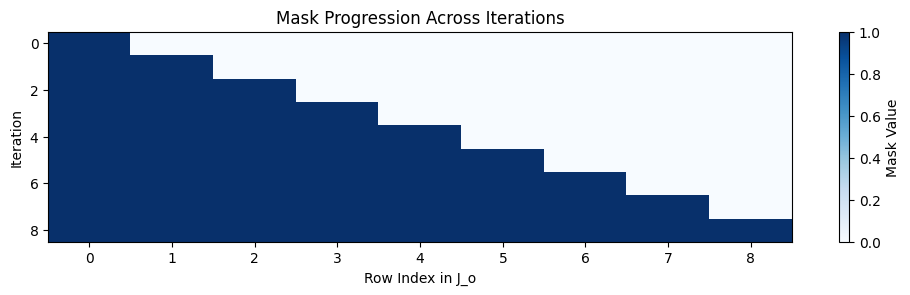

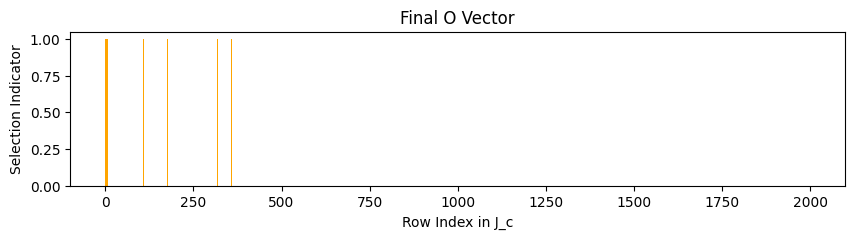

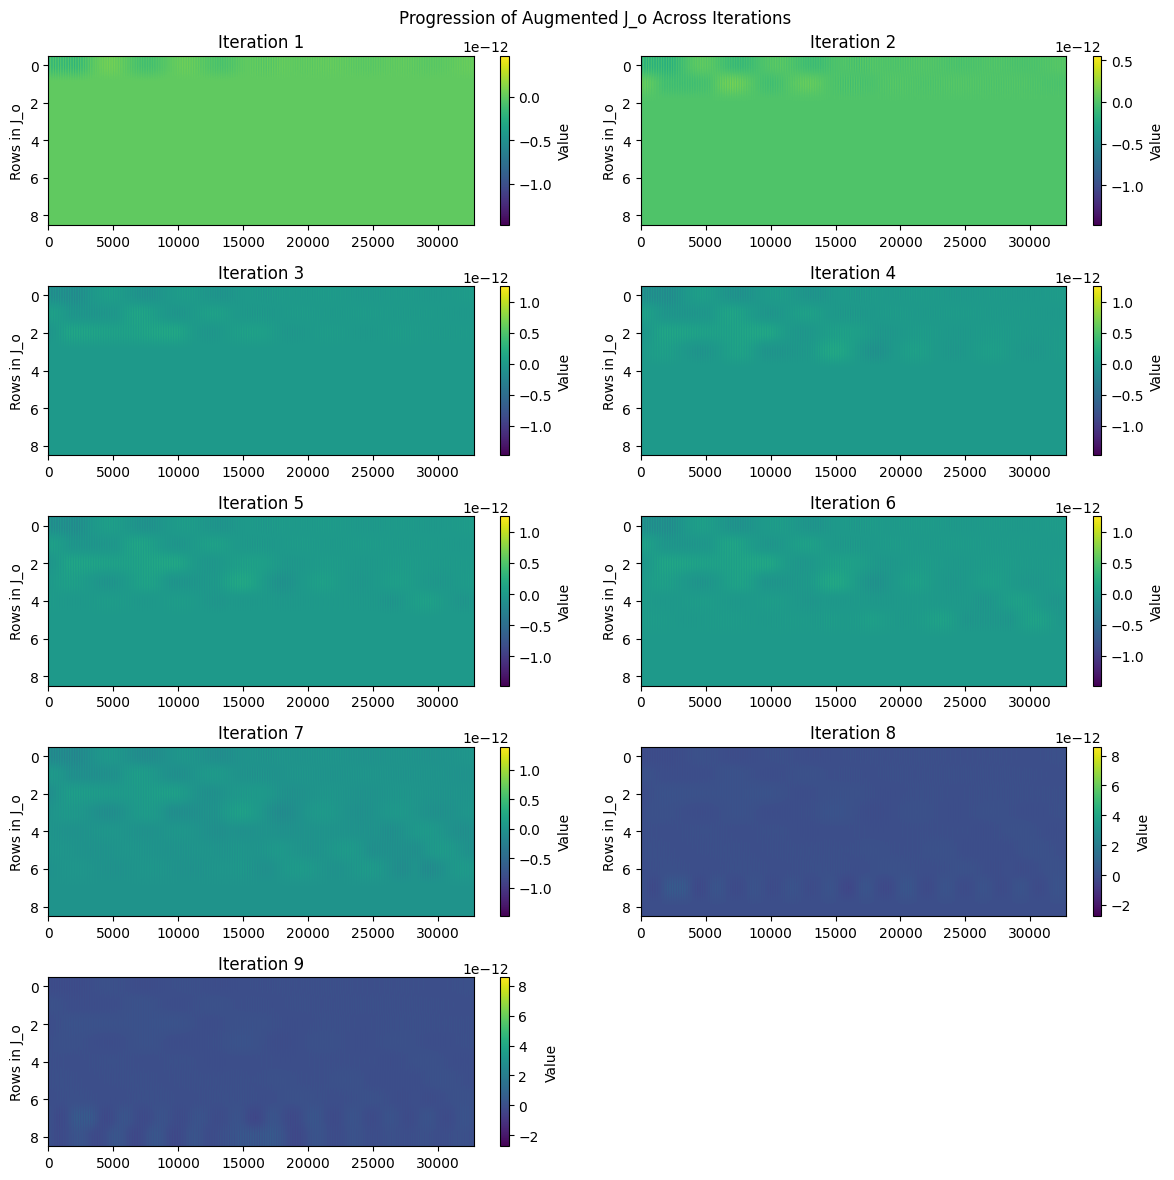

0 0
3 1
6 2
108 3
176 4
318 5
358 6
421 7
550 8
Ordered list [0, 3, 6, 108, 176, 318, 358, 421, 550]


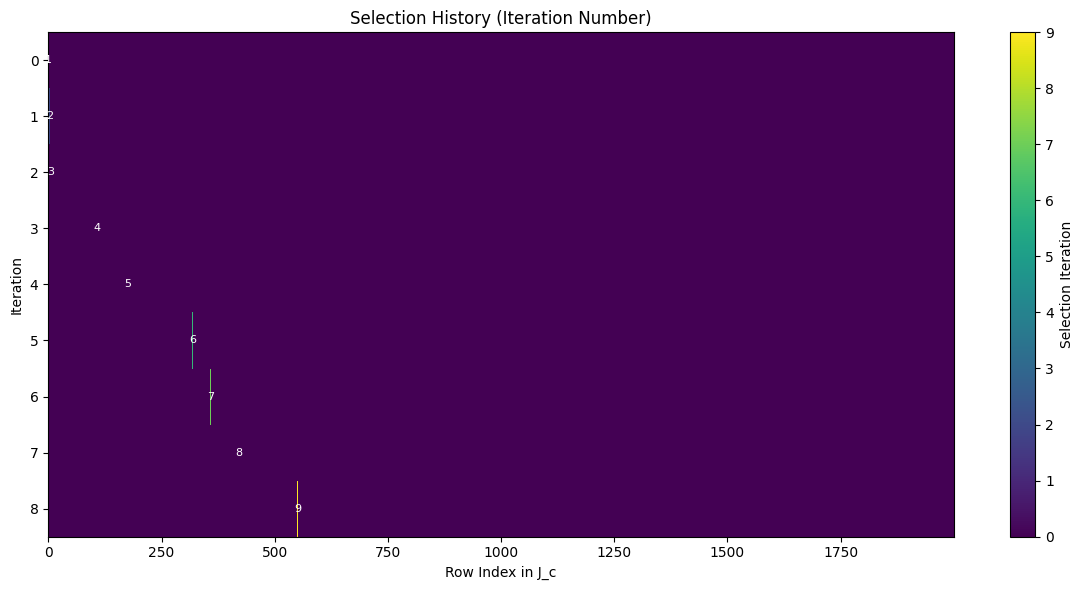

In [3]:
import jax
import jax.numpy as jnp
from jax.lax import cond, scan
import matplotlib.pyplot as plt

def eigenvalue_criterion(J_o, threshold=0.5):
    """Compute the eigenvalue-based selection criterion."""
    # JTJ = J_o.T @ J_o
    # JTJ = J_o @ J_o.T
    # eigenvalues = jnp.linalg.eigh(JTJ)[0]  # Get eigenvalues (sorted in ascending order)
    eigenvalues = jnp.sort(jnp.linalg.svdvals(J_o)**2)[::-1]
    sharpness = 1/threshold * 100000
    return jnp.sum(jax.nn.sigmoid(sharpness * (eigenvalues - threshold)))  # Differentiable "count" above threshold
    # return jnp.where(eigenvalues > threshold, 1.0, 0.0).sum()  # Hard selection

def iterative_selection_no_reselection(J_c, num_rows, threshold=0.5):
    """Iteratively build J_o while preventing reselection of rows."""
    n, m = J_c.shape

    def step_fn(carry, _):
        J_o, O, mask, mask_history, criterion_log, selection_mask = carry

        # Masked J_o to consider only active rows
        active_J_o = J_o * mask[:, None]

        # Current criterion based on active rows
        current_criterion = cond(
            mask.sum() > 0,
            lambda _: eigenvalue_criterion(active_J_o, threshold),
            lambda _: 0.0,
            operand=None,
        )

        # Compute scores by evaluating criterion improvement for each row
        def compute_score(row):
            # Find the first zero row in active_J_o
            zero_row_idx = jnp.argmax(jnp.all(active_J_o == 0, axis=1))

            # Replace the zero row with the candidate row
            augmented_J_o = active_J_o.at[zero_row_idx].set(row)

            # Compute the eigenvalue criterion for the updated J_o
            return eigenvalue_criterion(augmented_J_o, threshold) - current_criterion


        scores = jax.vmap(compute_score)(J_c)

        # Apply the selection mask: Set scores of already selected rows to -inf
        scores = jnp.where(selection_mask == 1, scores, -jnp.inf)

        # Log the scores (criterion improvements)
        criterion_log = criterion_log.at[_, :].set(scores)

        # Select the best row (hard selection)
        best_row_idx = jnp.argmax(scores)
        best_row = J_c[best_row_idx]

        # Update J_o using the next available row slot
        idx = jnp.argmax(mask == 0)  # Find the next available row
        J_o = J_o.at[idx].set(best_row)

        # Update the mask to mark the new row as active
        mask = mask.at[idx].set(1)

        # Update the selection vector O (mark the selected row only once)
        O = O.at[best_row_idx].set(1)

        # Update the selection mask to exclude the selected row
        selection_mask = selection_mask.at[best_row_idx].set(0)

        # Append the current mask to mask_history
        mask_history = mask_history.at[_, :].set(mask)

        return (J_o, O, mask, mask_history, criterion_log, selection_mask), None

    # Initialize J_o, O, mask, and logging arrays
    J_o_init = jnp.zeros((num_rows, m))  # Pre-allocate J_o with a fixed shape
    O_init = jnp.zeros((n, 1))  # Initial selection vector
    mask_init = jnp.zeros(num_rows, dtype=jnp.int32)  # Mask to track active rows in J_o
    mask_history_init = jnp.zeros((num_rows, num_rows), dtype=jnp.int32)  # Store masks at each iteration
    criterion_log_init = jnp.zeros((num_rows, n))  # Log criterion improvements for each row
    selection_mask_init = jnp.ones(n, dtype=jnp.float32)  # Selection mask (1 = eligible, 0 = selected)

    # Iterate using JAX scan
    (J_o_final, O_final, _, mask_history, criterion_log, _), _ = scan(
        step_fn, 
        (J_o_init, O_init, mask_init, mask_history_init, criterion_log_init, selection_mask_init), 
        jnp.arange(num_rows)
    )
    return J_o_final, O_final, mask_history, criterion_log

# Track the history of active_J_o during iterations
def iterative_selection_with_active_tracking(J_c, num_rows, threshold=0.5):
    """Iteratively build J_o while keeping track of active_J_o progression."""
    n, m = J_c.shape

    def step_fn(carry, _):
        J_o, O, mask, mask_history, criterion_log, selection_mask, active_J_o_history = carry

        # Masked J_o to consider only active rows
        active_J_o = J_o * mask[:, None]

        # Store current active_J_o in history
        active_J_o_history = active_J_o_history.at[_, :, :].set(active_J_o)

        # Current criterion based on active rows
        current_criterion = cond(
            mask.sum() > 0,
            lambda _: eigenvalue_criterion(active_J_o, threshold),
            lambda _: 0.0,
            operand=None,
        )

        # Compute scores by evaluating criterion improvement for each row
        def compute_score(row):
            # Find the first zero row in active_J_o
            zero_row_idx = jnp.argmax(jnp.all(active_J_o == 0, axis=1))

            # Replace the zero row with the candidate row
            augmented_J_o = active_J_o.at[zero_row_idx].set(row)

            # Compute the eigenvalue criterion for the updated J_o
            return eigenvalue_criterion(augmented_J_o, threshold) - current_criterion

        scores = jax.vmap(compute_score)(J_c)

        # Apply the selection mask: Set scores of already selected rows to -inf
        scores = jnp.where(selection_mask == 1, scores, -jnp.inf)

        # Log the scores (criterion improvements)
        criterion_log = criterion_log.at[_, :].set(scores)

        # Select the best row (hard selection)
        best_row_idx = jnp.argmax(scores)
        best_row = J_c[best_row_idx]

        # Update J_o using the next available row slot
        idx = jnp.argmax(mask == 0)  # Find the next available row
        J_o = J_o.at[idx].set(best_row)

        # Update the mask to mark the new row as active
        mask = mask.at[idx].set(1)

        # Update the selection vector O (mark the selected row only once)
        O = O.at[best_row_idx].set(1)

        # Update the selection mask to exclude the selected row
        selection_mask = selection_mask.at[best_row_idx].set(0)

        # Append the current mask to mask_history
        mask_history = mask_history.at[_, :].set(mask)

        return (J_o, O, mask, mask_history, criterion_log, selection_mask, active_J_o_history), None

    # Initialize J_o, O, mask, and logging arrays
    J_o_init = jnp.zeros((num_rows, m))  # Pre-allocate J_o with a fixed shape
    O_init = jnp.zeros((n, 1))  # Initial selection vector
    mask_init = jnp.zeros(num_rows, dtype=jnp.int32)  # Mask to track active rows in J_o
    mask_history_init = jnp.zeros((num_rows, num_rows), dtype=jnp.int32)  # Store masks at each iteration
    criterion_log_init = jnp.zeros((num_rows, n))  # Log criterion improvements for each row
    selection_mask_init = jnp.ones(n, dtype=jnp.float32)  # Selection mask (1 = eligible, 0 = selected)
    active_J_o_history_init = jnp.zeros((num_rows, num_rows, m))  # Store active_J_o progression

    # Iterate using JAX scan
    (J_o_final, O_final, _, mask_history, criterion_log, _, active_J_o_history), _ = scan(
        step_fn, 
        (J_o_init, O_init, mask_init, mask_history_init, criterion_log_init, selection_mask_init, active_J_o_history_init), 
        jnp.arange(num_rows)
    )
    return J_o_final, O_final, mask_history, criterion_log, active_J_o_history

# Modified function with `augmented_J_o` tracing
def iterative_selection_with_augmented_tracking(J_c, num_rows, threshold=0.5):
    """Iteratively build J_o while keeping track of augmented_J_o progression."""
    n, m = J_c.shape

    def step_fn(carry, _):
        J_o, O, mask, mask_history, criterion_log, selection_mask, augmented_J_o_history = carry

        # Masked J_o to consider only active rows
        active_J_o = J_o * mask[:, None]

        # Current criterion based on active rows
        current_criterion = cond(
            mask.sum() > 0,
            lambda _: eigenvalue_criterion(active_J_o, threshold),
            lambda _: 0.0,
            operand=None,
        )

        def compute_score(row):
            # Find the first zero row in active_J_o
            zero_row_idx = jnp.argmax(jnp.all(active_J_o == 0, axis=1))

            # Replace the zero row with the candidate row (create a new augmented_J_o)
            augmented_J_o = active_J_o.at[zero_row_idx].set(row)

            # Compute the eigenvalue criterion for the updated J_o
            return eigenvalue_criterion(augmented_J_o, threshold) - current_criterion, augmented_J_o

        # Compute scores and track augmented_J_o for each row
        results = jax.vmap(compute_score, out_axes=(0, 0))(J_c)
        scores, augmented_J_os = results

        # Apply the selection mask: Set scores of already selected rows to -inf
        scores = jnp.where(selection_mask == 1, scores, -jnp.inf)

        # Log the scores (criterion improvements)
        criterion_log = criterion_log.at[_, :].set(scores)

        # Select the best row (hard selection)
        best_row_idx = jnp.argmax(scores)
        best_row = J_c[best_row_idx]

        # Update J_o using the next available row slot
        idx = jnp.argmax(mask == 0)  # Find the next available row
        J_o = J_o.at[idx].set(best_row.astype(jnp.complex64))

        # Update the mask to mark the new row as active
        mask = mask.at[idx].set(1)

        # Update the selection vector O (mark the selected row only once)
        O = O.at[best_row_idx].set(1)

        # Update the selection mask to exclude the selected row
        selection_mask = selection_mask.at[best_row_idx].set(0)

        # Append the best augmented_J_o to its history
        augmented_J_o_history = augmented_J_o_history.at[_, :, :].set(augmented_J_os[best_row_idx])

        # Append the current mask to mask_history
        mask_history = mask_history.at[_, :].set(mask)

        return (J_o, O, mask, mask_history, criterion_log, selection_mask, augmented_J_o_history), None

    # Initialize J_o, O, mask, and logging arrays
    J_o_init = jnp.zeros((num_rows, m),dtype=jnp.complex64)  # Pre-allocate J_o with a fixed shape
    O_init = jnp.zeros((n, 1),dtype=jnp.complex64)  # Initial selection vector
    mask_init = jnp.zeros(num_rows, dtype=jnp.complex64)  # Mask to track active rows in J_o
    mask_history_init = jnp.zeros((num_rows, num_rows), dtype=jnp.complex64)  # Store masks at each iteration
    criterion_log_init = jnp.zeros((num_rows, n),dtype=jnp.complex64)  # Log criterion improvements for each row
    selection_mask_init = jnp.ones(n, dtype=jnp.complex64)  # Selection mask (1 = eligible, 0 = selected)
    augmented_J_o_history_init = jnp.zeros((num_rows, num_rows, m),dtype=jnp.complex64)  # Store augmented_J_o progression

    # Iterate using JAX scan
    (J_o_final, O_final, _, mask_history, criterion_log, _, augmented_J_o_history), _ = scan(
        step_fn,
        (J_o_init, O_init, mask_init, mask_history_init, criterion_log_init, selection_mask_init, augmented_J_o_history_init),
        jnp.arange(num_rows)
    )
    return J_o_final, O_final, mask_history, criterion_log, augmented_J_o_history


def create_test_matrix(n, m, significant_rows=5, random_seed=0):
    """Create a test matrix J_c with a few significant rows."""
    key = jax.random.PRNGKey(random_seed)
    J_c = jnp.zeros((n, m))
    # Generate random values for the significant rows
    non_zero_rows = jax.random.choice(key, n, shape=(significant_rows,), replace=False)
    random_values = jax.random.normal(key, (significant_rows, m))
    J_c = J_c.at[non_zero_rows, :].set(random_values)
    return J_c, non_zero_rows

# Generate test matrix
n, m = 100, 20  # Total rows and columns
significant_rows = 5
J_c, expected_rows = create_test_matrix(n, m, significant_rows)


loaded_data = jnp.load('arrays_complete.npz')

# # # Access arrays by index
loaded_arrays = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data))]

# vstack teh arrays
J_c = (jnp.vstack(loaded_arrays))
print(J_c.shape)


# Run the algorithm with logging
num_rows = significant_rows + 4
threshold = 10e-22
# J_o_final, O_final, mask_history, criterion_log = iterative_selection_no_reselection(J_c, num_rows, threshold)
# J_o_final, O_final, mask_history, criterion_log, active_J_o_history = iterative_selection_with_active_tracking(J_c, num_rows, threshold)
J_o_final, O_final, mask_history, criterion_log, augmented_J_o_history = iterative_selection_with_augmented_tracking(J_c, num_rows, threshold)

# Extract the selected row indices
selected_rows = jnp.where(O_final.flatten() == 1)[0]

print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape, "augmented_J_o_history shape", augmented_J_o_history.shape)  
# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape)

# Verify the results
print("Expected significant rows (indices):", jnp.sort(expected_rows))
print("Selected rows (indices):", selected_rows)

# Check if all expected rows are in the selected rows
all_expected_selected = jnp.all(jnp.isin(expected_rows, selected_rows))
print("Are all expected rows among the selected rows?", all_expected_selected)


# Plot the mask history
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(jnp.real(mask_history), aspect='auto', cmap='Blues')
plt.colorbar(label="Mask Value")
plt.xlabel("Row Index in J_o")
plt.ylabel("Iteration")
plt.title("Mask Progression Across Iterations")

# Plot O_final
plt.figure(figsize=(10, 2))
plt.bar(jnp.arange(len(O_final)), jnp.real(O_final.flatten()), color='orange')
plt.xlabel("Row Index in J_c")
plt.ylabel("Selection Indicator")
plt.title("Final O Vector")
plt.show()

# # Plot the criterion values
# plt.subplot(2, 1, 2)
# plt.imshow(criterion_log, aspect='auto', cmap='viridis')
# plt.colorbar(label="Criterion Improvement")
# plt.xlabel("Row Index in J_c")
# plt.ylabel("Iteration")
# plt.title("Criterion Improvement Across Iterations")
# plt.tight_layout()
# plt.show()

# Plot the progression of active_J_o
# plt.figure(figsize=(12, 6))
# for i in range(active_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(active_J_o_history[i], aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")

# plt.tight_layout()
# plt.show()

# Plot the progression of augmented_J_o
plt.figure(figsize=(12, 12))
for i in range(augmented_J_o_history.shape[0]):
    plt.subplot(num_rows // 2 + 1, 2, i + 1)
    plt.imshow(jnp.real(augmented_J_o_history[i]), aspect='auto', cmap='viridis')
    plt.colorbar(label="Value")
    plt.title(f"Iteration {i + 1}")
    # plt.xlabel("Features")
    plt.ylabel("Rows in J_o")
plt.suptitle("Progression of Augmented J_o Across Iterations")
plt.tight_layout()
plt.show()


# Create a matrix to record the selection history
selection_history = jnp.zeros_like(criterion_log, dtype=jnp.complex64)

# Populate the selection history matrix with iteration numbers
selected_rows = []
for iteration in range(criterion_log.shape[0]):
    best_row_idx = jnp.argmax(jnp.real(criterion_log[iteration]))  # Get the selected row for this iteration
    selected_rows.append(best_row_idx)
    selection_history = selection_history.at[iteration, best_row_idx].set(iteration + 1)

# Plot the selection history heatmap
plt.figure(figsize=(12, 6))

# Heatmap of selection history
plt.imshow(jnp.real(selection_history), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Selection Iteration")
plt.xlabel("Row Index in J_c")
plt.ylabel("Iteration")
plt.title("Selection History (Iteration Number)")

# Annotate the heatmap with iteration numbers
ordered_list = []
for iteration, row_idx in enumerate(selected_rows):
    plt.text(row_idx, iteration, str(iteration + 1), color="white", ha="center", va="center", fontsize=8)
    print(row_idx, iteration)
    ordered_list.append(row_idx.item())
print("Ordered list", ordered_list)
plt.tight_layout()
plt.show()


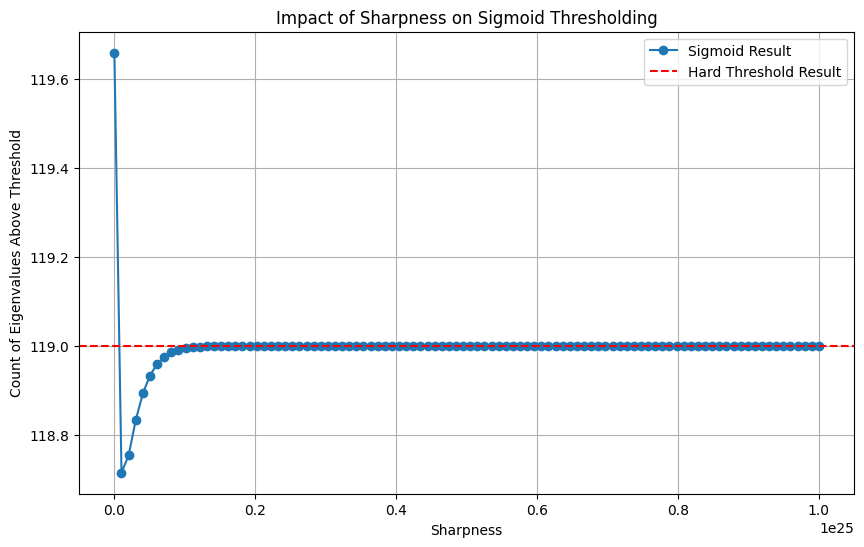

In [19]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Generate a test matrix with very low values
def create_low_value_matrix(n, m, random_seed=0):
    key = jax.random.PRNGKey(random_seed)
    return jax.random.normal(key, (n, m)) * 10e-22

# Hard threshold function
def hard_threshold(eigenvalues, threshold):
    return jnp.where(eigenvalues > threshold, 1.0, 0.0).sum()

# Sigmoid-based threshold function with varying sharpness
def sigmoid_threshold(eigenvalues, threshold, sharpness):
    return jnp.sum(jax.nn.sigmoid(sharpness * (eigenvalues - threshold)))

# Test the impact of sharpness on the result
def test_sharpness(matrix, threshold, sharpness_values):
    # JTJ =  matrix @ matrix.T  # Compute the matrix product
    # eigenvalues = jnp.linalg.eigh(JTJ)[0]  # Extract eigenvalues
    eigenvalues = jnp.sort(jnp.linalg.svdvals(matrix)**2)[::-1]
    
    # Compute the hard threshold result
    hard_result = hard_threshold(eigenvalues, threshold)
    
    # Evaluate sigmoid results for each sharpness value
    sigmoid_results = [sigmoid_threshold(eigenvalues, threshold, s) for s in sharpness_values]
    
    return hard_result, sigmoid_results

# Parameters
n, m = 50, 50  # Dimensions of the matrix
threshold = 10e-22  # Hard threshold value
sharpness_values = jnp.linspace(10e21, 10e24, 100)  # Range of sharpness values to test

# Create the matrix and test
# matrix = create_low_value_matrix(n, m)
matrix = J_c
hard_result, sigmoid_results = test_sharpness(matrix, threshold, sharpness_values)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sharpness_values, sigmoid_results, label="Sigmoid Result", marker='o')
plt.axhline(y=hard_result, color='r', linestyle='--', label="Hard Threshold Result")
plt.xlabel("Sharpness")
plt.ylabel("Count of Eigenvalues Above Threshold")
plt.title("Impact of Sharpness on Sigmoid Thresholding")
plt.legend()
plt.grid()
plt.show()
